# **SAUDI ARABIA RBC MODEL**

##### PSME 2023-2024 Macroeconomics Group: 
- Cameron Jessie
- Landini Elia
- Molitor Maurice

The following notebook houses our Saudi Arabia RBC Estimation Project. This project is aimed at employing Real Business Cycle (RBC) modeling in order to provide policy advice for Saudi Arabia.

## Introductory Set-up

In [1]:
#Download packages
!pip install aiohttp --only-binary :all:
!pip install pandas -q
!pip install pandas_datareader -q
!pip install prettytable -q
!pip install statsmodels -q
!pip install gatspy -q
!pip install wbgapi -q
!pip install wbdata -q
!pip install requests beautifulsoup4 pandas -q
!pip install gEconpy -q
!pip install joblib -q
!pip install tsdisagg -q
!pip install scikit-learn -q

In [2]:
# Import necessary libraries and modules
%matplotlib inline
import sys

sys.path.append("..")

import os 
import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import statsmodels.api as sm
from pandas_datareader.fred import FredReader
from pandas_datareader import wb
from tsdisagg import disaggregate_series
import statsmodels.api as sm
import gatspy as gatspy

# Configure matplotlib settings for consistent and clear visualizations
config = {
    "figure.figsize": (14, 4),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

### Create Helper Functions

In [3]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

### Global Variable

In [4]:
vars_to_plot = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'Rt', 'N','K', 'CA', 'CPI', 'Ex_rate', 'Oil']

## **CHAPTER 1: PROCESSING DATA**

### Overview of data requirements

Note: The table below functions as a reference for summarising the variables required for import and is not intended for descriptive purposes.


| Step | Imported | Season adjusted | Currency adjusted | Variable | Variable Name | Shortcut | Note | Source | Link | Date |
|------|-----------|-------------------|---------------------|----------|---------------|----------|------|--------|------|------|
| 1b    | Yes       |        Yes        | SAR               | Y       | Real GDP      | NGDPRSAXDCSAQ | USD, SA, Quarterly | FRED | [Link](https://fred.stlouisfed.org/series/NGDPRSAXDCSAQ) | 2010 - current |
| 1a    | Yes       |        No      | USD               | Y_yearly       | GDP in current prices    | NY.GDP.MKTP.CD | USD, Yearly | Worldbank | [Link](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD) | 1960 - current |
| 2    | Yes       |        Yes           | SAR              | C        | Real Private Sector Final Consumption Expenditure | NCPRNSAXDCSAQ | Domestic Currency, Not SA, Quarterly | FRED | [Link](https://fred.stlouisfed.org/series/NCPRNSAXDCSAQ) | 2010 - current |
| 3    | Yes       | Yes          | Billion USD                | I       | Gross Fixed Capital Formation | NE.GDI.FTOT.CD | Current US Dollar, Annual | WorldBank | [Link](https://data.worldbank.org/indicator/NE.GDI.FTOT.CD?locations=SA) | 1968-2022 |
| 4    | Yes       | Yes                | Billion USD                  | TB      | Trade Balance | BN.GSR.GNFS.CD | Net trade in goods and services (BOP, current US$) | World Bank | [Link](https://data.worldbank.org/indicator/BN.GSR.GNFS.CD?locations=SA) | 1971-2022 |
| 5    | Yes        | Yes         | Hours worked     | N       | Average Hours of Work for Employed Persons | Manually Imported | Measures the average weekly working hours of workers (15 years and over) | General Statistics Authority | [Link](https://database.stats.gov.sa/home/indicator/999118) | Q2 2016-Q2 2023 |
| 6    | Yes        |     Yes              |         SAR         | w       | Average Monthly Wages for Paid Employees | Manually Imported | The sum of the monthly wages to the total of employed persons for wages | General Statistics Authority | [Link](https://database.stats.gov.sa/home/indicator/999118) | Q2 2016-Q2 2023 |
| 7    | Yes       |       N/A          |  %                | R   | Real Long Term Bond Rate | Manually Imported | 10-year government development bond yield, Quarterly | National Statistics, Saudi Central Bank | [Link](https://www.sama.gov.sa/en-US/GovtSecurity/pages/governmentdevelopmentbonds.aspx)| Q1999-Q32007, Past 3 yrs |
| 8    | Yes       |        N/A           |  %                | r       | Short Term Bond Rate | Manually Imported | Quarterly average of interbank rate | Saudi Central Bank | [Link](https://www.sama.gov.sa/ar-sa/EconomicReports/Pages/report.aspx?cid=118) | 2007-current |
| 9    | Yes       |           No        | Millions of 2017 U.S. dollars         | K       | Capital Stock at Constant National Prices | RKNANPSAA666NRUG | Millions of 2017 U.S. Dollars, Not SA, Annual | FRED | [Link](https://fred.stlouisfed.org/series/RKNANPSAA666NRUG) | 1970-2019 |
| 10   | Yes       |        Investigate           |  %                | CA      | Current Account | BN.CAB.XOKA.GD.ZS | Current account balance % of GDP, Annual | Worldbank | [Link](https://data.worldbank.org/indicator/BN.CAB.XOKA.GD.ZS?locations=SA) | 1970-2021 |
| 11   | Yes       |         Investigate       | %                |  CPI           | Consumer Prices | FP.CPI.TOTL.ZG |Inflation, consumer prices (annual %) - Saudi Arabia|  Worldbank |  [Link](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=SA) | 1964-2021 |
| 12   | Yes       |    N/A  |   %         |                    Ex_Rate       | Exchange Rate  | SAUCCUSMA02STM | The Saudi riyal has been at a fixed rate to the US dollar since June 1986 (SAR 3.7500 per USD) |FRED  | [Link](https://fred.stlouisfed.org/series/SAUCCUSMA02STM) | 1965-2023 |
| 13   | YES | No       | U.S. Dollars per Barrel    | Oil      | Crude Oil, Brent Prices | DCOILWTICO | Crude oil, average spot price of Brent, Dubai and West Texas Intermediate, equally weighed, Monthly | FRED | [Link](https://fred.stlouisfed.org/series/DCOILWTICO) | 1986 -2023 |


### 1) Import Data

In [5]:
## Print the current working directory to the console
print(os.getcwd())

C:\Users\jessi\OneDrive\Documents\GitHub\Macro project\Uni-projects


##### FRED and World Bank Data

In [134]:
# List of indicators from FRED (Federal Reserve Economic Data)
fred_indicators = ['NGDPRSAXDCSAQ', # Real Gross Domestic Product Y
              'NCPRNSAXDCSAQ', # Real Private Sector Final Consumption Expenditure 
              'RKNANPSAA666NRUG', # Capital Stock
                'SAUCCUSMA02STM', # Exchange Rate
                   'DCOILWTICO'] # Oil

# List of indicators from World Bank
wb_indicators = ['NY.GDP.MKTP.CD', # Real Gross Domestic Product 
                'NE.GDI.FTOT.CD', # Investment
                'BN.GSR.GNFS.CD', # Trade Balance
               'BN.CAB.XOKA.GD.ZS', #Consumer Prices
             'FP.CPI.TOTL.ZG'] #Current Account

rename_dict = {'NGDPRSAXDCSAQ': 'Y',
               'NY.GDP.MKTP.CD': 'Y_yearly',
                'NE.GDI.FTOT.CD': 'I',
               'NCPRNSAXDCSAQ': 'C',
               'BN.GSR.GNFS.CD': 'TB',
               'BN.CAB.XOKA.GD.ZS': 'CA',
               'RKNANPSAA666NRUG': 'K',
                'SAUCCUSMA02STM': 'Ex_rate',
              'FP.CPI.TOTL.ZG': 'CPI',
              'DCOILWTICO': 'Oil'}

In [135]:
# Check if the combined data file already exists
if not os.path.isfile('Data_Stored/SA_combined_data.csv'):
    # If the file doesn't exist, download and save the data
    # Using FredReader to fetch data from FRED (Federal Reserve Economic Data)
    df_fred = FredReader(symbols=fred_indicators, start='1987', end=None).read()  # Starting in 1987 due to the exchange rate
    
    # Using wb.download to fetch World Bank data
    df_wb = wb.download(indicator=wb_indicators, country=['SA'], start='1987', end=None)  # Starting in 1987 due to the exchange rate
    
    # Drop the first level of the MultiIndex and convert the index to datetime
    df_wb = df_wb.droplevel(level=0)
    df_wb.index = pd.to_datetime(df_wb.index)

    # Combine FRED and World Bank data, rename columns using the provided dictionary
    data = df_fred.join(df_wb).rename(columns=rename_dict)
    
    # Save the combined data to a CSV file
    data.to_csv('Data_Stored/SA_combined_data.csv')

else:
    # If the file already exists, load the data from the disk
    file_path = 'Data_Stored/SA_combined_data.csv'
    df = pd.read_csv(file_path, parse_dates=['DATE'])
    
    # Convert the DATE column to datetime if it's not already and set it as the index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   C         55 non-null     float64
 2   K         33 non-null     float64
 3   Ex_rate   442 non-null    float64
 4   Oil       9317 non-null   float64
 5   Y_yearly  36 non-null     float64
 6   I         36 non-null     float64
 7   TB        36 non-null     float64
 8   CA        36 non-null     float64
 9   CPI       36 non-null     float64
dtypes: float64(10)
memory usage: 840.0 KB


The following code verifies the accurate import of each data series from FRED or the World Bank, ensuring precision and reliability in our dataset.


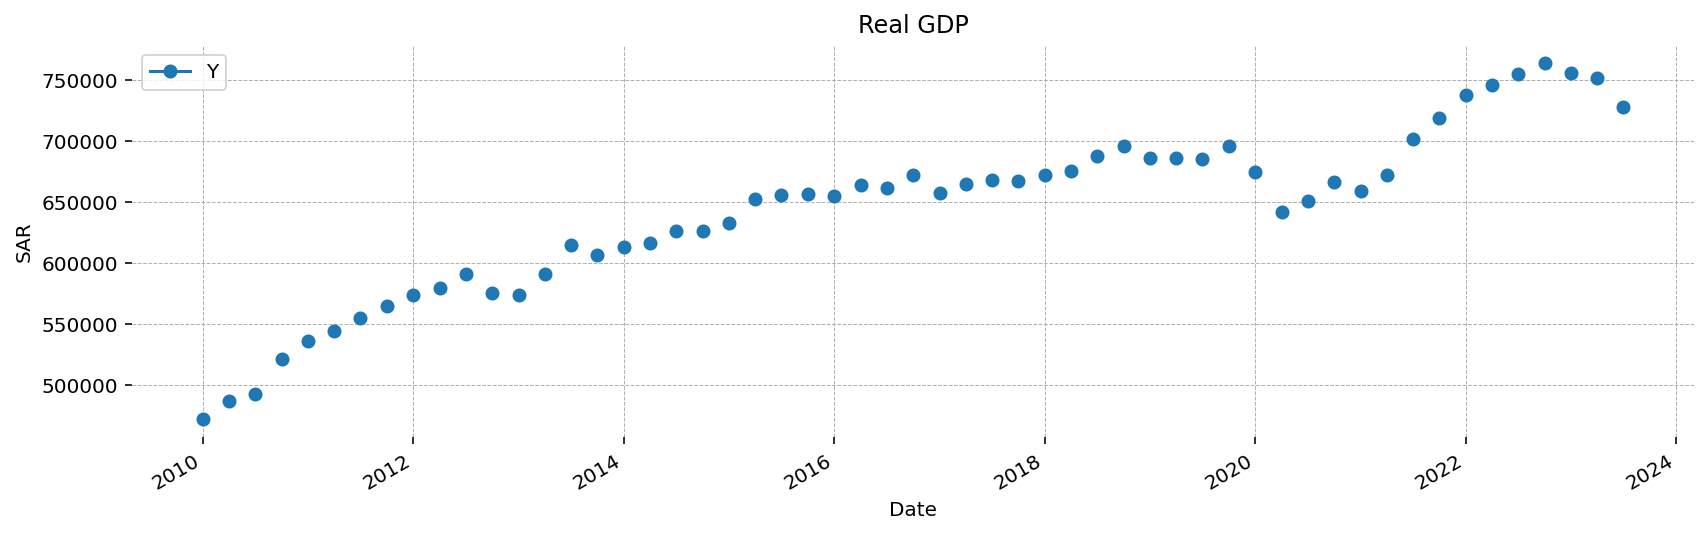

In [137]:
# Create dataframe for Y
df_Y = df[['Y']].copy()

# Plot the Y variable over time with markers at data points
df_Y.plot(marker='o')

plt.title('Real GDP')
plt.xlabel('Date')
plt.ylabel('SAR')

# Display the plot
plt.show()

To ensure the accuracy of the GDP series, a thorough cross-checking process was conducted, involving multiple reputable sources such as the World Bank and the IMF. The objective was to ascertain whether the data are reported in U.S. dollars or Saudi Riyal (SAR). Following this comprehensive validation, we conclude that this GDP series is reported in Saudi Riyal.

The nominal GDP series from the World Bank presented below is one of the sources utilised to verify this data.


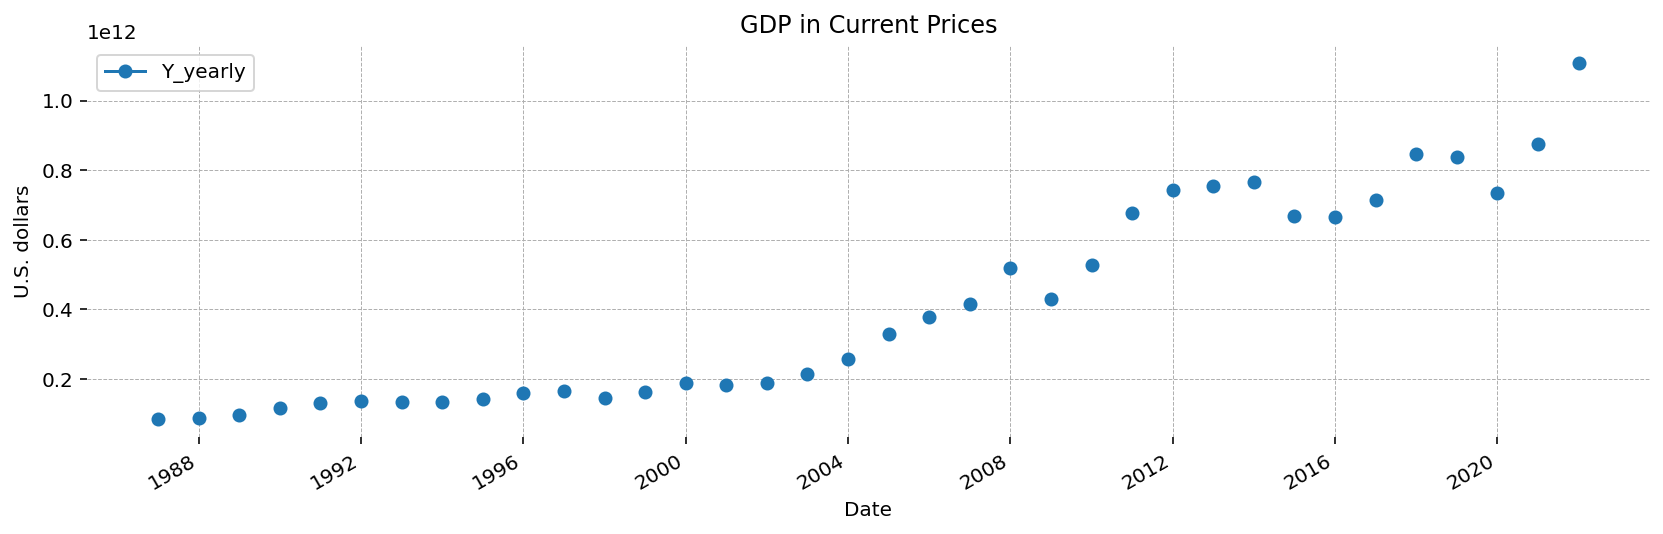

In [138]:
# Create dataframe for Y
df_Y = df[['Y_yearly']].copy()

# Plot the Y variable over time with markers at data points
df_Y.plot(marker='o')

plt.title('GDP in Current Prices')
plt.xlabel('Date')
plt.ylabel('U.S. dollars')

# Display the plot
plt.show()

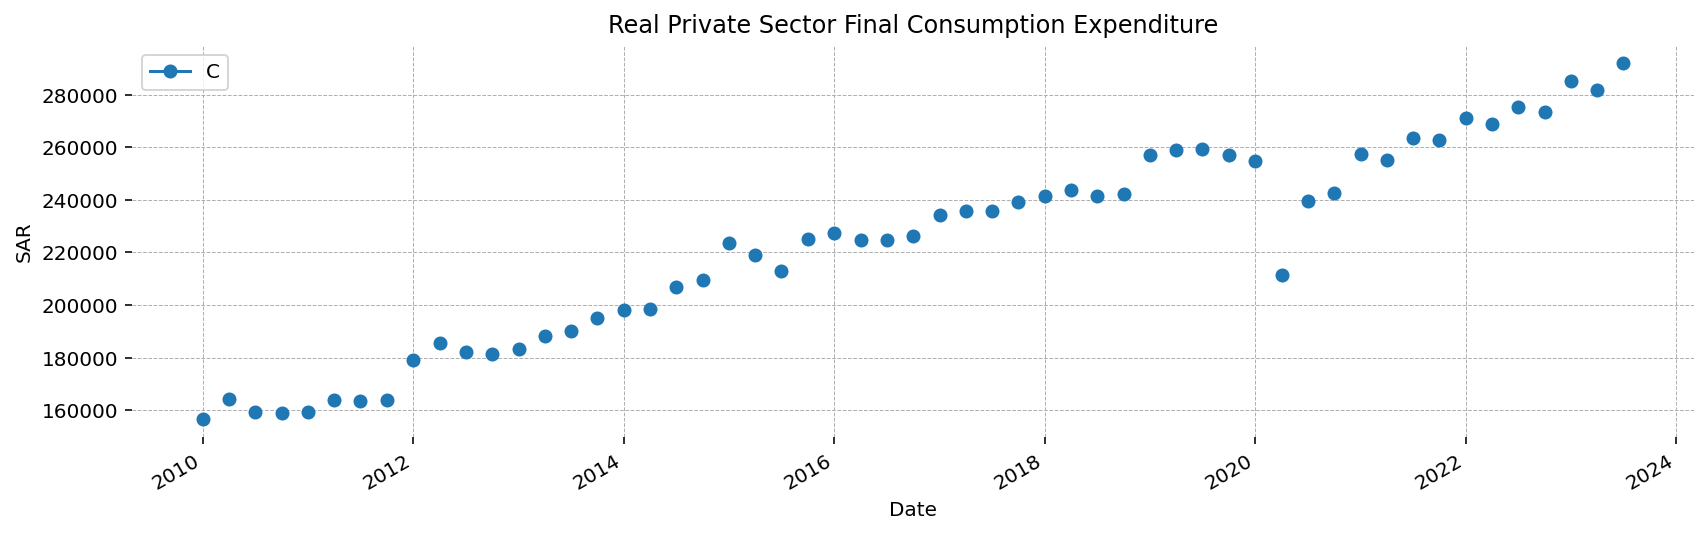

In [139]:
# Create dataframe for C
df_C = df[['C']].copy()

# Plot the 'C' variable over time with markers at data points
df_C.plot(marker='o')

plt.title('Real Private Sector Final Consumption Expenditure')
plt.xlabel('Date')
plt.ylabel('SAR')

# Display the plot
plt.show()

Similar to GDP, the consumption series is sourced from FRED, which explicitly indicates that consumption is reported in the domestic currency. To validate this information, we cross-checked the ratio of consumption to GDP, finding it to be approximately 30 percent. This alignment supports the conclusion that the consumption series is indeed reported in Saudi Arabian Riyal (SAR), as the consistency with the established consumption-to-GDP ratio further confirms the reporting currency.


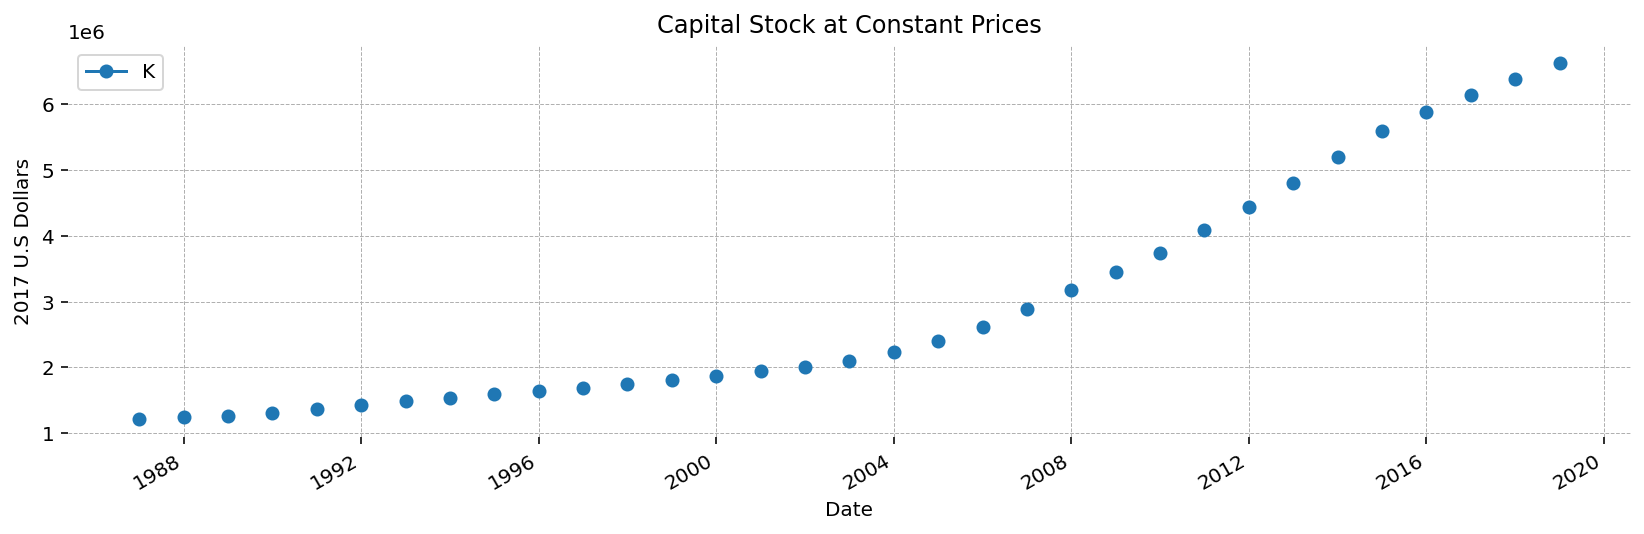

In [140]:
# Create dataframe for capital
df_K = df[['K']].copy()

# Plot the K variable over time with markers at data points
df_K.plot(marker='o')

plt.title('Capital Stock at Constant Prices')
plt.xlabel('Date')
plt.ylabel('2017 U.S Dollars')

# Display the plot
plt.show()

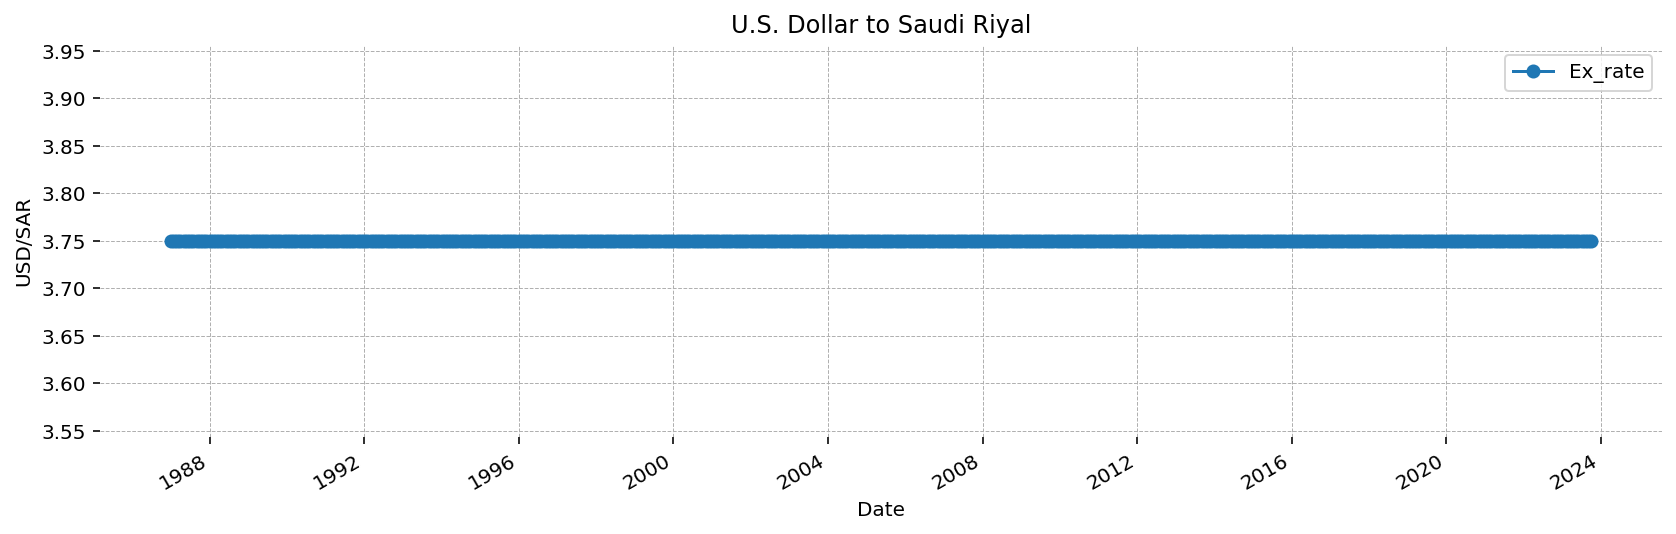

In [141]:
# Create dataframe for exchange rate
df_Ex_rate = df[['Ex_rate']].copy()

# Plot the 'C' variable over time with markers at data points
df_Ex_rate.plot(marker='o')

# Set plot labels and title
plt.title('U.S. Dollar to Saudi Riyal')
plt.xlabel('Date')
plt.ylabel('USD/SAR')

# Display the plot
plt.show()

Saudi Arabia has a fixed exchange rate regime with a dollar peg. The spot USD/SAR exchange rate has remained unchanged at 3.7500 since June 1986.

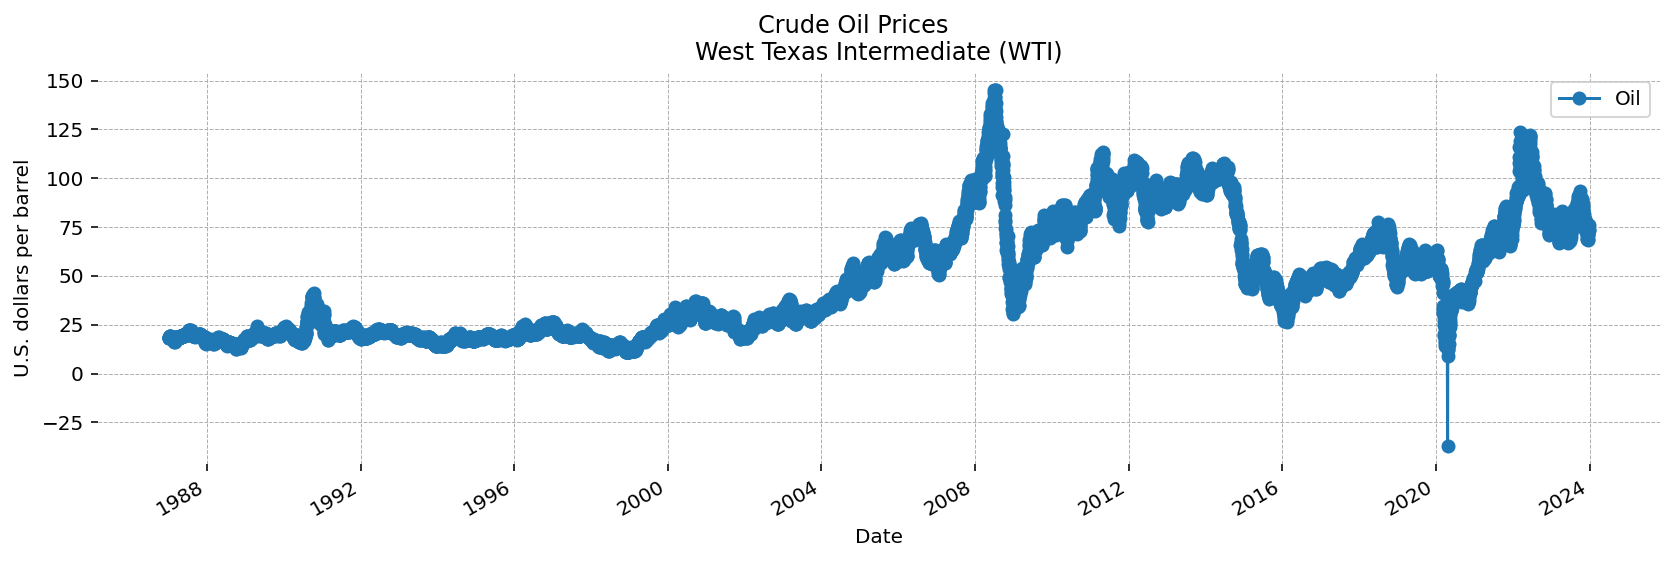

In [142]:
# Create dataframe for oil prices
df_Oil = df[['Oil']].copy()

# Plot the 'C' variable over time with markers at data points
df_Oil.plot(marker='o')

# Set plot labels and title
plt.suptitle('Crude Oil Prices')
plt.title('West Texas Intermediate (WTI)')
plt.xlabel('Date')
plt.ylabel('U.S. dollars per barrel')

# Display the plot
plt.show()

During the graphical visualization of oil prices, a notable outlier was observed in early 2020. To validate the accuracy of this data point, the following code prints the lowest value of the oil prices, which was then cross-checked with the primary data source to ensure precision. The verification process confirmed the accuracy of this particular data point.

This observed outlier aligns with economic reasoning, particularly the significant decline in oil prices at the onset of the Covid-19 pandemic. During this period, financial markets exhibited a risk-off sentiment, driven by widespread concerns regarding a sharp decline in oil demand. This correlation reinforces the reliability of the data and underscores its consistency with broader economic trends. For further reference, see also also [The New York Times, 2020](https://www.nytimes.com/2020/04/20/business/oil-prices.html).

In [143]:
# Find the minimum value in the 'Oil' column
lowest_value = df_Oil['Oil'].min()

# Print the lowest value
print(lowest_value)

-36.98


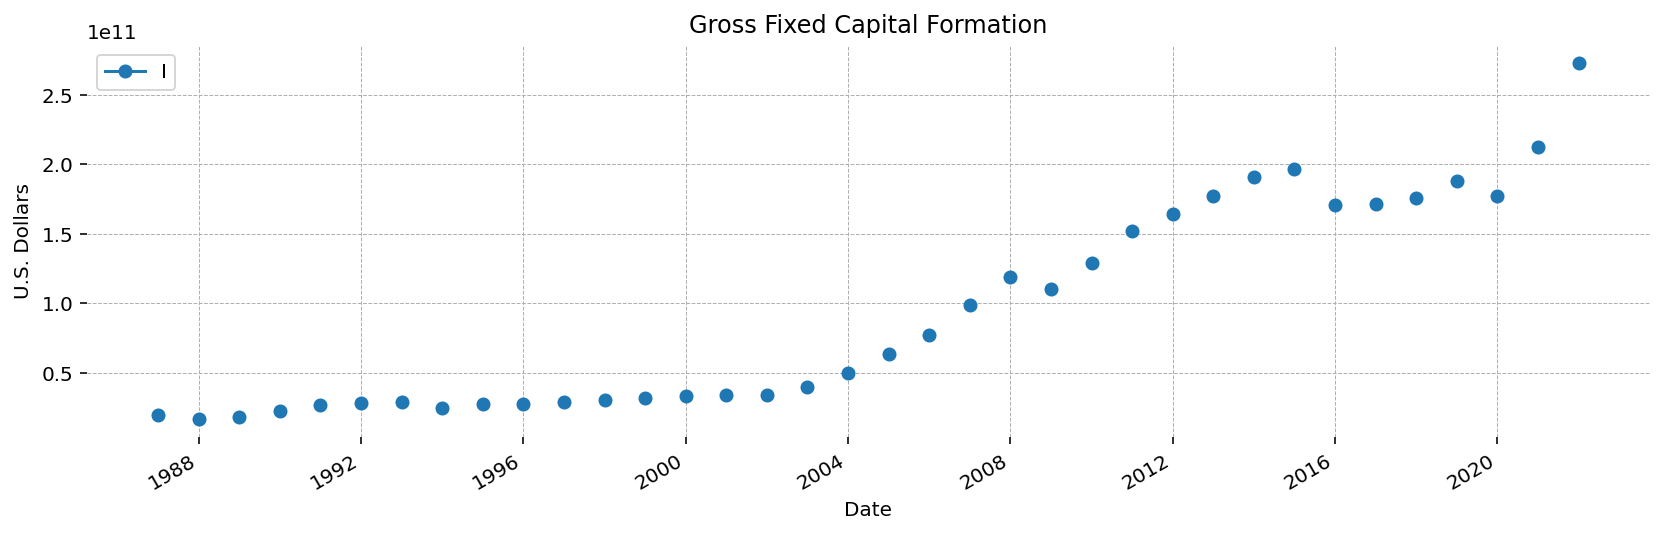

In [144]:
# Create dataframe for investment
df_I = df[['I']].copy()

# Plot the I variable over time with markers at data points
df_I.plot(marker='o')

# Set plot labels and title
plt.title('Gross Fixed Capital Formation')
plt.xlabel('Date')
plt.ylabel('U.S. Dollars')

# Display the plot
plt.show()

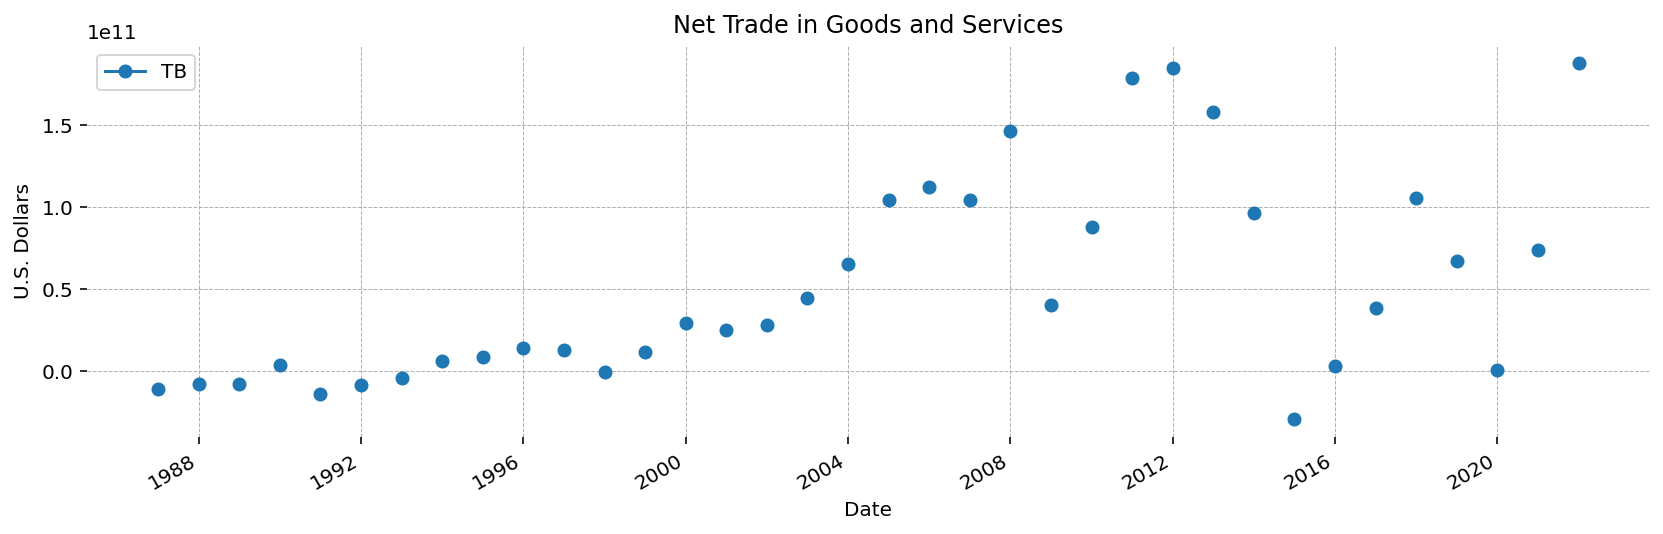

In [145]:
# Create dataframe for the trade balance
df_TB = df[['TB']].copy()

# Plot the 'C' variable over time with markers at data points
df_TB.plot(marker='o')

# Set plot labels and title
plt.title('Net Trade in Goods and Services')
plt.xlabel('Date')
plt.ylabel('U.S. Dollars')

# Display the plot
plt.show()

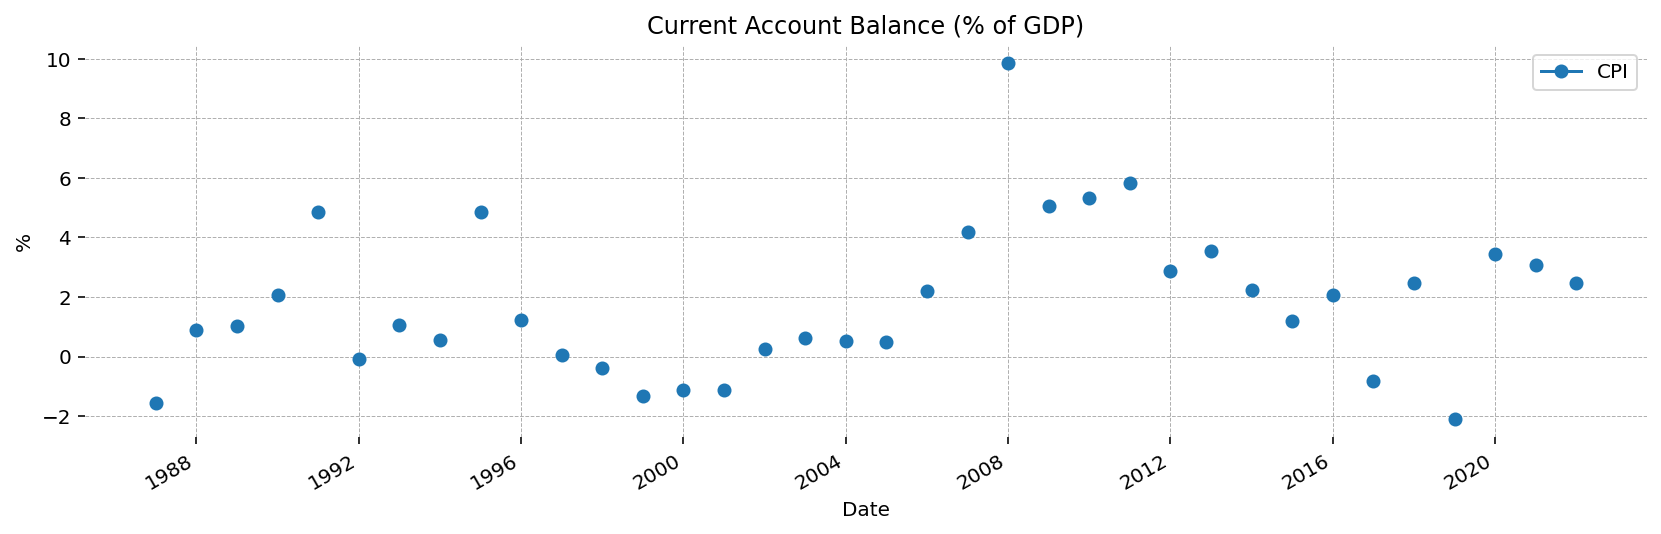

In [146]:
# Create dataframe for the current account
df_CA = df[['CA']].copy()

# Plot the 'C' variable over time with markers at data points
df_CPI.plot(marker='o')

# Set plot labels and title
plt.title('Current Account Balance (% of GDP)')
plt.xlabel('Date')
plt.ylabel('%')

# Display the plot
plt.show()

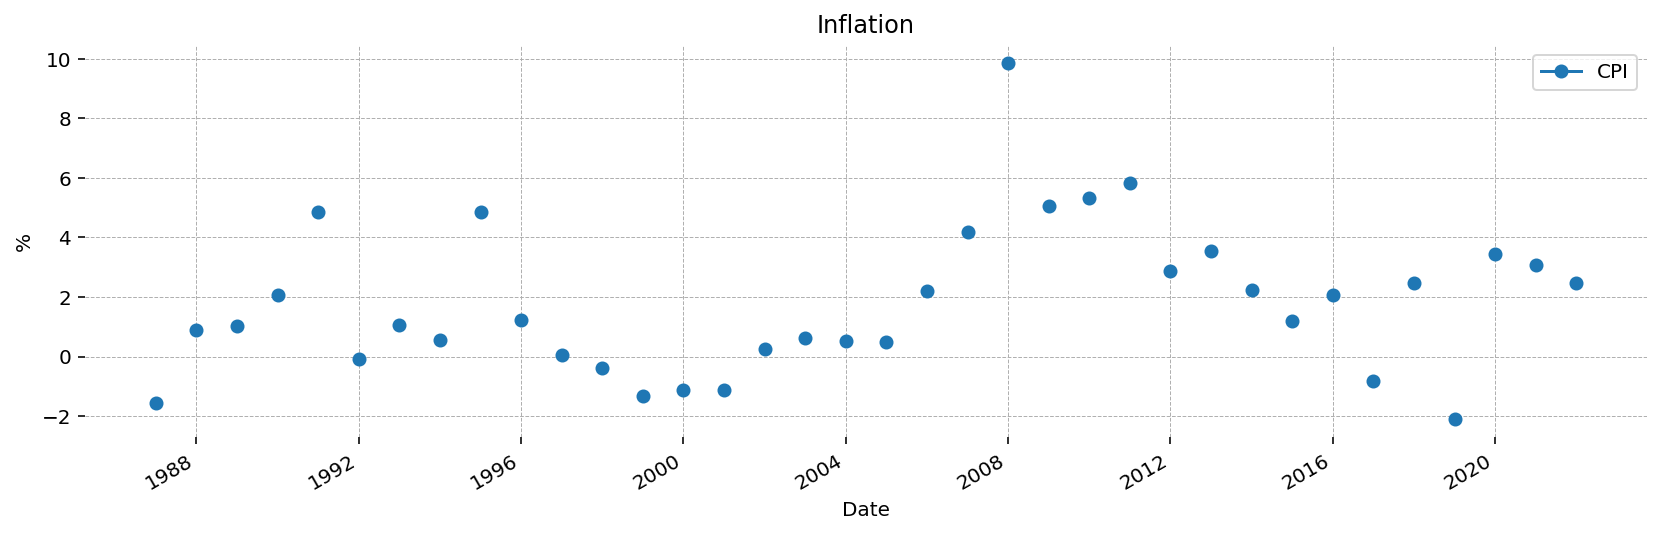

In [147]:
# Create dataframe for inflation
df_CPI = df[['CPI']].copy()

# Plot the 'C' variable over time with markers at data points
df_CPI.plot(marker='o')

# Set plot labels and title
plt.title('Inflation')
plt.xlabel('Date')
plt.ylabel('%')

# Display the plot
plt.show()

#### Other Data

Hours worked (N), wages (w), long term government bond yields (R), and short-term interest rates (r) are manually imported due to challenges associated with obtaining the data from official sources. Despite attempts to access the General Statistics Authority's API for hours worked and wages, the tool was not functional. The long-term government bond data (R) was not available in a tabular format and as a result, scraping was impractical. In addition, short-term interest ratedata was only accessible by downloading the table directly from the Saudi Central Bank's website.

In [148]:
# Import data and format for each dataset
N_data = {
    '2016 / Q2': [38.96775504],
    '2016 / Q3': [38.57034481],
    '2016 / Q4': [38.75315665],
    '2017 / Q1': [39.09336699],
    '2017 / Q2': [38.85986074],
    '2017 / Q3': [38.9159003],
    '2017 / Q4': [39.58174661],
    '2018 / Q1': [38.64750733],
    '2018 / Q2': [38.80551713],
    '2019 / Q1': [38.94281089],
    '2019 / Q2': [38.43955095],
    '2019 / Q3': [38.17616634],
    '2019 / Q4': [37.88810263],
    '2020 / Q1': [38.35162171],
    '2020 / Q2': [39.31892759],
    '2020 / Q3': [39.65375889],
    '2020 / Q4': [40.16204173],
    '2021 / Q1': [39.01231081],
    '2021 / Q2': [38.43177217],
    '2021 / Q3': [39.30209818],
    '2021 / Q4': [40.29776716],
    '2022 / Q1': [39.84260952],
    '2022 / Q2': [40.12209799],
    '2022 / Q3': [40.72582419],
    '2022 / Q4': [40.11837913],
    '2023 / Q1': [40.01679873],
    '2023 / Q2': [40.35208325]
}
w_data = {
    '2016 / Q2': [10462.10642],
    '2016 / Q3': [9712.357822],
    '2016 / Q4': [10227.10574],
    '2017 / Q1': [9884.23959],
    '2017 / Q2': [9910.831884],
    '2017 / Q3': [10011.63187],
    '2017 / Q4': [9939.325367],
    '2018 / Q1': [10088.82327],
    '2018 / Q2': [10237.6998],
    '2019 / Q1': [10299.10765],
    '2019 / Q2': [10341.84075],
    '2019 / Q3': [10273.0132],
    '2019 / Q4': [10256.36242],
    '2020 / Q1': [10302.70319],
    '2020 / Q2': [9970.297977],
    '2020 / Q3': [9971.056802],
    '2020 / Q4': [10539.69348],
    '2021 / Q1': [10599.8789],
    '2021 / Q2': [10491.248],
    '2021 / Q3': [10474.12402],
    '2021 / Q4': [10185.54969],
    '2022 / Q1': [9811.756473],
    '2022 / Q2': [10430.41218],
    '2022 / Q3': [9583.143722],
    '2022 / Q4': [9701.453807],
    '2023 / Q1': [9893.242042],
    '2023 / Q2': [9923.604891]
}
Rt_data = {
    '2001 / Q1': [5.74],
    '2001 / Q2': [6.79],
    '2001 / Q3': [6.36],
    '2002 / Q1': [3.5],
    '2002 / Q2': [5.05],
    '2002 / Q3': [5.74],
    '2002 / Q4': [6.36],
    '2003 / Q1': [2.69],
    '2003 / Q2': [3.72],
    '2003 / Q3': [4.36],
    '2003 / Q4': [3.6],
    '2004 / Q1': [2.75],
    '2004 / Q2': [2.75],
    '2004 / Q3': [2.0],
    '2004 / Q4': [5.194],
    '2005 / Q1': [5.25],
    '2005 / Q2': [5.25],
    '2005 / Q3': [4.625],
    '2005 / Q4': [4.625],
    '2006 / Q1': [5.25],
    '2006 / Q2': [5.25],
    '2006 / Q3': [5.5],
    '2006 / Q4': [5.5],
    '2007 / Q1': [5.0],
    '2007 / Q2': [5.0],
    '2007 / Q3': [5.0],
    '2007 / Q4': [5.0]
}

rt_data = {
    '2007 / Q1': [5.086876667],
    '2007 / Q2': [5.044793333],
    '2007 / Q3': [5.05125],
    '2007 / Q4': [4.4375],
    '2008 / Q1': [2.750729167],
    '2008 / Q2': [2.497683913],
    '2008 / Q3': [4.017900408],
    '2008 / Q4': [3.872003205],
    '2009 / Q1': [1.357266144],
    '2009 / Q2': [0.889771282],
    '2009 / Q3': [0.647518846],
    '2009 / Q4': [0.750644872],
    '2010 / Q1': [0.760368333],
    '2010 / Q2': [0.726157867],
    '2010 / Q3': [0.721976538],
    '2010 / Q4': [0.734948077],
    '2011 / Q1': [0.75],
    '2011 / Q2': [0.714846092],
    '2011 / Q3': [0.604153205],
    '2011 / Q4': [0.708867179],
    '2012 / Q1': [0.832301795],
    '2012 / Q2': [0.906203974],
    '2012 / Q3': [0.95003641],
    '2012 / Q4': [0.976722821],
    '2013 / Q1': [0.97589924],
    '2013 / Q2': [0.95818661],
    '2013 / Q3': [0.958199266],
    '2013 / Q4': [0.920658071],
    '2014 / Q1': [0.953805303],
    '2014 / Q2': [0.951747835],
    '2014 / Q3': [0.945912698],
    '2014 / Q4': [0.891596032],
    '2015 / Q1': [0.8162],
    '2015 / Q2': [0.773933333],
    '2015 / Q3': [0.828233333],
    '2015 / Q4': [1.1004],
    '2016 / Q1': [1.715762063],
    '2016 / Q2': [2.072859778],
    '2016 / Q3': [2.280601229],
    '2016 / Q4': [2.195467532],
    '2017 / Q1': [1.886523287],
    '2017 / Q2': [1.741016667],
    '2017 / Q3': [1.794616026],
    '2017 / Q4': [1.82451746],
    '2018 / Q1': [1.9542],
    '2018 / Q2': [2.414533333],
    '2018 / Q3': [2.6192],
    '2018 / Q4': [2.815995514],
    '2019 / Q1': [2.934282911],
    '2019 / Q2': [2.821566807],
    '2019 / Q3': [2.513837534],
    '2019 / Q4': [2.257692993],
    '2020 / Q1': [1.886206605],
    '2020 / Q2': [1.127925385],
    '2020 / Q3': [0.916],
    '2020 / Q4': [0.839034731],
    '2021 / Q1': [0.807223763],
    '2021 / Q2': [0.793675606],
    '2021 / Q3': [0.796229903],
    '2021 / Q4': [0.842836559],
    '2022 / Q1': [1.364613437],
    '2022 / Q2': [2.714606047],
    '2022 / Q3': [3.140852573],
    '2022 / Q4': [5.281579513],
    '2023 / Q1': [5.494883633],
    '2023 / Q2': [5.830097591],
    '2023 / Q3': [6.088936188],
}

In [149]:
# Create a DataFrame 'df_N' from the 'N_data' dictionary
df_N1 = pd.DataFrame(N_data)

# Transpose the DataFrame to have years as columns and quarters as rows
df_N1 = df_N1.transpose()

# Rename the columns to 'N'
df_N1.columns = ['N']

# Convert the index (containing year and quarter) to datetime format
df_N1.index = pd.to_datetime(df_N1.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))

# Set the index name to 'Date'
df_N1.index.name = 'Date'

# Display the first few rows of the DataFrame
df_N1.head()

N
Date                 
2016-04-01  38.967755
2016-07-01  38.570345
2016-10-01  38.753157
2017-01-01  39.093367
2017-04-01  38.859861

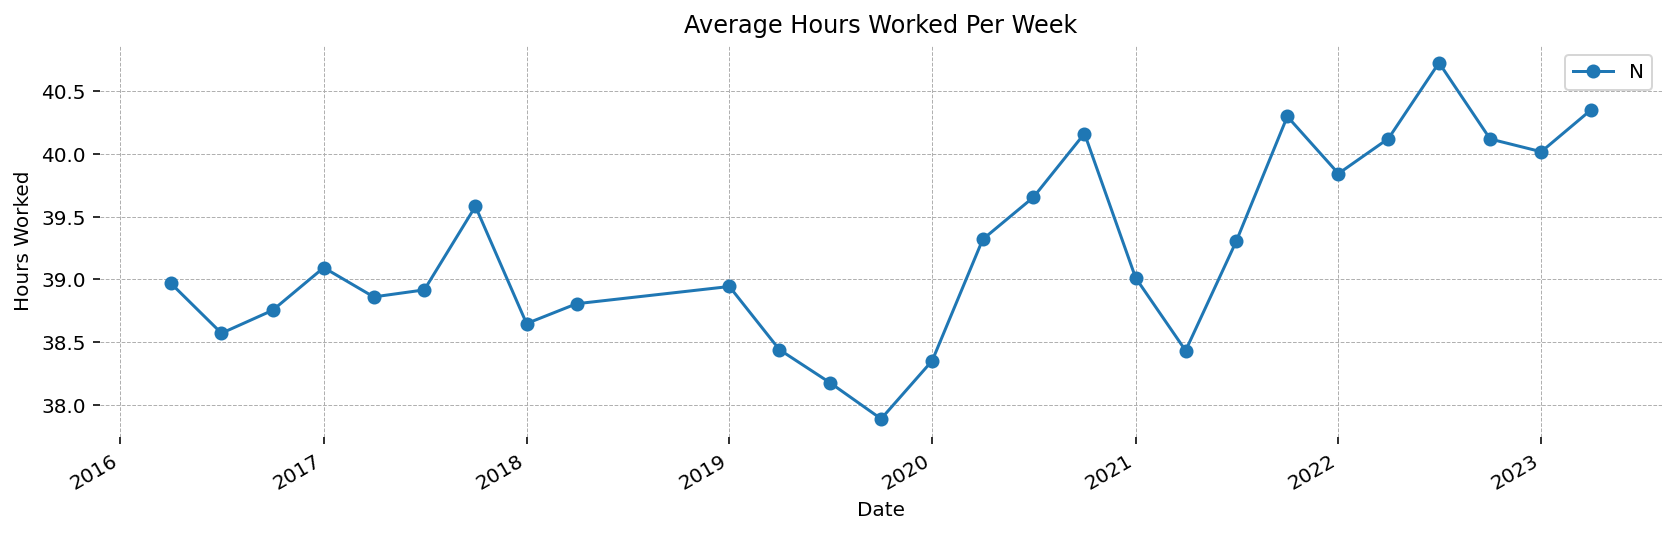

In [150]:
# Plot the 'N' variable over time with markers at data points
df_N1.plot(marker='o')

plt.title('Average Hours Worked Per Week')
plt.xlabel('Date')
plt.ylabel('Hours Worked')

# Display the plot
plt.show()

Average hours worked (N) is initially measured in hours per week. To align with the decision-making process of households in the RBC model, we transform this variable to represent hours per quarter. This conversion is achieved by multiplying the original series by 13, considering the typical number of weeks in a quarter.

In [151]:
# Calculate hours worked per quarter
df_N = df_N1 * 13

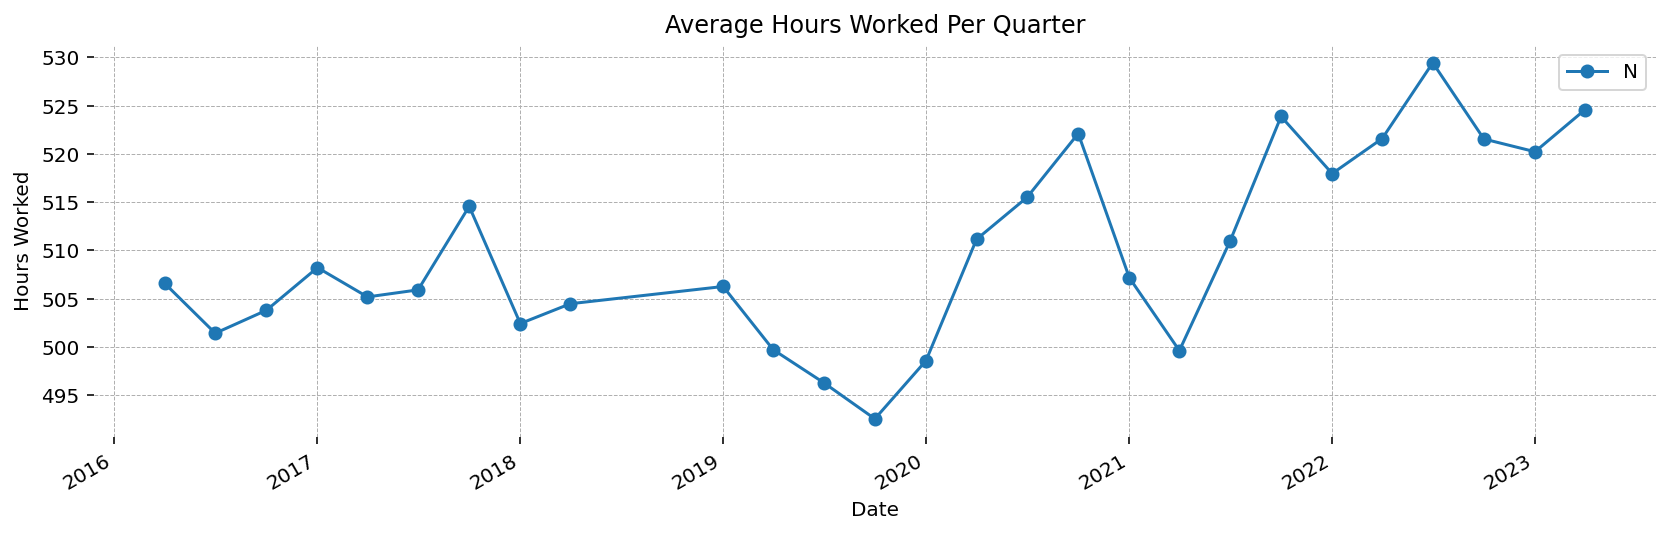

In [152]:
# Plot variable again
df_N.plot(marker='o')
plt.title('Average Hours Worked Per Quarter')
plt.xlabel('Date')
plt.ylabel('Hours Worked')

# Display the plot
plt.show()

In [153]:
# Create a DataFrame df_w from a dictionary w_data
df_w1 = pd.DataFrame(w_data)

# Transpose the DataFrame, swapping rows and columns
df_w1 = df_w1.transpose()

# Rename the columns to 'w'
df_w1.columns = ['w']

# Convert the index to a datetime format by manipulating the quarters into months
df_w1.index = pd.to_datetime(df_w1.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))

# Set the name of the index to 'Date'
df_w1.index.name = 'Date'

# Display the first few rows of the resulting DataFrame
df_w1.head()

w
Date                    
2016-04-01  10462.106420
2016-07-01   9712.357822
2016-10-01  10227.105740
2017-01-01   9884.239590
2017-04-01   9910.831884

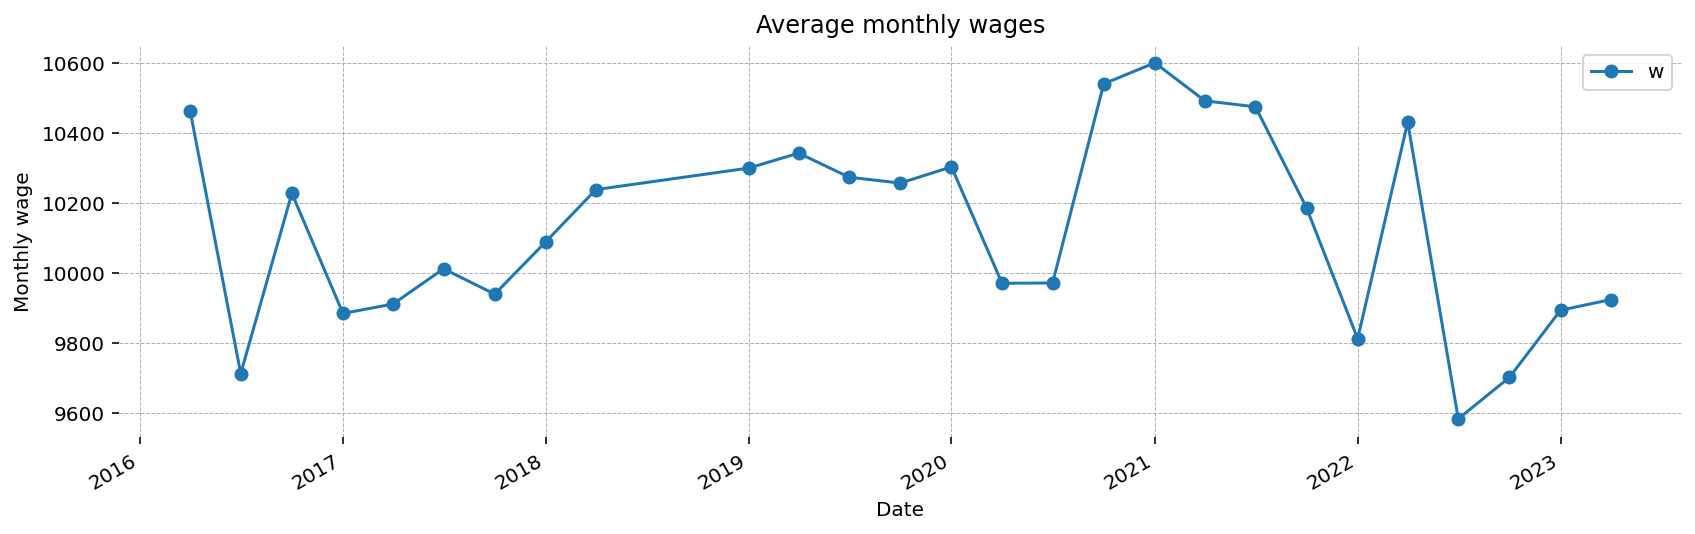

In [154]:
# Plot variable again
df_w1.plot(marker='o')
plt.title('Average monthly wages')
plt.xlabel('Date')
plt.ylabel('Monthly wage')

# Display the plot
plt.show()

Average wages (w) are initially measured on a monthly basis. To ensure consistency with the transformation to hours worked (N), we transform this variable to represent average wages per quarter. This conversion is achieved by maintaining the total income over the quarter and distributing it evenly across the three months, considering the typical number of months in a quarter.

In [155]:
# For consistency, calculate average wages earned per quarter
df_w = df_w1 * 3

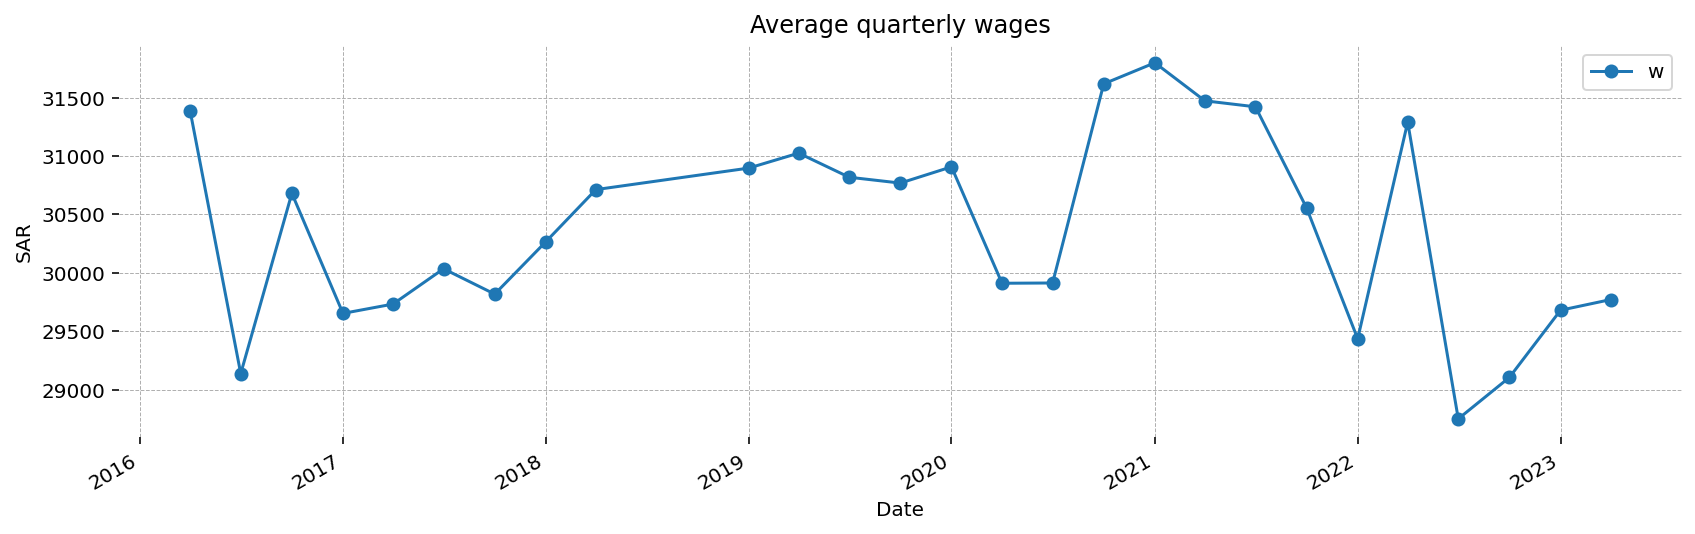

In [156]:
# Plot variable again
df_w.plot(marker='o')
plt.title('Average quarterly wages')
plt.xlabel('Date')
plt.ylabel('SAR')

# Display the plot
plt.show()

In [157]:
# Create a DataFrame df_Rt from a dictionary Rt_data
df_Rt = pd.DataFrame(Rt_data)

# Transpose the DataFrame, swapping rows and columns
df_Rt = df_Rt.transpose()

# Rename the columns to 'Rt'
df_Rt.columns = ['Rt']

# Convert the index to a datetime format by manipulating the quarters into months
df_Rt.index = pd.to_datetime(df_Rt.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))

# Set the name of the index to 'Date'
df_Rt.index.name = 'Date'

# Display the first few rows of the resulting DataFrame
df_Rt.head()

Rt
Date            
2001-01-01  5.74
2001-04-01  6.79
2001-07-01  6.36
2002-01-01  3.50
2002-04-01  5.05

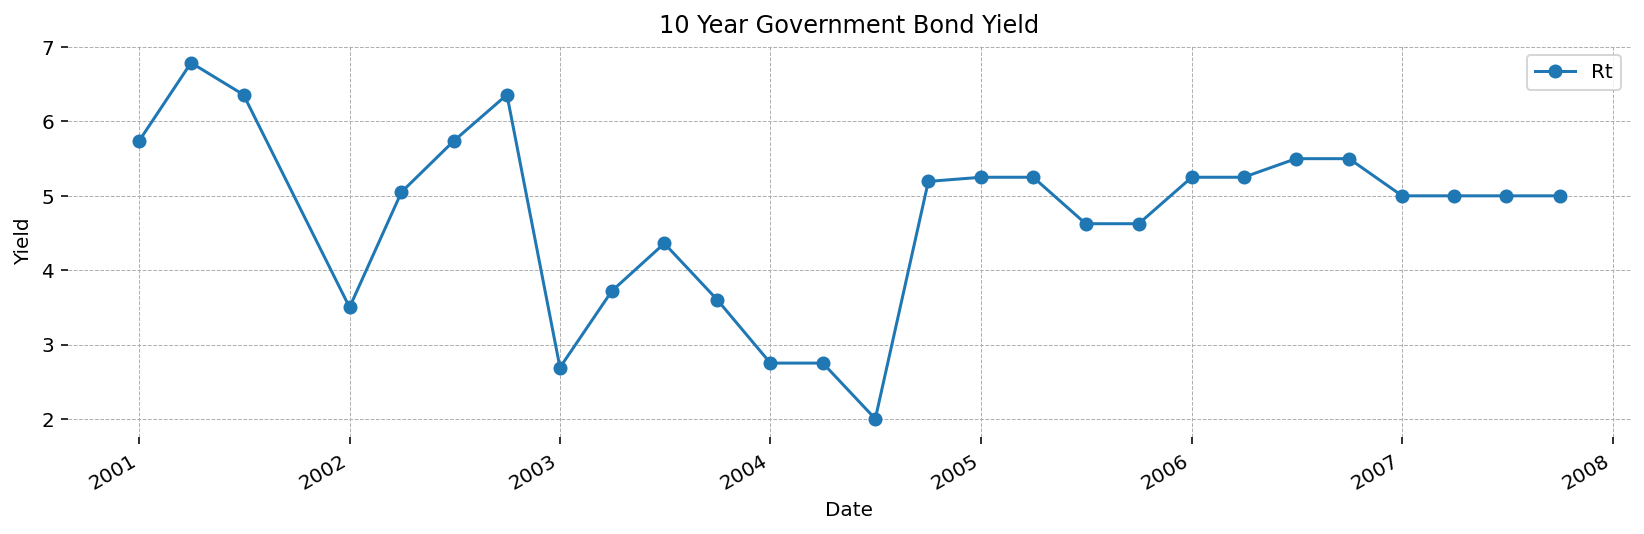

In [158]:
df_Rt.plot(marker='o')
plt.title('10 Year Government Bond Yield')
plt.xlabel('Date')
plt.ylabel('Yield')

# Display the plot
plt.show()

In [159]:
# Create a DataFrame df_rt from a dictionary rt_data
df_rt = pd.DataFrame(rt_data)

# Transpose the DataFrame, swapping rows and columns
df_rt = df_rt.transpose()

# Rename the columns to 'rt'
df_rt.columns = ['rt']

# Convert the index to a datetime format by manipulating the quarters into months
df_rt.index = pd.to_datetime(df_rt.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))

# Set the name of the index to 'Date'
df_rt.index.name = 'Date'

# Display the first and last few rows of the resulting DataFrame
df_rt.head()
df_rt.tail()

rt
Date                
2022-07-01  3.140853
2022-10-01  5.281580
2023-01-01  5.494884
2023-04-01  5.830098
2023-07-01  6.088936

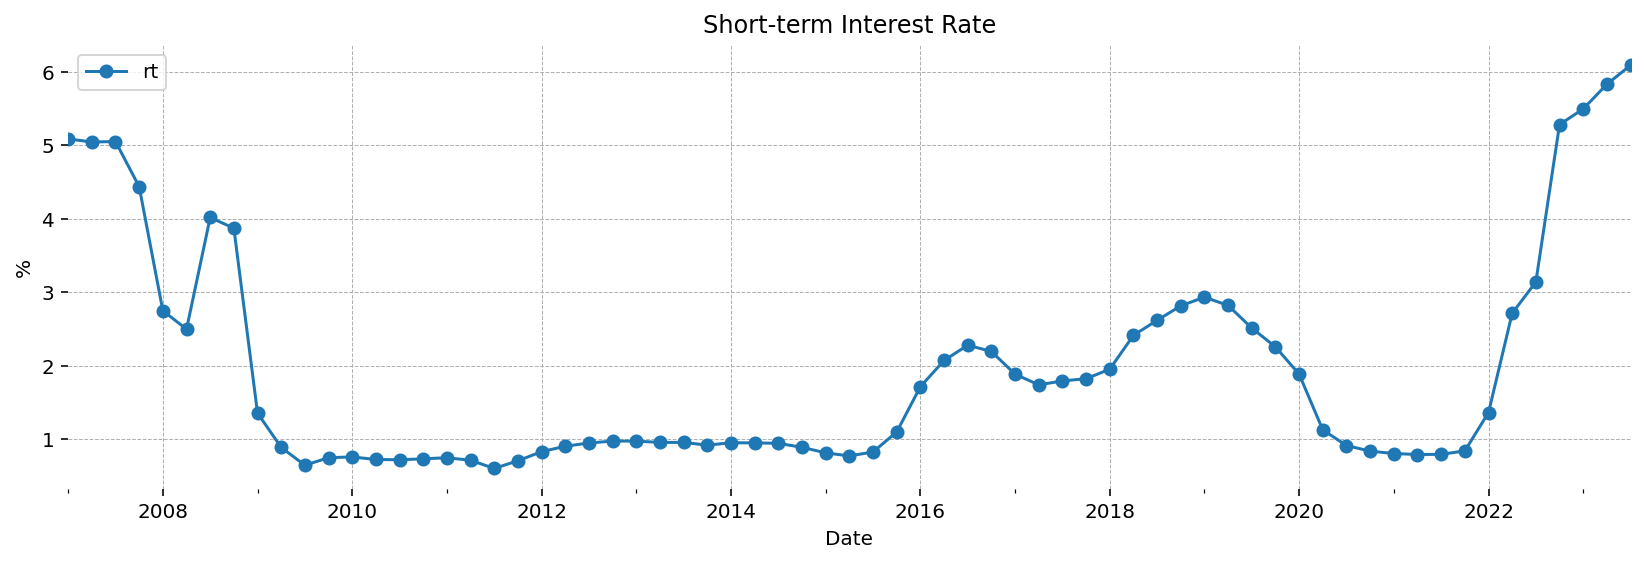

In [160]:
df_rt.plot(marker='o')
plt.title('Short-term Interest Rate')
plt.xlabel('Date')
plt.ylabel('%')

# Display the plot
plt.show()

In [161]:
dataframes = [df_N1, df_w1, df_Rt, df_rt]

In [162]:
# Merge dataframes 
merged_df = df_N.join(df_w, how='outer').join(df_Rt, how='outer').join(df_rt, how='outer')

In [163]:
# View merged data
print(merged_df.head())
print(merged_df.tail())

             N   w    Rt  rt
Date                        
2001-01-01 NaN NaN  5.74 NaN
2001-04-01 NaN NaN  6.79 NaN
2001-07-01 NaN NaN  6.36 NaN
2002-01-01 NaN NaN  3.50 NaN
2002-04-01 NaN NaN  5.05 NaN
                     N             w  Rt        rt
Date                                              
2022-07-01  529.435714  28749.431166 NaN  3.140853
2022-10-01  521.538929  29104.361421 NaN  5.281580
2023-01-01  520.218383  29679.726126 NaN  5.494884
2023-04-01  524.577082  29770.814673 NaN  5.830098
2023-07-01         NaN           NaN NaN  6.088936


In [164]:
# Print specific columns of the merged DataFrame
print(merged_df['N'])
print(merged_df['w'])
print(merged_df['Rt'])
print(merged_df['rt'])

# Print specific columns of the merged DataFrame with NaN values dropped
print(merged_df['N'].dropna())
print(merged_df['w'].dropna())
print(merged_df['Rt'].dropna())
print(merged_df['rt'].dropna())

Date
2001-01-01           NaN
2001-04-01           NaN
2001-07-01           NaN
2002-01-01           NaN
2002-04-01           NaN
                 ...    
2022-07-01    529.435714
2022-10-01    521.538929
2023-01-01    520.218383
2023-04-01    524.577082
2023-07-01           NaN
Name: N, Length: 90, dtype: float64
Date
2001-01-01             NaN
2001-04-01             NaN
2001-07-01             NaN
2002-01-01             NaN
2002-04-01             NaN
                  ...     
2022-07-01    28749.431166
2022-10-01    29104.361421
2023-01-01    29679.726126
2023-04-01    29770.814673
2023-07-01             NaN
Name: w, Length: 90, dtype: float64
Date
2001-01-01    5.74
2001-04-01    6.79
2001-07-01    6.36
2002-01-01    3.50
2002-04-01    5.05
              ... 
2022-07-01     NaN
2022-10-01     NaN
2023-01-01     NaN
2023-04-01     NaN
2023-07-01     NaN
Name: Rt, Length: 90, dtype: float64
Date
2001-01-01         NaN
2001-04-01         NaN
2001-07-01         NaN
2002-01-01         Na

In [165]:
# Check two different dataframes 
df.info()
merged_df.info()

df.head()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   C         55 non-null     float64
 2   K         33 non-null     float64
 3   Ex_rate   442 non-null    float64
 4   Oil       9317 non-null   float64
 5   Y_yearly  36 non-null     float64
 6   I         36 non-null     float64
 7   TB        36 non-null     float64
 8   CA        36 non-null     float64
 9   CPI       36 non-null     float64
dtypes: float64(10)
memory usage: 840.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2001-01-01 to 2023-07-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       27 non-null     float64
 1   w       27 non-null     float64
 2   Rt      27 non-null     float64
 3   rt      67 non-null     float64
dtypes: float64(4)
m

N   w    Rt  rt
Date                        
2001-01-01 NaN NaN  5.74 NaN
2001-04-01 NaN NaN  6.79 NaN
2001-07-01 NaN NaN  6.36 NaN
2002-01-01 NaN NaN  3.50 NaN
2002-04-01 NaN NaN  5.05 NaN

In [166]:
# Merge 'df' and 'merged_df' based on their date time index
merged_df_aligned = merged_df.reindex(df.index)
final_df = merged_df_aligned.join(df, how='outer')
final_df.index.name = 'DATE'

In [167]:
final_df.head()

N   w  Rt  rt   Y   C           K  Ex_rate    Oil      Y_yearly  \
DATE                                                                           
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25     3.75    NaN  8.569594e+10   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.13           NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN      NaN  17.98           NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.21           NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.28           NaN   

                       I            TB         CA       CPI  
DATE                                                         
1987-01-01  1.913489e+10 -1.138400e+10 -11.389104 -1.547117  
1987-01-02           NaN           NaN        NaN       NaN  
1987-01-05           NaN           NaN        NaN       NaN  
1987-01-06           NaN           NaN        NaN       NaN  
1987-01-07           NaN           NaN        NaN       NaN

In [168]:
new_order = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'N','Rt', 'K', 'CA', 'CPI', 'Ex_rate', 'Oil']

In [169]:
# Reorder the columns of the DataFrame 'final_df' based on the specified order in the 'new_order' list
final_df = final_df[new_order]

In [170]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   Y_yearly  36 non-null     float64
 2   I         36 non-null     float64
 3   C         55 non-null     float64
 4   TB        36 non-null     float64
 5   rt        67 non-null     float64
 6   w         27 non-null     float64
 7   N         27 non-null     float64
 8   Rt        27 non-null     float64
 9   K         33 non-null     float64
 10  CA        36 non-null     float64
 11  CPI       36 non-null     float64
 12  Ex_rate   442 non-null    float64
 13  Oil       9317 non-null   float64
dtypes: float64(14)
memory usage: 1.1 MB


In [171]:
final_df.head()

Y      Y_yearly             I   C            TB  rt   w   N  Rt  \
DATE                                                                           
1987-01-01 NaN  8.569594e+10  1.913489e+10 NaN -1.138400e+10 NaN NaN NaN NaN   
1987-01-02 NaN           NaN           NaN NaN           NaN NaN NaN NaN NaN   
1987-01-05 NaN           NaN           NaN NaN           NaN NaN NaN NaN NaN   
1987-01-06 NaN           NaN           NaN NaN           NaN NaN NaN NaN NaN   
1987-01-07 NaN           NaN           NaN NaN           NaN NaN NaN NaN NaN   

                     K         CA       CPI  Ex_rate    Oil  
DATE                                                         
1987-01-01  1217826.25 -11.389104 -1.547117     3.75    NaN  
1987-01-02         NaN        NaN       NaN      NaN  18.13  
1987-01-05         NaN        NaN       NaN      NaN  17.98  
1987-01-06         NaN        NaN       NaN      NaN  18.21  
1987-01-07         NaN        NaN       NaN      NaN  18.28

### Visual Inspection of the Imported Data

C:\Users\jessi\AppData\Local\Temp\ipykernel_47164\2336598350.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


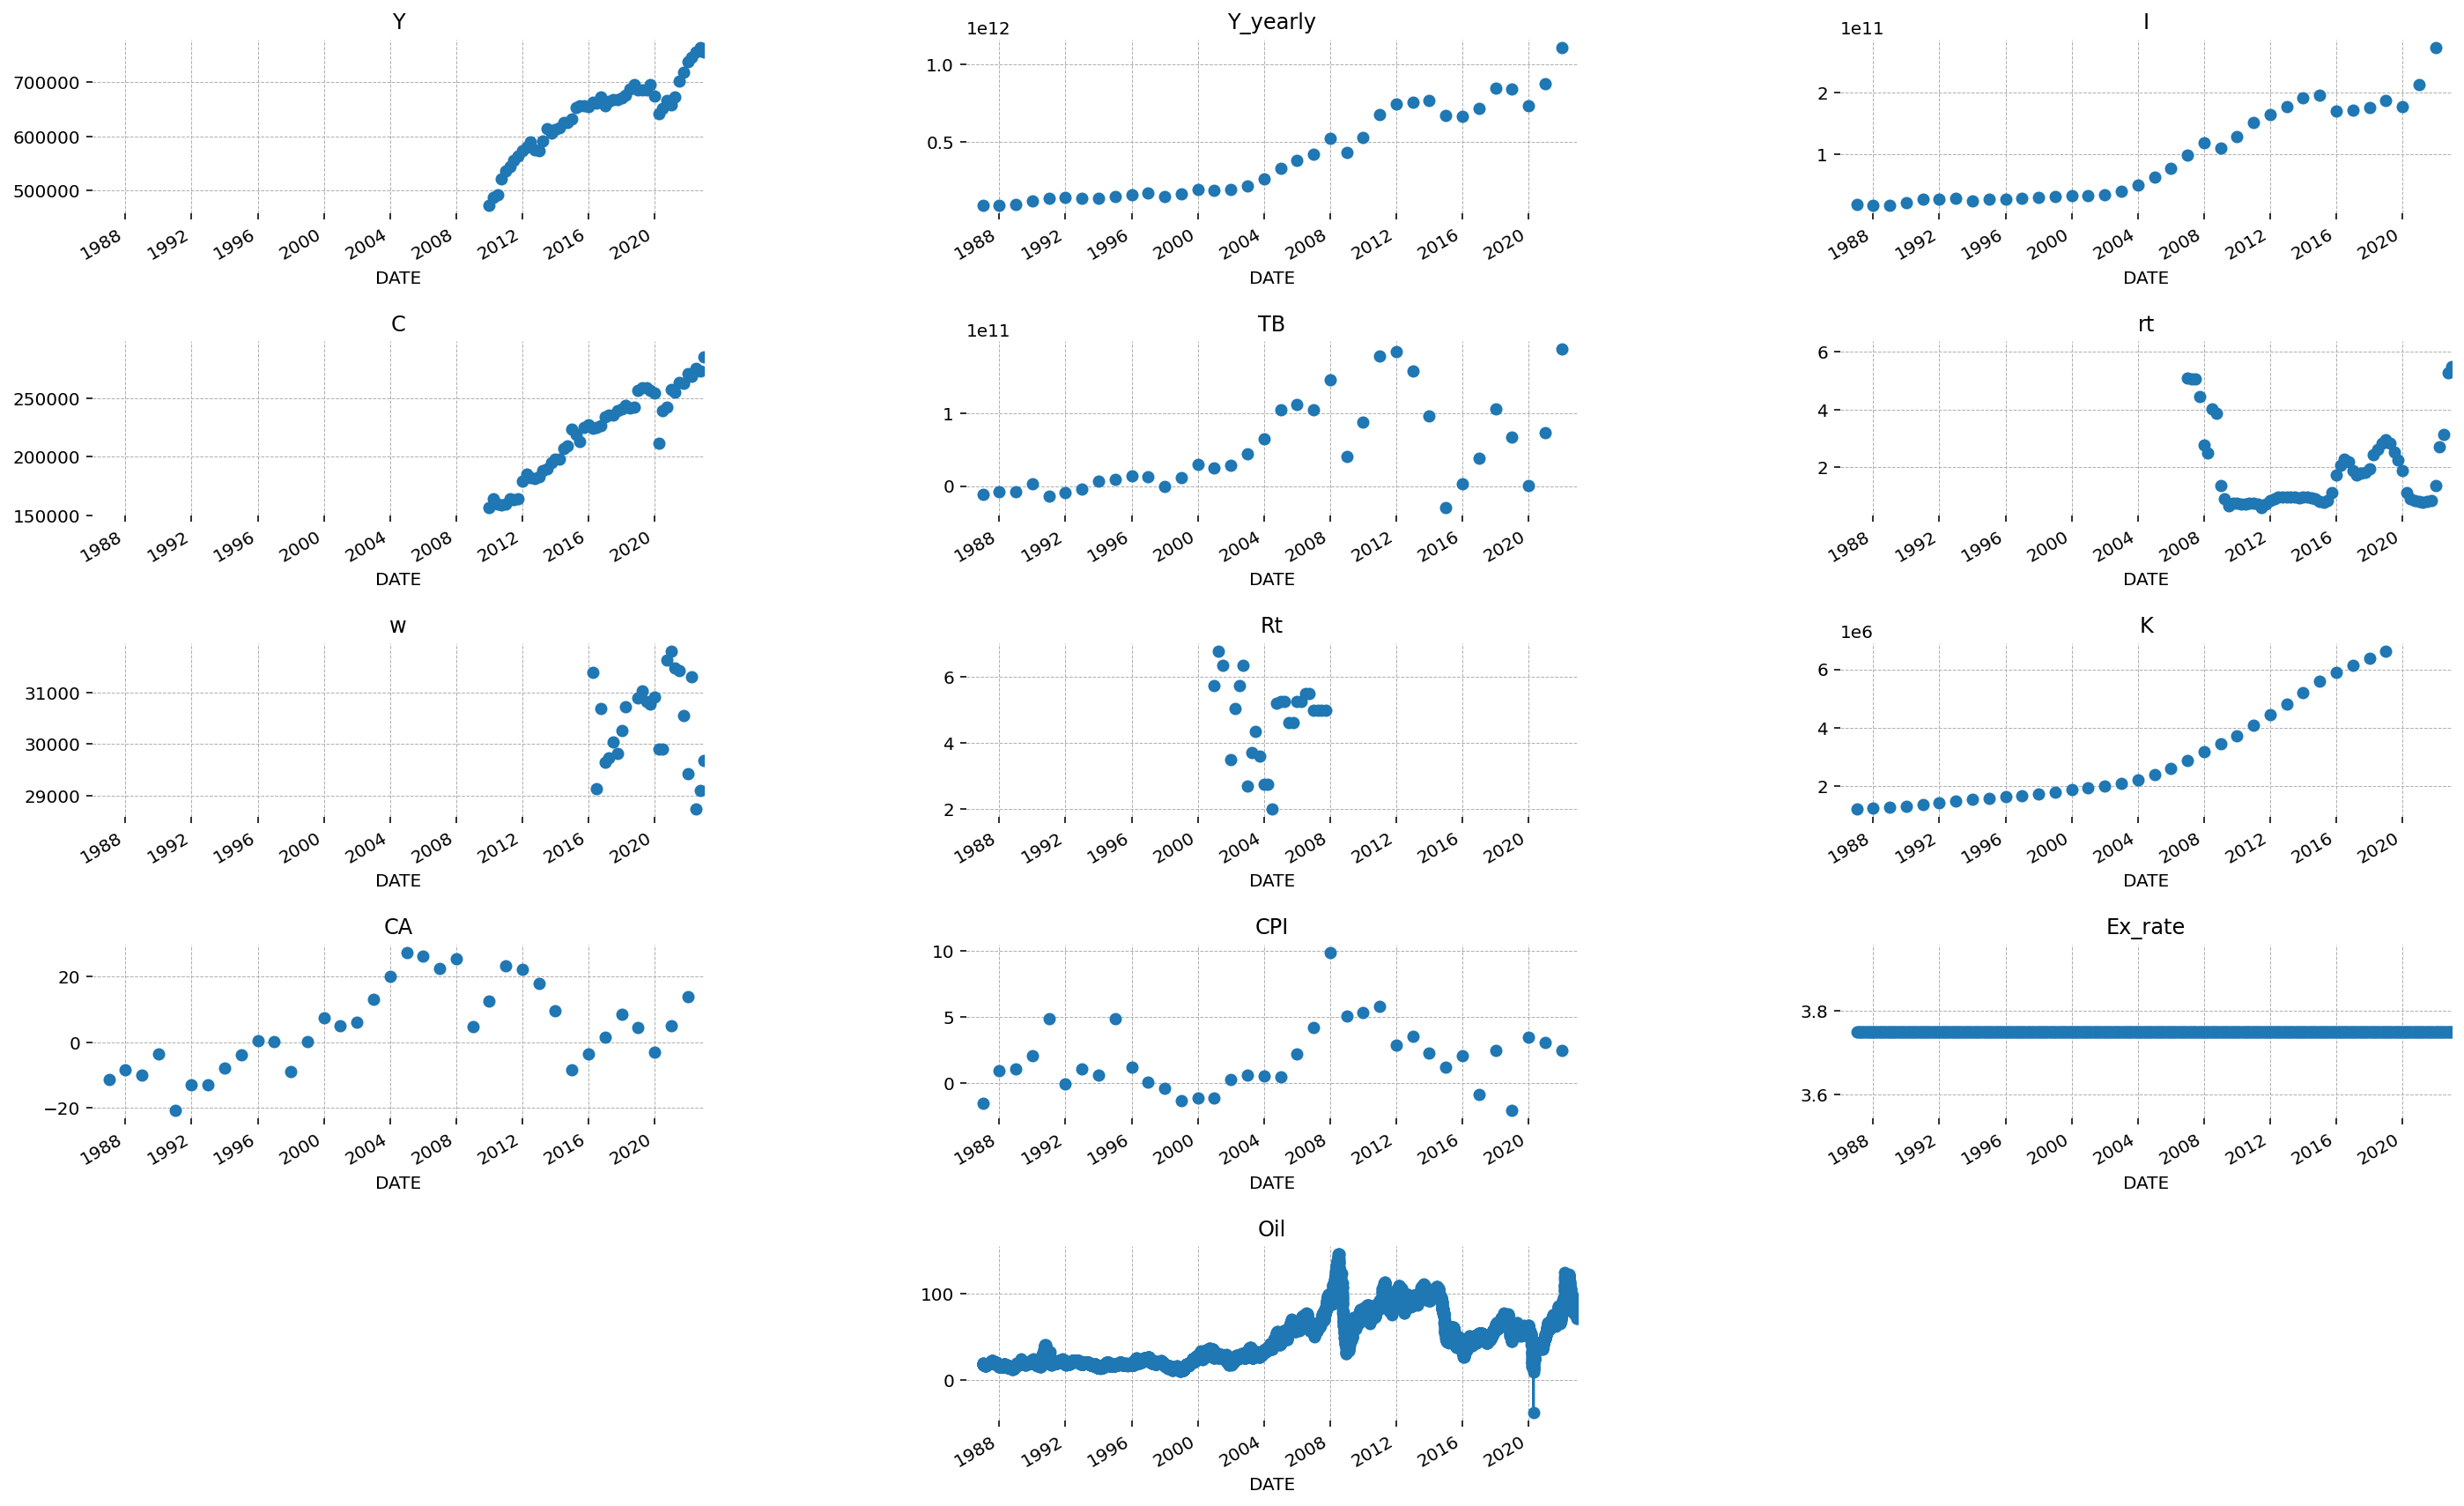

In [172]:
def plot_df(final_df, **plot_kwargs):
    columns_to_plot = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'Rt', 'K', 'CA', 'CPI', 'Ex_rate', 'Oil']
    
    fig = plt.figure(figsize=(24, 16), dpi=144)  # Increased figure size
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(columns_to_plot))

    # Adjusting the layout for better spacing
    gs.update(hspace=5.5, wspace=1.5)  

    for loc, var in zip(plot_locs, columns_to_plot):
        if var in final_df.columns:
            axis = fig.add_subplot(gs[loc])
            final_df[var].plot(ax=axis, **plot_kwargs)
            axis.set_title(var)

            # Set x-axis limits
            axis.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    plt.tight_layout()
    plt.show()

# Assuming 'data' is your dataframe
plot_df(final_df, marker='o')

In the visual representation above, it is apparent that several variables exhibit different frequencies. In the subsequent section, adjustments will be made to standardise all variables to a quarterly frequency, aligning them with the requirements of RBC modeling.


While it may be interesting to inspect the trade balance and current account data, our model assumes a closed economy. Therefore, we will drop these variables from further analysis. In addition, we no longer require annual GDP and simiarily drop this variable.

In [173]:
# Drop TB and CA from dataframe. In addition, drop yearly
final_df = final_df.drop(columns=['Y_yearly','CA', 'TB'])

In [174]:
final_df.head()

Y             I   C  rt   w   N  Rt           K       CPI  \
DATE                                                                     
1987-01-01 NaN  1.913489e+10 NaN NaN NaN NaN NaN  1217826.25 -1.547117   
1987-01-02 NaN           NaN NaN NaN NaN NaN NaN         NaN       NaN   
1987-01-05 NaN           NaN NaN NaN NaN NaN NaN         NaN       NaN   
1987-01-06 NaN           NaN NaN NaN NaN NaN NaN         NaN       NaN   
1987-01-07 NaN           NaN NaN NaN NaN NaN NaN         NaN       NaN   

            Ex_rate    Oil  
DATE                        
1987-01-01     3.75    NaN  
1987-01-02      NaN  18.13  
1987-01-05      NaN  17.98  
1987-01-06      NaN  18.21  
1987-01-07      NaN  18.28

### 2) Frequency Conversion

The table below provides a summary indicating whether frequency adjustments are required for each variable.

| Step | Variable  | Adjustment to Quarterly Data |
|------|-----------|------------|
| 1    | Y         | Not Required                                                                                             |      
| 2    | I         | Done                                                                                                |
| 3    | C         | Not Required                                                                                                                      |
| 4    | rt        | Not Required                                                                                               |
| 5    | w         | Not Required                                                                                                |
| 6    | Rt        | Not Required                                                                                            |
| 7    | K         | Done                                                                                             |                                                                                             |
| 8   | CPI       | Done                                                                                    |
| 9   | Ex_Rate   | Done                                                                                         |
| 10   | Oil       | Done                                                                                    |


In [175]:
final_df_copy = final_df
final_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Y        55 non-null     float64
 1   I        36 non-null     float64
 2   C        55 non-null     float64
 3   rt       67 non-null     float64
 4   w        27 non-null     float64
 5   N        27 non-null     float64
 6   Rt       27 non-null     float64
 7   K        33 non-null     float64
 8   CPI      36 non-null     float64
 9   Ex_rate  442 non-null    float64
 10  Oil      9317 non-null   float64
dtypes: float64(11)
memory usage: 916.4 KB


##### Variable 1: Investment 

Disaggregate the investment data from yearly to quarterly frequency.

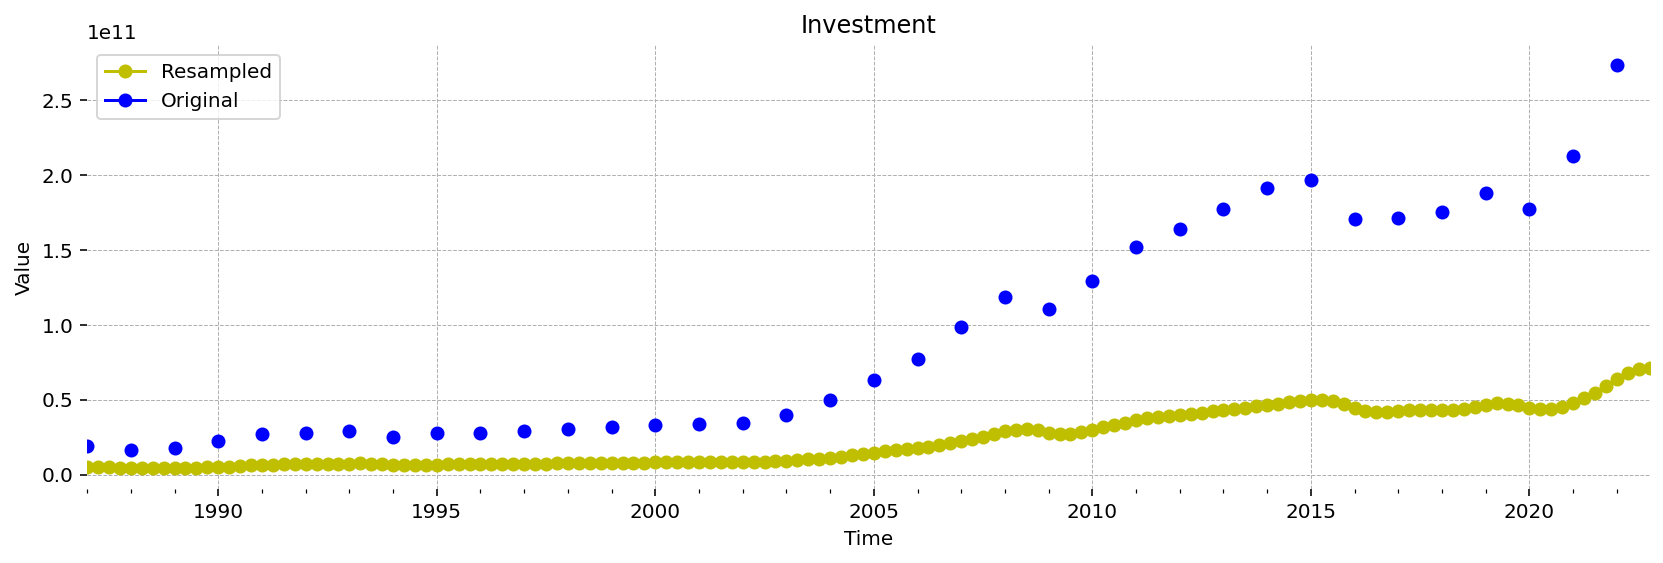

1987-01-01    4.932778e+09
1987-04-01    4.873156e+09
1987-07-01    4.753910e+09
1987-10-01    4.575042e+09
1988-01-01    4.336551e+09
                  ...     
2021-10-01    5.901167e+10
2022-01-01    6.395704e+10
2022-04-01    6.766607e+10
2022-07-01    7.013876e+10
2022-10-01    7.137510e+10
Freq: QS-OCT, Name: I, Length: 144, dtype: float64


In [177]:
# Create a disaggregate version of 'I' to derive quarterly data from a yearly dataframe
I_resample = final_df['I'].dropna().copy()

# Disaggregate the series to quarterly frequency using the sum as the aggregation function
I_resample = disaggregate_series(I_resample, target_freq='QS', agg_func='sum')

# Plot the resampled data
I_resample.resample('QS').asfreq().plot(label='Resampled', marker='o', color='y')

# Plot the original data
final_df['I'].dropna().resample('QS').asfreq().plot(label='Original', marker='o', color='b')

# Add legend and display the plot
plt.legend()
plt.title("Investment")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

#Display the resampled series
print(I_resample)

The graph indicates an unsuccessful sampling method, which could be attributed to the trend that emerges from the 2000s onward. To ensure accurate estimation of quarterly data, it is crucial to address this issue and ensure the resampling properly fits the data.

We therefore employ a second method, which involves using a SARIMAX model with a quadratic trend to fit the data to the time series.

In [178]:
# Select the 'I' column from the DataFrame 'final_df', drop any rows with missing values, and create a copy
I_quarterly = final_df[['I']].dropna().copy()

# Sort the index of the DataFrame 'I_quarterly' in ascending order
I_quarterly = I_quarterly.sort_index()

# Display the first few rows of the sorted DataFrame
I_quarterly.head()

I
DATE                    
1987-01-01  1.913489e+10
1988-01-01  1.670377e+10
1989-01-01  1.772828e+10
1990-01-01  2.222981e+10
1991-01-01  2.683051e+10

In [179]:
# We set the trend to 'ctt' which means quadratic trend as this I appears to increase exponentially
# Define the SARIMAX model with a quadratic trend
mod = sm.tsa.SARIMAX(I_quarterly, order=(1, 0, 0), trend='ctt')

# Fit the SARIMAX model to the data
res = mod.fit(method='nm', maxiter=10_000)

C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 24.658679
         Iterations: 286
         Function evaluations: 599


Procced desipte the warning as our data is correctly assumed to be annually.

In [180]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      I   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -887.712
Date:                Wed, 03 Jan 2024   AIC                           1785.425
Time:                        16:35:44   BIC                           1793.343
Sample:                    01-01-1987   HQIC                          1788.188
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.22e+09   6.14e-14   6.88e+22      0.000    4.22e+09    4.22e+09
drift      -8.541e+06    1.9e-12  -4.49e+18      0.000   -8.54e+06   -8.54e+06
trend.2     5.524e+07   6.03e-11   9.17e+17      0.000    5.52e+07    5.52e+07
ar.L1          0.7700      0.011     67.508      0.000       0.748       0.792
sigma2      1.496e+20    5.3e-26   2.82e+45      0.000     1.5e+20     1.5e+20
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):                 8.46
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):              52.43   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+62. Standard errors may be unstable.
"""

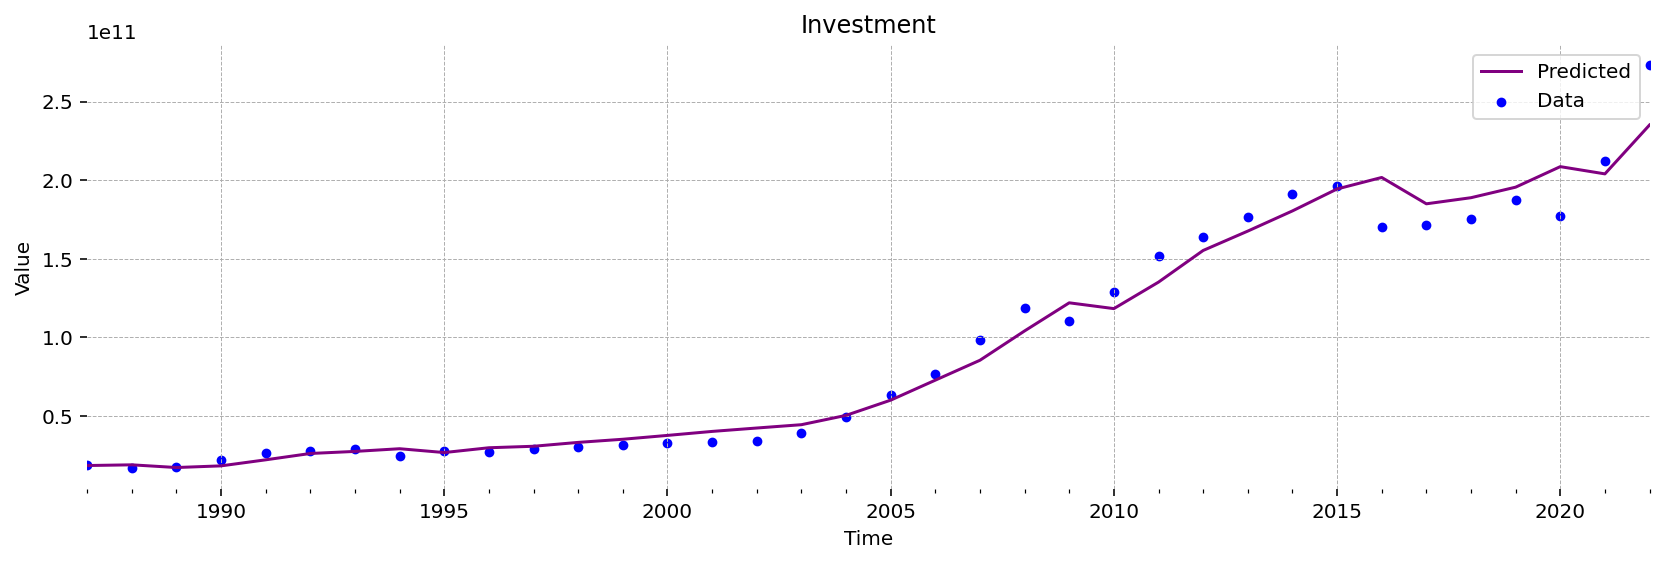

In [182]:
# Plotting both the predicted trend and real data on a quarterly scale

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the predicted values using the fitted SARIMAX model
res.predict().plot(label='Predicted', ax=ax, c='purple')

# Scatter plot the actual data points
ax.scatter(I_quarterly.index, I_quarterly.values, s=15, c='b', label='Data')

# Display the legend
ax.legend()
plt.legend()
plt.title("Investment")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Show the plot
plt.show()

In [184]:
# Make predictions for quarterly data using the fitted SARIMAX model

# Quarterly periods based on the resampled index
quarterly_periods = I_resample.index

# Get predictions for the specified quarterly periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean

# Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([I_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])

# Sort the combined data by the index (Date)
I_predict.sort_index(inplace=True)

# Forward-fill NAs to fill any gaps in the predicted values
I_predict.ffill(inplace=True)

# Display the combined data with predictions
print(I_predict)

                       0   I
1987-01-01  4.932778e+09 NaN
1987-01-01  4.932778e+09 NaN
1987-04-01  4.932778e+09 NaN
1987-04-01  4.873156e+09 NaN
1987-07-01  4.753910e+09 NaN
...                  ...  ..
2022-04-01  6.766607e+10 NaN
2022-07-01  6.766607e+10 NaN
2022-07-01  7.013876e+10 NaN
2022-10-01  7.137510e+10 NaN
2022-10-01  7.137510e+10 NaN

[288 rows x 2 columns]


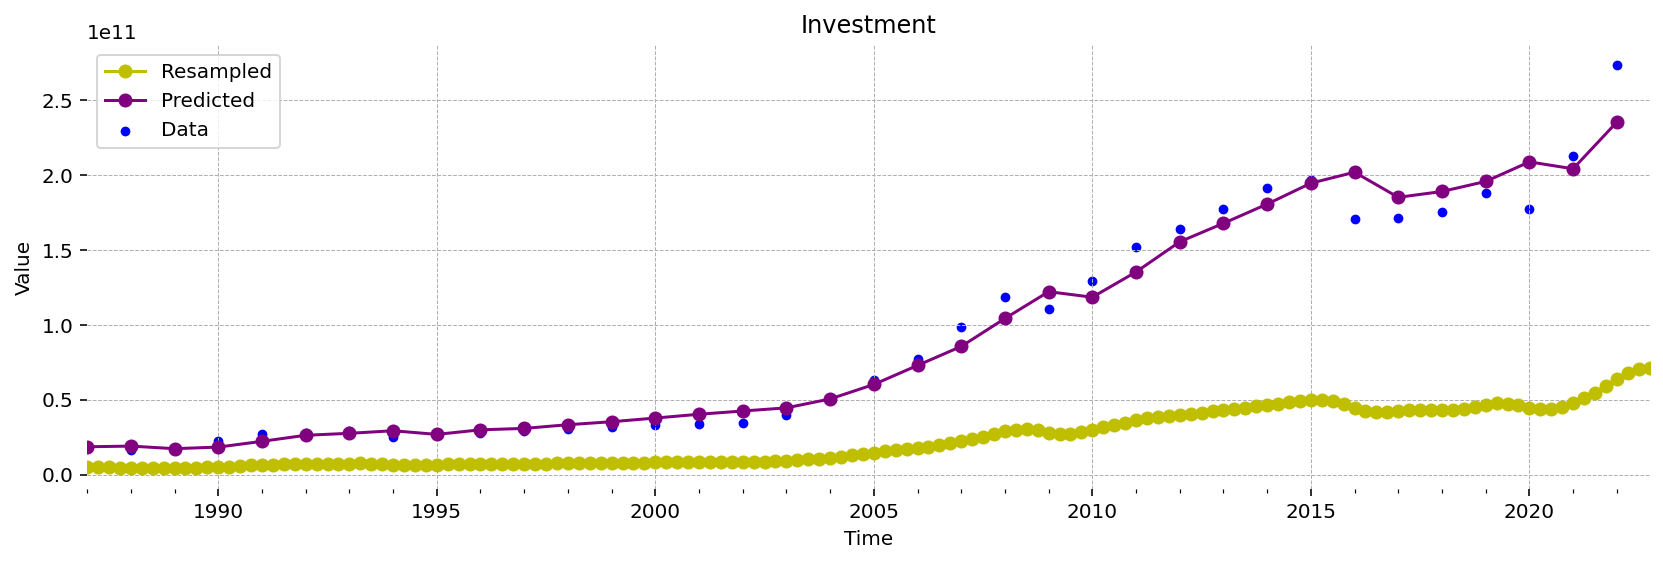

In [185]:
# Plot both the resampled data and the predicted trend on a quarterly scale
fig, ax = plt.subplots()
I_resample.plot(label='Resampled', marker='o', c='y')
res.predict().plot(label='Predicted', marker='o', ax=ax, c='purple')
ax.scatter(I_quarterly.index, I_quarterly.values, s=15, c='b', label='Data')
ax.legend()
plt.title("Investment")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The graph illustrates that the second estimation method, which involves changing the data frequency from annual to quarterly, closely aligns with the original data points and provides a better fit to the data. We will continue to use this method for further conversions when appropriate.

In [186]:
# Display information about the I_predict dataset
I_predict.info()

# Drop the 'I' column and reset the index
I_predict.drop(columns='I', inplace=True)

# Rename the dataset columns for better alignment with current notation
I_predict.columns = ['I']

# Display updated information about the modified dataset
I_predict.info()

# Display the first few rows of the modified dataset
I_predict.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1987-01-01 to 2022-10-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       288 non-null    float64
 1   I       0 non-null      float64
dtypes: float64(2)
memory usage: 6.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1987-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       288 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


I
1987-01-01  4.932778e+09
1987-01-01  4.932778e+09
1987-04-01  4.932778e+09
1987-04-01  4.873156e+09
1987-07-01  4.753910e+09

In [187]:
# Drop the 'I' column from final_df and join with I_predict
# Note: We drop the 'I' column from final_df to replace it with the more recent predictions from I_predict

# Ensure there are no duplicate indices in I_predict to avoid conflicts during the join
I_predict = I_predict[~I_predict.index.duplicated(keep='first')]

# Display information about the modified I_predict dataset
I_predict.info()

# Display the first few rows of the modified I_predict dataset
I_predict.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1987-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


I
1987-01-01  4.932778e+09
1987-04-01  4.932778e+09
1987-07-01  4.753910e+09
1987-10-01  4.575042e+09
1988-01-01  4.336551e+09

In [188]:
# Display information about the original final_df dataset
final_df.info()

# Create a copy of final_df to preserve the original data
final_df_quarterly = final_df

# Drop the 'I' column from the copy and join with the updated predictions from I_predict
# Note: This step is part of adjusting the dataset to quarterly frequency
final_df_quarterly = final_df_quarterly.drop(columns=['I']).join(I_predict)

# Display information about the modified final_df_quarterly dataset
final_df_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Y        55 non-null     float64
 1   I        36 non-null     float64
 2   C        55 non-null     float64
 3   rt       67 non-null     float64
 4   w        27 non-null     float64
 5   N        27 non-null     float64
 6   Rt       27 non-null     float64
 7   K        33 non-null     float64
 8   CPI      36 non-null     float64
 9   Ex_rate  442 non-null    float64
 10  Oil      9317 non-null   float64
dtypes: float64(11)
memory usage: 916.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Y        55 non-null     float64
 1   C        55 non-null     float64
 2   rt       67 non-null     float64
 3   w        27 non-nu

In [189]:
# Display the 'I' column of the modified final_df_quarterly dataset
print(final_df_quarterly['I'])

# Display the first few rows of the modified final_df_quarterly dataset
print(final_df_quarterly.head())

# Display information about the modified final_df_quarterly dataset
final_df_quarterly.info()

# Display the index of the modified final_df_quarterly dataset
print(final_df_quarterly.index)

# Display the columns of the modified final_df_quarterly dataset
print(final_df_quarterly.columns)

DATE
1987-01-01    4.932778e+09
1987-01-02             NaN
1987-01-05             NaN
1987-01-06             NaN
1987-01-07             NaN
                  ...     
2023-12-20             NaN
2023-12-21             NaN
2023-12-22             NaN
2023-12-25             NaN
2023-12-26             NaN
Name: I, Length: 9775, dtype: float64
             Y   C  rt   w   N  Rt           K       CPI  Ex_rate    Oil  \
DATE                                                                       
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25 -1.547117     3.75    NaN   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN  18.13   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN  17.98   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN  18.21   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN  18.28   

                       I  
DATE                      
1987-01-01  4.932778e+09  
1987-01-02           NaN  
1987-01-05         

##### Variable 2: Oil Prices

Converting working day data with missing weekend observations to quarterly data.

In [190]:
# Create a disaggregate version of Oil to derive quarterly data from a yearly dataframe
Oil_resample = final_df['Oil'].copy()

# Display the first few rows of the disaggregated Oil_resample data
Oil_resample.head()

DATE
1987-01-01      NaN
1987-01-02    18.13
1987-01-05    17.98
1987-01-06    18.21
1987-01-07    18.28
Name: Oil, dtype: float64

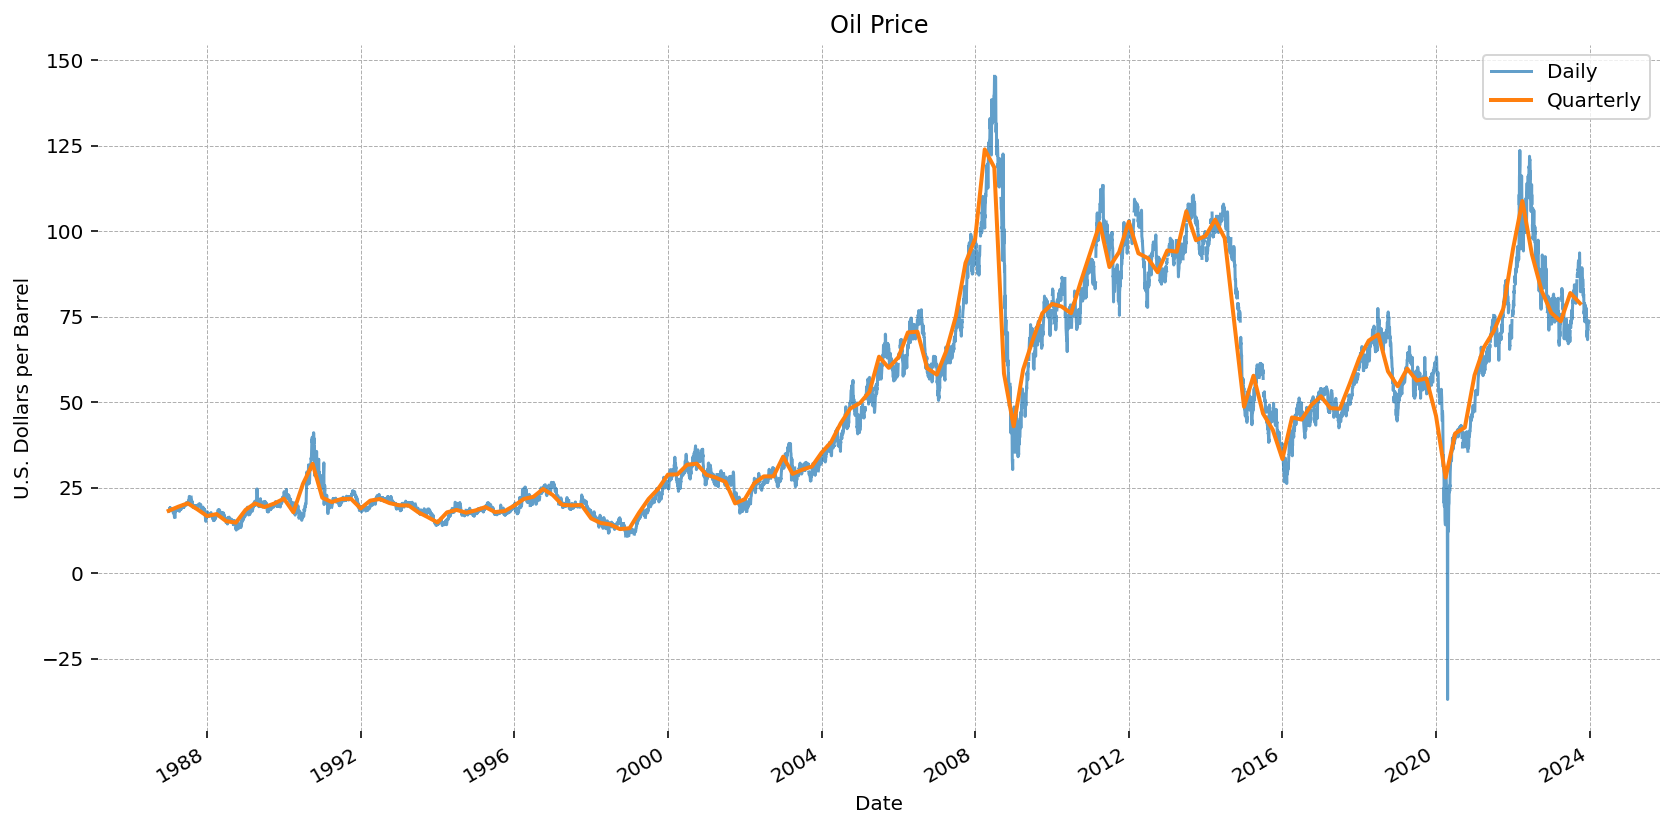

In [191]:
# Forward-fill missing values in Oil_resample
Oil_resample_filled = Oil_resample.ffill()

# Resample the filled data to quarterly frequency
Oil_quarterly = Oil_resample_filled.resample('QS', closed='left', label='left').mean()

# Plotting Daily vs. Quarterly Oil Data
plt.figure(figsize=(14, 7))

# Plot the original daily data
Oil_resample.plot(label='Daily', alpha=0.7)

# Plot the resampled quarterly data
Oil_quarterly.plot(label='Quarterly', lw=2)

# Set plot labels and title
plt.title('Oil Price')
plt.xlabel('Date')
plt.ylabel('U.S. Dollars per Barrel')

# Add legend, grid, and display the plot
plt.legend()
plt.grid(True)
plt.show()

A limitation of converting daily data to quarterly data is the loss of granularity, as the quarterly frequency do not capture all the nuanced movements. This is particularly evident in situations with rapid and significant changes, such as the sharp decline in oil prices observed in 2020. The smoothing effect introduced by aggregating to a quarterly frequency results in a less accurate representation of the actual dynamics during shorter time intervals. It's important to acknowledge this limitation when interpreting the quarterly data, as certain short-term fluctuations may not be fully captured in the transformed dataset.

In [192]:
# Display information about the Oil_quarterly dataset
Oil_quarterly.info()

# Display the first few rows of the Oil_quarterly dataset
Oil_quarterly.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Oil
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


DATE
1987-01-01    18.228923
1987-04-01    19.397538
1987-07-01    20.425224
1987-10-01    18.644030
1988-01-01    16.685846
Freq: QS-JAN, Name: Oil, dtype: float64

In [193]:
# Display information about the Oil_quarterly dataset
Oil_quarterly.info()

# Convert Oil_quarterly to a DataFrame and rename the column
Oil_quarterly_frame = Oil_quarterly.to_frame()
Oil_quarterly_frame.columns = ['Oil']

# Display information about the Oil_quarterly_frame dataset
Oil_quarterly_frame.info()

# Display the first few rows of the Oil_quarterly_frame dataset
Oil_quarterly_frame.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Oil
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Oil     148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


Oil
DATE                 
1987-01-01  18.228923
1987-04-01  19.397538
1987-07-01  20.425224
1987-10-01  18.644030
1988-01-01  16.685846

In [194]:
# Merge oil back to dataframe and drop the old data
final_df_quarterly = final_df_quarterly.drop(columns=['Oil']).join(Oil_quarterly_frame)

In [195]:
# Display the 'Oil' column of the modified final_df_quarterly dataset before merging
print(final_df_quarterly['Oil'])

# Display the first few rows of the modified final_df_quarterly dataset before merging
print(final_df_quarterly.head())

# Display information about the modified final_df_quarterly dataset before merging
final_df_quarterly.info()

# Display the index of the modified final_df_quarterly dataset before merging
print(final_df_quarterly.index)

# Display the columns of the modified final_df_quarterly dataset before merging
print(final_df_quarterly.columns)

DATE
1987-01-01    18.228923
1987-01-02          NaN
1987-01-05          NaN
1987-01-06          NaN
1987-01-07          NaN
                ...    
2023-12-20          NaN
2023-12-21          NaN
2023-12-22          NaN
2023-12-25          NaN
2023-12-26          NaN
Name: Oil, Length: 9775, dtype: float64
             Y   C  rt   w   N  Rt           K       CPI  Ex_rate  \
DATE                                                                
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25 -1.547117     3.75   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN       NaN      NaN   

                       I        Oil  
DATE                                 
1987-01-01  4.932778e+09  18.228923  
1987-01-02           NaN        NaN  
1987-01-05           NaN        NaN  
1987-01-06       

##### Variable 3: Exchange Rate

Convert daily data to quarterly data.

In [196]:
# Create a resampled version of Ex_rate from final_df
Ex_rate_resample = final_df['Ex_rate'].dropna().copy()

# Display the first few rows of the resampled Ex_rate data
Ex_rate_resample.head()

# Check the inferred frequency of the index in Ex_rate_resample
Ex_rate_resample.index.inferred_freq

'MS'

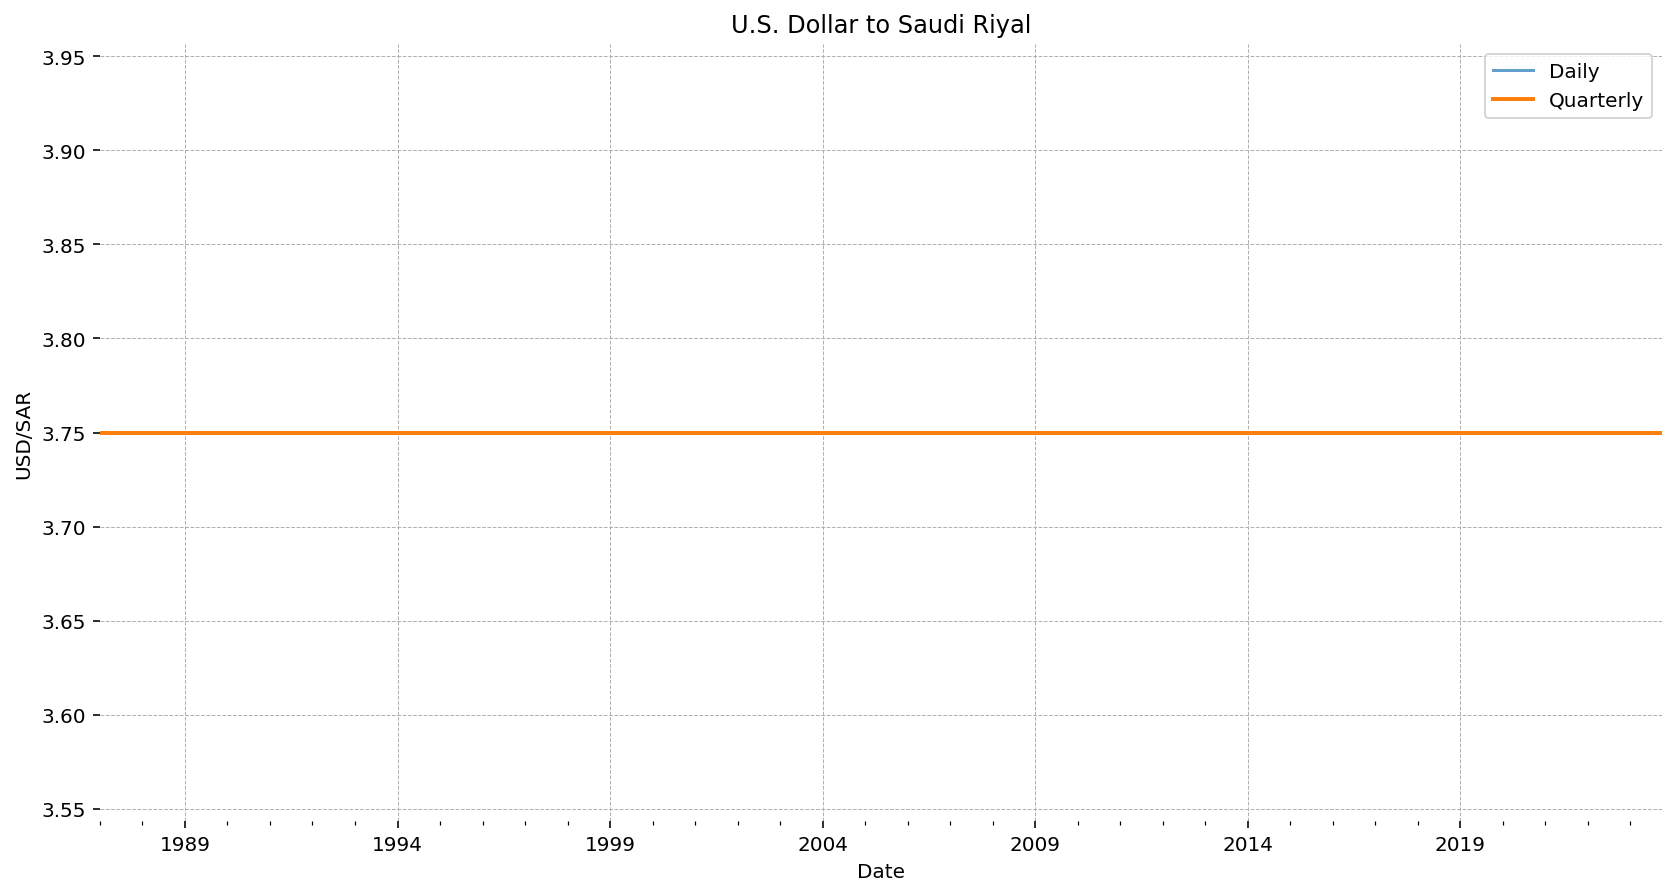

In [205]:
# Resample Ex_rate_resample to quarterly frequency
Ex_rate_quarterly = Ex_rate_resample.resample('QS', closed='left', label='left').mean()

# Plotting Daily vs. Quarterly Ex Rate Data
plt.figure(figsize=(14, 7))

# Plot the original daily data
Ex_rate_resample.plot(label='Daily', alpha=0.7)

# Plot the resampled quarterly data
Ex_rate_quarterly.plot(label='Quarterly', lw=2)

# Set plot labels and title
plt.title('U.S. Dollar to Saudi Riyal')
plt.xlabel('Date')
plt.ylabel('USD/SAR')

# Add legend, grid, and display the plot
plt.legend()
plt.grid(True)
plt.show()

In [206]:
# Display information about the Ex_rate_quarterly dataset
Ex_rate_quarterly.info()

# Display the first few rows of the Ex_rate_quarterly dataset
Ex_rate_quarterly.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Ex_rate
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


DATE
1987-01-01    3.75
1987-04-01    3.75
1987-07-01    3.75
1987-10-01    3.75
1988-01-01    3.75
Freq: QS-JAN, Name: Ex_rate, dtype: float64

In [207]:
# Convert Ex_rate_quarterly to a DataFrame and rename the column
Ex_rate_quarterly_Frame = Ex_rate_quarterly.to_frame()
Ex_rate_quarterly_Frame.columns = ['Ex_rate']

# Display information about the Ex_rate_quarterly_Frame dataset
Ex_rate_quarterly_Frame.info()

# Display the first few rows of the Ex_rate_quarterly_Frame dataset
Ex_rate_quarterly_Frame.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


Ex_rate
DATE               
1987-01-01     3.75
1987-04-01     3.75
1987-07-01     3.75
1987-10-01     3.75
1988-01-01     3.75

In [208]:
# Display the first few rows of the final_df_quarterly dataset
print(final_df_quarterly.head())

             Y   C  rt   w   N  Rt           K       CPI             I  \
DATE                                                                     
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25 -1.547117  4.932778e+09   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   

                  Oil  Ex_rate  
DATE                            
1987-01-01  18.228923     3.75  
1987-01-02        NaN      NaN  
1987-01-05        NaN      NaN  
1987-01-06        NaN      NaN  
1987-01-07        NaN      NaN  


In [209]:
# Merge exchange rate back to dataframe and drop the old data
final_df_quarterly = final_df_quarterly.drop(columns=['Ex_rate']).join(Ex_rate_quarterly_Frame)

In [210]:
# Display the 'Ex_rate' column from final_df_quarterly
print(final_df_quarterly['Ex_rate'])

# Display the first few rows of final_df_quarterly
print(final_df_quarterly.head())

# Display information about final_df_quarterly
final_df_quarterly.info()

# Display the index of final_df_quarterly
print(final_df_quarterly.index)

# Display the columns of final_df_quarterly
print(final_df_quarterly.columns)

DATE
1987-01-01    3.75
1987-01-02     NaN
1987-01-05     NaN
1987-01-06     NaN
1987-01-07     NaN
              ... 
2023-12-20     NaN
2023-12-21     NaN
2023-12-22     NaN
2023-12-25     NaN
2023-12-26     NaN
Name: Ex_rate, Length: 9775, dtype: float64
             Y   C  rt   w   N  Rt           K       CPI             I  \
DATE                                                                     
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25 -1.547117  4.932778e+09   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN       NaN           NaN   

                  Oil  Ex_rate  
DATE                            
1987-01-01  18.228923     3.75  
1987-01-02        NaN      NaN  
1987-01-05        NaN      NaN  
1987-01-06        NaN      NaN  
1987-01-07        NaN    

##### Variable 4: Inflation

Convert yearly data to quarterly data.

In [211]:
# Create a copy of the 'CPI' column, dropping any NaN values
CPI_df = final_df['CPI'].dropna().copy()

# Rename the series to 'CPI'
CPI_df.name = 'CPI'

# Display the first few rows of the 'CPI_df' series
CPI_df.head()

DATE
1987-01-01   -1.547117
1988-01-01    0.907563
1989-01-01    1.032645
1990-01-01    2.077151
1991-01-01    4.861111
Name: CPI, dtype: float64

<Axes: xlabel='DATE'>

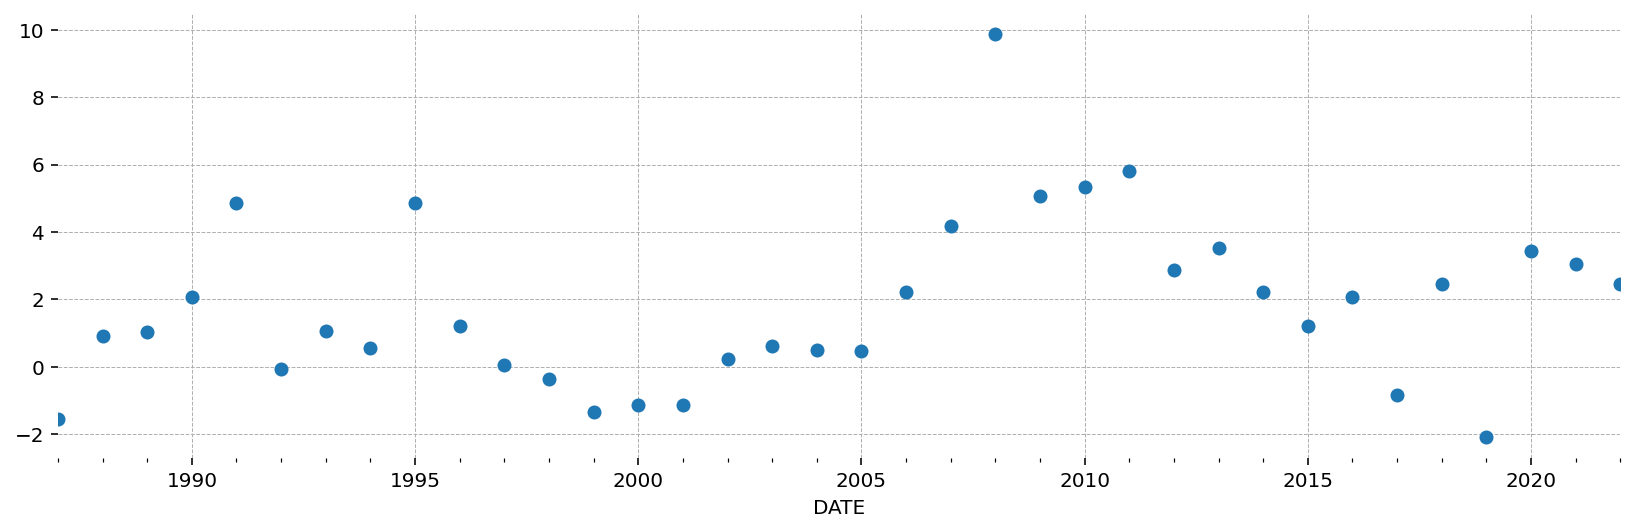

In [212]:
# Resample the 'CPI_df' series to quarterly frequency and plot the data
CPI_df.resample('QS').asfreq().plot(marker='o')

In [213]:
# Create a quarterly version of CPI by multiplying the monthly values by 0.25
quarterly_CPI = CPI_df.mul(0.25).resample('QS').asfreq()

# Display the last few rows of the resulting quarterly data
quarterly_CPI.tail()

DATE
2021-01-01    0.765822
2021-04-01         NaN
2021-07-01         NaN
2021-10-01         NaN
2022-01-01    0.618518
Freq: QS-JAN, Name: CPI, dtype: float64

In [214]:
# Concatenate a Series of NaN values for the next three quarters to the quarterly CPI data
quarterly_CPI = pd.concat([quarterly_CPI,
                           pd.Series(np.nan, 
                                     index=quarterly_CPI.index[-1] + np.array([1, 2, 3]) * quarterly_CPI.index.freq,
                                     name='C')])

In [215]:
quarterly_CPI.tail()

2021-10-01         NaN
2022-01-01    0.618518
2022-04-01         NaN
2022-07-01         NaN
2022-10-01         NaN
dtype: float64

In [216]:
# We set the trend to 'ctt' which means quadratic trend, since this data is increasing exponentially.
mod = sm.tsa.SARIMAX(quarterly_CPI, order=(1, 0, 0), trend='n')
res = mod.fit(method='nm', maxiter=10_000)

Optimization terminated successfully.
         Current function value: 0.217545
         Iterations: 40
         Function evaluations: 78


C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [217]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -31.326
Date:                Wed, 03 Jan 2024   AIC                             66.653
Time:                        16:54:35   BIC                             72.593
Sample:                    01-01-1987   HQIC                            69.066
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9009      0.044     20.600      0.000       0.815       0.987
sigma2         0.1093      0.031      3.570      0.000       0.049       0.169
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1201.68
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             2.36
Prob(H) (two-sided):                  0.72   Kurtosis:                        16.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

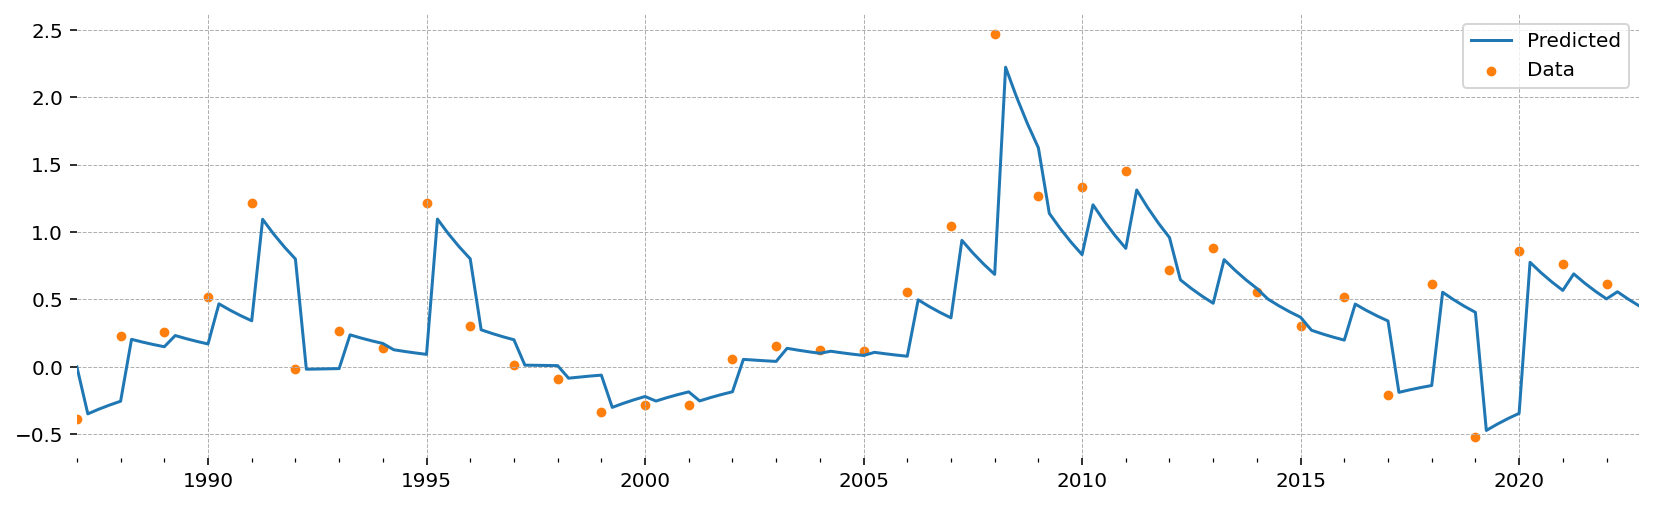

In [218]:
# Plot both the predicted trend on a quarterly scale and the real data for CPI
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax)
ax.scatter(quarterly_CPI.index, quarterly_CPI.values, s=15, color='tab:orange', label='Data')
ax.legend()
plt.show()

In [219]:
# Make predictions for quarterly CPI data
quarterly_periods = quarterly_CPI.index
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data_CPI = predictions.predicted_mean

# Forward-fill NAs in the predicted data
predicted_data_CPI.ffill(inplace=True)

# Print the predicted data
print(predicted_data_CPI)

1987-01-01    0.000000
1987-04-01   -0.348438
1987-07-01   -0.313898
1987-10-01   -0.282781
1988-01-01   -0.254749
                ...   
2021-10-01    0.559906
2022-01-01    0.504403
2022-04-01    0.557205
2022-07-01    0.501970
2022-10-01    0.452210
Freq: QS-OCT, Name: predicted_mean, Length: 144, dtype: float64


In [220]:
# Reset index and rename to match your requirements
predicted_data_CPI.name = 'CPI_pred'

# Rename our target column
CPI_to_use = predicted_data_CPI
CPI_to_use.name = 'CPI'

In [221]:
# Drop the 'CPI' column from final_df_quarterly and join with CPI_to_use
final_df_quarterly = final_df_quarterly.drop(columns=['CPI']).join(CPI_to_use)

# Display information about the final_df_quarterly dataset
final_df_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Y        55 non-null     float64
 1   C        55 non-null     float64
 2   rt       67 non-null     float64
 3   w        27 non-null     float64
 4   N        27 non-null     float64
 5   Rt       27 non-null     float64
 6   K        33 non-null     float64
 7   I        144 non-null    float64
 8   Oil      148 non-null    float64
 9   Ex_rate  148 non-null    float64
 10  CPI      144 non-null    float64
dtypes: float64(11)
memory usage: 916.4 KB


##### Variable 5: Capital (K)

Convert annual data to quarterly observations.

In [223]:
# Extract the 'K' column from final_df, drop NaN values, and copy
K_df = final_df['K'].dropna().copy()
# Rename the series to 'K'
K_df.name = 'K'
# Display the first few rows of the K_df series
K_df.head()

DATE
1987-01-01    1217826.250
1988-01-01    1242607.375
1989-01-01    1267507.625
1990-01-01    1305733.000
1991-01-01    1363655.000
Name: K, dtype: float64

<Axes: xlabel='DATE'>

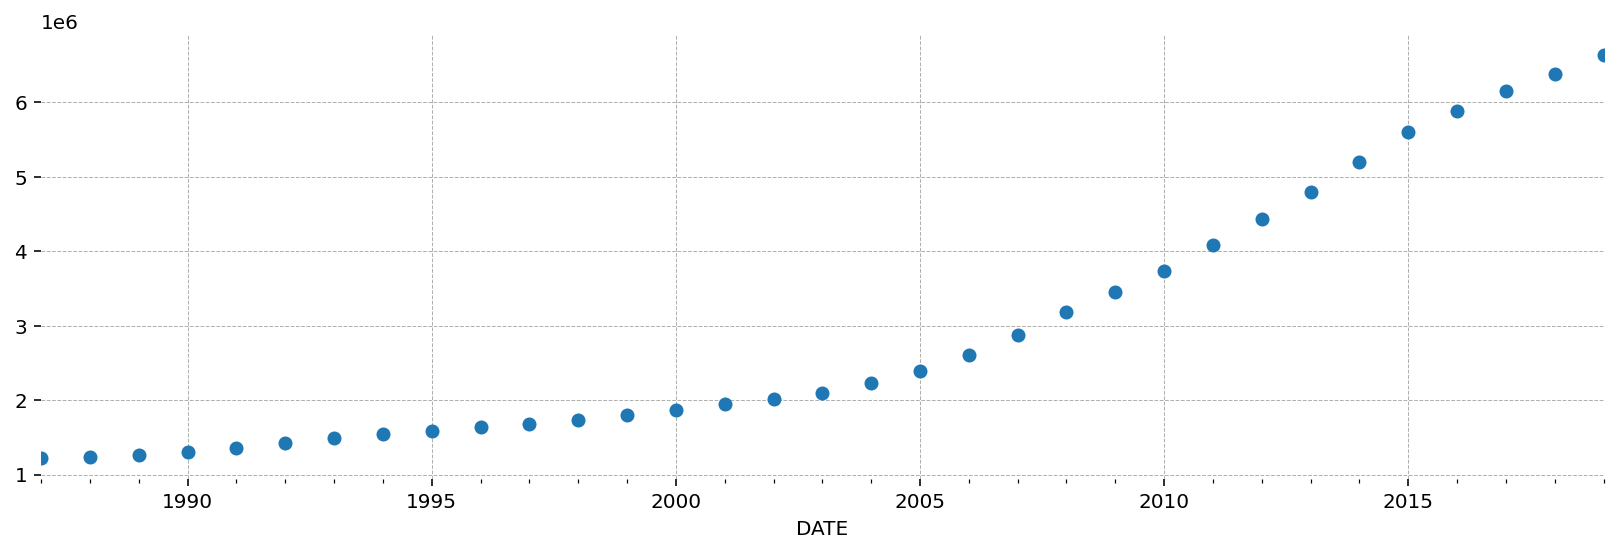

In [224]:
# Resample 'K_df' to quarterly frequency and plot with markers
K_df.resample('QS').asfreq().plot(marker='o')

In [225]:
# Resample 'K_df' to quarterly frequency and calculate the quarterly mean
quarterly_K = K_df.mul(0.25).resample('QS').asfreq()
quarterly_K.tail()

DATE
2018-01-01    1596372.500
2018-04-01            NaN
2018-07-01            NaN
2018-10-01            NaN
2019-01-01    1658262.625
Freq: QS-JAN, Name: K, dtype: float64

In [226]:
# Concatenate NaN values for the next three quarters to 'quarterly_K'
quarterly_K = pd.concat([quarterly_K,
                         pd.Series(np.nan, 
                                   index=quarterly_K.index[-1] + np.array([1, 2, 3]) * quarterly_K.index.freq,
                                   name='C')])
quarterly_K.tail()

2018-10-01            NaN
2019-01-01    1658262.625
2019-04-01            NaN
2019-07-01            NaN
2019-10-01            NaN
dtype: float64

In [227]:
# We set the trend to 'ctt' which means quadratic trend, since this data is increasing exponentially.
mod = sm.tsa.SARIMAX(quarterly_K, order=(1, 0, 0), trend='ctt')

# Fit the model
res = mod.fit(method='nm', maxiter=10_000)

C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 2.758591
         Iterations: 523
         Function evaluations: 876


In [228]:
# Resample the 'K_df' data to quarterly frequency and display the last few rows
quarterly_K = K_df.mul(0.25).resample('QS').asfreq()
quarterly_K.tail()

DATE
2018-01-01    1596372.500
2018-04-01            NaN
2018-07-01            NaN
2018-10-01            NaN
2019-01-01    1658262.625
Freq: QS-JAN, Name: K, dtype: float64

In [229]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -364.134
Date:                Wed, 03 Jan 2024   AIC                            738.268
Time:                        16:57:45   BIC                            752.682
Sample:                    01-01-1987   HQIC                           744.125
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8348.2539   8712.302      0.958      0.338   -8727.544    2.54e+04
drift         63.3553    133.393      0.475      0.635    -198.090     324.801
trend.2        3.1779      2.630      1.208      0.227      -1.977       8.333
ar.L1          0.9729      0.022     44.520      0.000       0.930       1.016
sigma2      5.799e+07      3.395   1.71e+07      0.000     5.8e+07     5.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               244.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.94   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.92e+22. Standard errors may be unstable.
"""

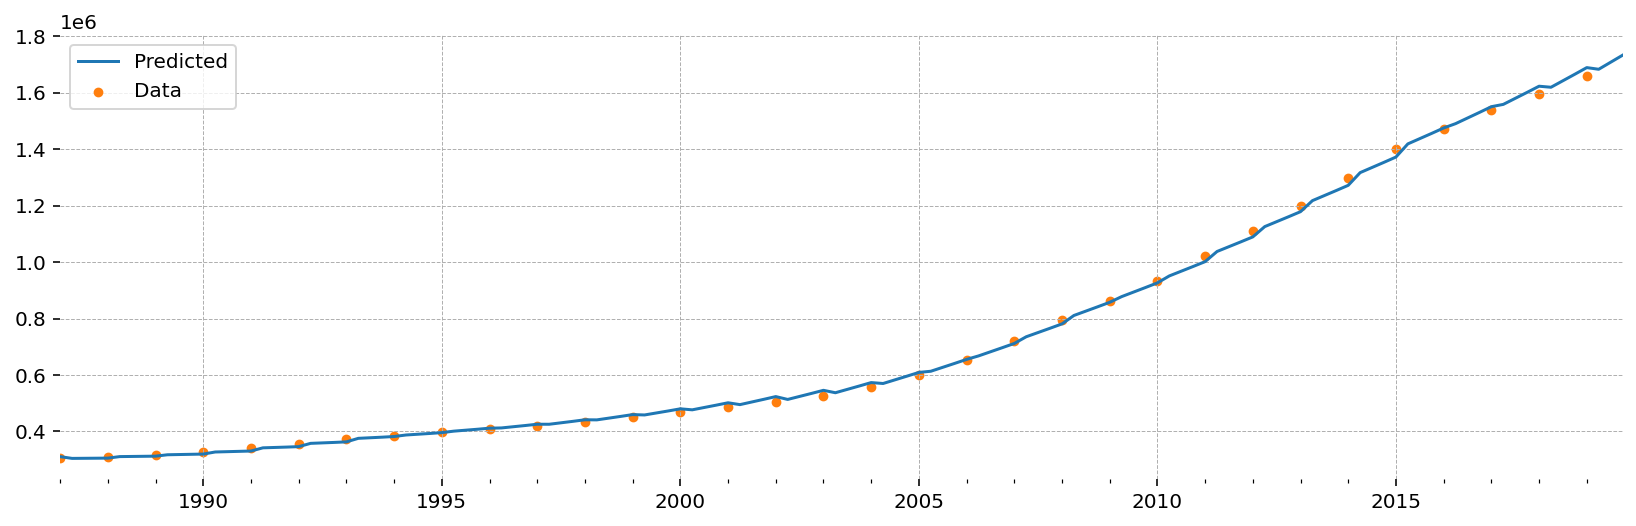

In [230]:
# Plotting the predicted trend and real data for 'K'
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax)
ax.scatter(quarterly_K.index, quarterly_K.values, s=15, color='tab:orange', label='Data')
ax.legend()
plt.show()

In [231]:
# Make predictions for 'K' on a quarterly scale
quarterly_periods = quarterly_K.index
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data_K = predictions.predicted_mean

# Forward-fill NAs in the predicted data
predicted_data_K.ffill(inplace=True)

# Display the predicted data for 'K'
print(predicted_data_K)

1987-01-01    3.108133e+05
1987-04-01    3.046287e+05
1987-07-01    3.048690e+05
1987-10-01    3.051821e+05
1988-01-01    3.055723e+05
                  ...     
2018-01-01    1.622754e+06
2018-04-01    1.619076e+06
2018-07-01    1.642026e+06
2018-10-01    1.665221e+06
2019-01-01    1.688663e+06
Freq: QS-OCT, Name: predicted_mean, Length: 129, dtype: float64


In [240]:
# Reset index and rename to match your requirements
predicted_data_K.name = 'K_pred'

# Rename our target column 
K_to_use = predicted_data_K
K_to_use.name = 'K'

In [241]:
# Drop the 'K' column from final_df_quarterly and join with K_to_use
final_df_quarterly = final_df_quarterly.drop(columns=['K']).join(K_to_use)

# Display information about the final_df_quarterly dataset
final_df_quarterly.head()

Y   C  rt   w   N  Rt             I        Oil  Ex_rate  CPI  \
DATE                                                                        
1987-01-01 NaN NaN NaN NaN NaN NaN  4.932778e+09  18.228923     3.75  0.0   
1987-01-02 NaN NaN NaN NaN NaN NaN           NaN        NaN      NaN  NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN           NaN        NaN      NaN  NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN           NaN        NaN      NaN  NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN           NaN        NaN      NaN  NaN   

                        K  
DATE                       
1987-01-01  310813.315714  
1987-01-02            NaN  
1987-01-05            NaN  
1987-01-06            NaN  
1987-01-07            NaN

### Visual Inspection of Quarterly Data

In [242]:
#dropping all the daily ones that are left and where we know have no data
final_df_quarterly.head()
final_df_quarterly_clean = final_df_quarterly.dropna(how='all')
final_df_quarterly_clean.head()
final_df_quarterly_clean.tail()

Y         C        rt             w           N  Rt  \
DATE                                                                     
2022-10-01  763749.3  273441.0  5.281580  29104.361421  521.538929 NaN   
2023-01-01  755222.8  285196.3  5.494884  29679.726126  520.218383 NaN   
2023-04-01  751407.3  281622.0  5.830098  29770.814673  524.577082 NaN   
2023-07-01  727541.7  292098.4  6.088936           NaN         NaN NaN   
2023-10-01       NaN       NaN       NaN           NaN         NaN NaN   

                       I        Oil  Ex_rate      CPI   K  
DATE                                                       
2022-10-01  7.137510e+10  82.621515     3.75  0.45221 NaN  
2023-01-01           NaN  76.124242     3.75      NaN NaN  
2023-04-01           NaN  73.635606     3.75      NaN NaN  
2023-07-01           NaN  81.934242     3.75      NaN NaN  
2023-10-01           NaN  78.919683     3.75      NaN NaN

C:\Users\jessi\AppData\Local\Temp\ipykernel_47164\2657239562.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


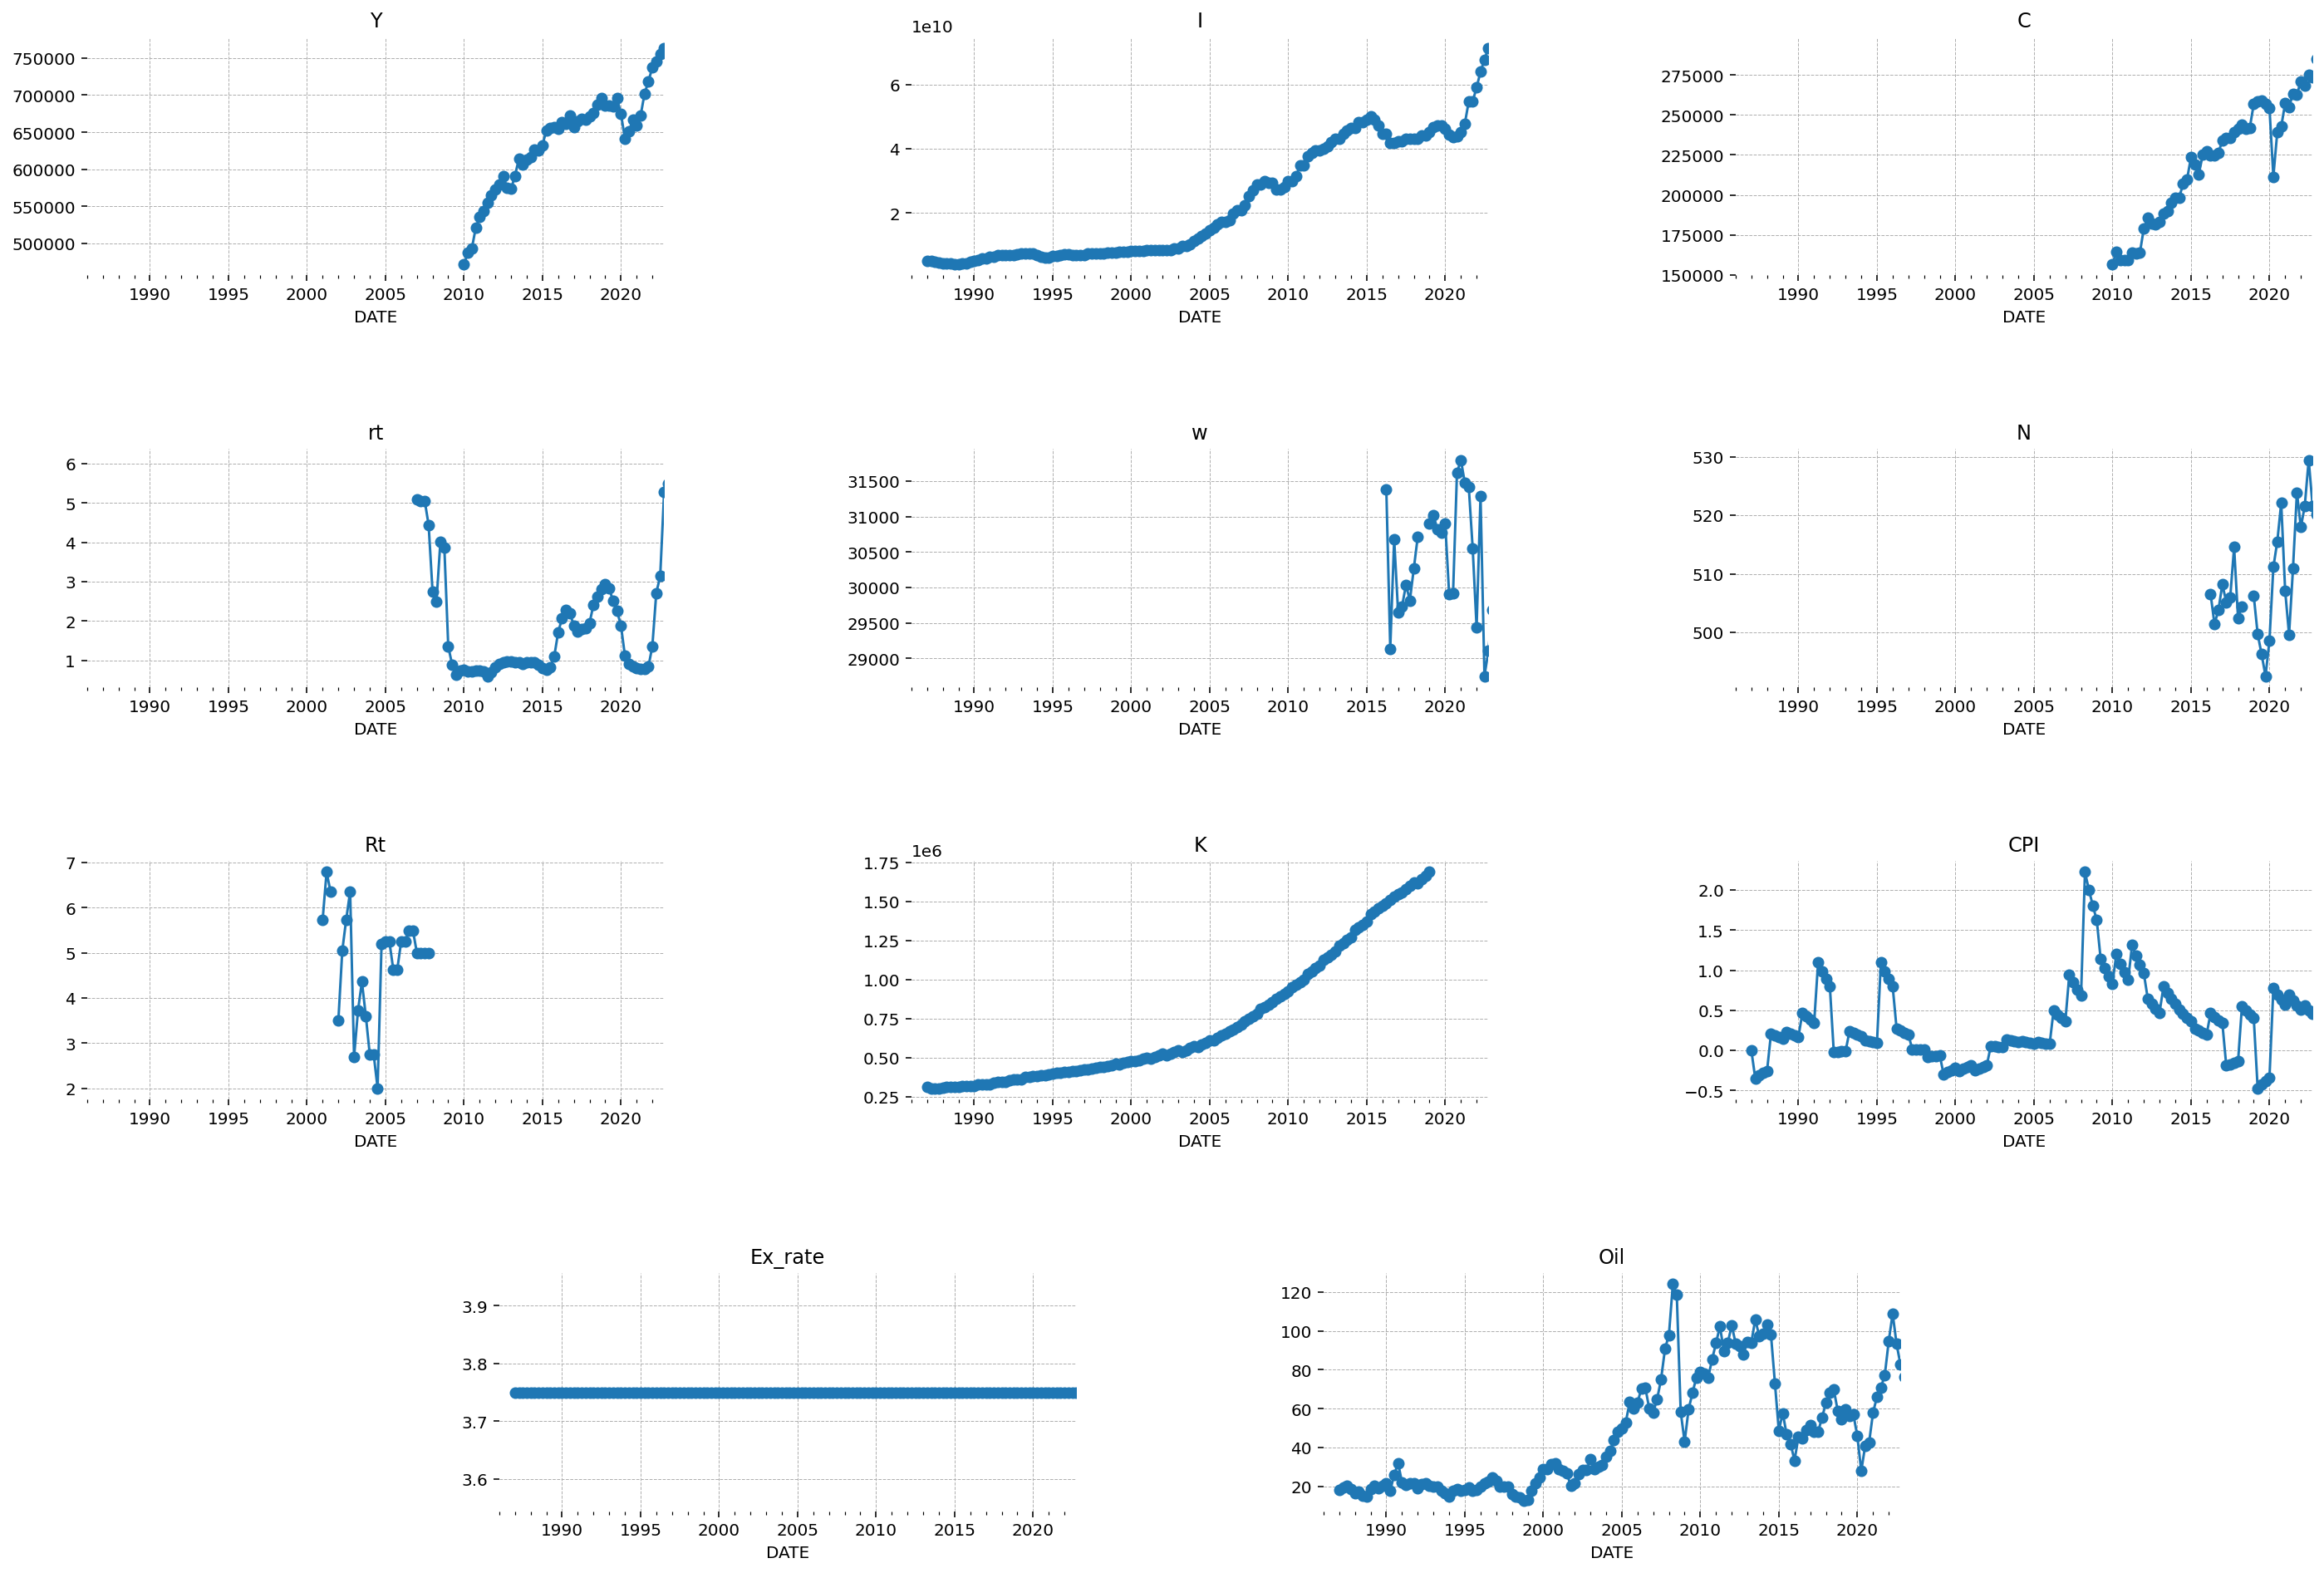

In [243]:
def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(24, 16), dpi=144)  # Increased figure size
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    # Adjusting the layout for better spacing
    gs.update(hspace=5.5, wspace=1.5)  

    for loc, var in zip(plot_locs, final_df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

        # Set x-axis limits
        axis.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    plt.tight_layout()
    plt.show()

plot_df(final_df_quarterly_clean, marker='o')

### 3) Currency Conversion

To maintain uniformity within our dataset, we convert variables expressed in Saudi Riyal (SAR) to U.S. dollars (USD). This process involves transforming Y, C, and w from Riyal to USD using the exchange rate.

| Step | Variable  | Currency Conversion |
|------|-----------|--------------------------------|
| 1    | Y         |  Yes    |
| 3    | I         | No      |
| 4    | C         | Yes     |
| 6    | rt        | No     |
| 7    | w         | Yes     |
| 8    | Rt        | No     |
| 9    | K         |   No   |
| 11   | CPI       | No      |
| 12   | Ex_Rate   | No      |
| 13   | Oil       | No      |

In [245]:
# Convert Y, C, and w from Riyal to USD using the exchange rate
final_df_quarterly_clean.tail()
# Create a new dataframe with the same data
final_df_quarterly_clean_USD = final_df_quarterly_clean.copy()
final_df_quarterly_clean_USD.tail()

Y         C        rt             w           N  Rt  \
DATE                                                                     
2022-10-01  763749.3  273441.0  5.281580  29104.361421  521.538929 NaN   
2023-01-01  755222.8  285196.3  5.494884  29679.726126  520.218383 NaN   
2023-04-01  751407.3  281622.0  5.830098  29770.814673  524.577082 NaN   
2023-07-01  727541.7  292098.4  6.088936           NaN         NaN NaN   
2023-10-01       NaN       NaN       NaN           NaN         NaN NaN   

                       I        Oil  Ex_rate      CPI   K  
DATE                                                       
2022-10-01  7.137510e+10  82.621515     3.75  0.45221 NaN  
2023-01-01           NaN  76.124242     3.75      NaN NaN  
2023-04-01           NaN  73.635606     3.75      NaN NaN  
2023-07-01           NaN  81.934242     3.75      NaN NaN  
2023-10-01           NaN  78.919683     3.75      NaN NaN

In [246]:
# Convert Y, C, and w from Riyal to USD using the exchange rate
final_df_quarterly_clean_USD.loc[final_df_quarterly_clean_USD['Y'].notna(), 'Y'] /= final_df_quarterly_clean_USD['Ex_rate']
final_df_quarterly_clean_USD.loc[final_df_quarterly_clean_USD['C'].notna(), 'C'] /= final_df_quarterly_clean_USD['Ex_rate']
final_df_quarterly_clean_USD.loc[final_df_quarterly_clean_USD['w'].notna(), 'w'] /= final_df_quarterly_clean_USD['Ex_rate']

# Display the first few rows of the modified dataframe
print(final_df_quarterly_clean_USD.tail())

                        Y             C        rt            w           N  \
DATE                                                                         
2022-10-01  203666.480000  72917.600000  5.281580  7761.163046  521.538929   
2023-01-01  201392.746667  76052.346667  5.494884  7914.593634  520.218383   
2023-04-01  200375.280000  75099.200000  5.830098  7938.883913  524.577082   
2023-07-01  194011.120000  77892.906667  6.088936          NaN         NaN   
2023-10-01            NaN           NaN       NaN          NaN         NaN   

            Rt             I        Oil  Ex_rate      CPI   K  
DATE                                                           
2022-10-01 NaN  7.137510e+10  82.621515     3.75  0.45221 NaN  
2023-01-01 NaN           NaN  76.124242     3.75      NaN NaN  
2023-04-01 NaN           NaN  73.635606     3.75      NaN NaN  
2023-07-01 NaN           NaN  81.934242     3.75      NaN NaN  
2023-10-01 NaN           NaN  78.919683     3.75      NaN NaN  


### 4) Constant Prices


Consistent with the RBC model, variables not expressed in real terms are adjusted to constant prices with 2017 used as the base year.

| Step | Variable  | Constant Prices |
|------|-----------|------------|
| 1    | Y         | Not Required                                                                                             |      
| 2    | I         | Adjusted                                                                                           |
| 3    | C         | Not Required                                                                                                                      |
| 4    | rt        | Not Required                                                                                               |
| 5    | w         | Adjusted                                                                                                |
| 6    | Rt        | Not Required                                                                                            |
| 7    | K         | Not Required                                                                                             |                        
| 8   | CPI       | Not Required                                                                                  |
| 9   | Ex_Rate   | Not Required                                                                                        |
| 10   | Oil       | Adjusted                                                                                    |


### 5) Stationarity

The Augmented Dickey-Fuller test indicates potential stationarity with the constant term alone, as its test statistic surpasses the 1% critical value. Consequently, with a P-value of 0.005 for the constant term, we reject the null hypothesis at the 1% significance level. 

Variable 1: GDP (Y)

In [137]:
# Create a new dataframe 
df_Y = final_df_quarterly_clean[['Y']]

In [140]:
df_Y.tail()

Y
DATE                
2022-10-01  763749.3
2023-01-01  755222.8
2023-04-01  751407.3
2023-07-01  727541.7
2023-10-01       NaN

<Axes: xlabel='DATE'>

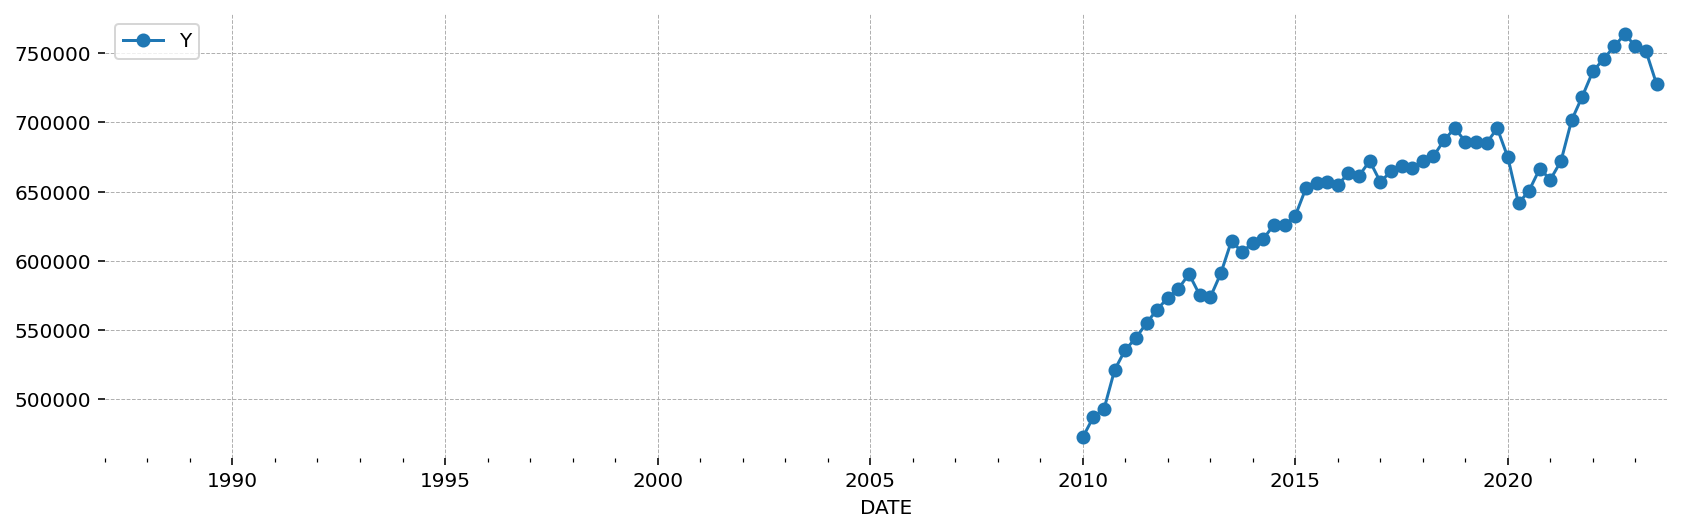

In [141]:
df_Y.plot(marker='o')

Based on visual inspection, graph has a trend. Run ADF test to check for stationary. If non-stationary - take logs

In [144]:
#Plot the log transformed difference
ADF_test_summary(final_df_quarterly_clean['Y'])


ValueError: df has missing data; handle it or pass missing='drop' to automatically drop it.

In [ ]:


df2.C.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of C over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

#Take the log of C
df2['log_C'] = df2['C'].map(np.log)
df2['diff_log_C'] = df2['log_C'].diff()
#Include the 'Date' column from df2
d_log_C = df2[['Date']].copy()
d_log_C['diff_log_C'] = df2['diff_log_C']
d_log_C.info()

#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df2['C']

In [ ]:
#Here we have something different from the previous variables, since, as we know from macro101, the value of a trade balance can be potentially be negative (Imp>Exp)
#Hence, we can takle these negative sign results as we are used to other variables, since we may have "gaps" in our plot 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#To deal with negative values, we can just easily add an enough small constant to the whole dataframe without causing any bias to the analysis
#As constant we use a fraction of the minimum value of TB (based on XYZ idea)
min_value = df4p['TB'].min()
constant = abs(0.1 * min_value)
#Custom log transformation function from the original that we have previously used 
def safe_log(x):
    return np.log(x + constant) if x > 0 else np.nan
#Apply the custom log transformation to each value of TB
log_transformed = df4p['TB'].apply(safe_log).diff()
#Interpolate missing values (the ones that otherwise would create gaps and non-continuity in our graph)
log_transformed.interpolate(inplace=True)
#Plot the log-transformed differences
log_transformed.plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of TB over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

### 6) Seasonal Adjustment 

GDP data are alreadyseasonality adjusted.

## **CHAPTER 2: RBC MODEL**

In [102]:
rbc = ge.gEconModel('GNC/DSGE SA Model.txt')

Model Building Complete.
Found:
	26 equations
	26 variables
	The following "variables" were defined as constants and have been substituted away:
		P_y_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	11 parameters
		 0 / 11 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations


In [103]:
for eq in rbc.system_equations:
    display(eq)

-C_t + Div_t - I_t + K_s_t-1*r_t + L_s_t*W_t + oil_t*p_oil_t

I_t - K_s_t + K_s_t-1*(1 - delta)

beta*U_t+1 + C_t**(1 - sigma_C)/(1 - sigma_C) - L_s_t**(sigma_L + 1)/(sigma_L + 1) - U_t

-lambda_t + C_t**(-sigma_C)

Q_t - lambda_t

beta*(-Q_t+1*(delta - 1) + lambda_t+1*r_t+1) - Q_t

-L_s_t**sigma_L + W_t*lambda_t

-Div_y_t + TC_y_t + Y_t

K_y_d_t**alpha_y*L_y_d_t**beta_y*X_es_d_t**(-alpha_y - beta_y + 1)*shock_y_t - Y_t

-K_y_d_t*r_t - L_y_d_t*W_t - P_es_t*X_es_d_t - TC_y_t

alpha_y*K_y_d_t**(alpha_y - 1)*L_y_d_t**beta_y*X_es_d_t**(-alpha_y - beta_y + 1)*shock_y_t - r_t

beta_y*K_y_d_t**alpha_y*L_y_d_t**(beta_y - 1)*X_es_d_t**(-alpha_y - beta_y + 1)*shock_y_t - W_t

K_y_d_t**alpha_y*L_y_d_t**beta_y*X_es_d_t**(-alpha_y - beta_y)*shock_y_t*(-alpha_y - beta_y + 1) - P_es_t

-Div_es_t + P_es_t*X_es_s_t + TC_es_t

K_es_d_t**alpha_es*L_es_d_t**beta_es*oil_t**(-alpha_es - beta_es + 1)*shock_es_t - X_es_s_t

-K_es_d_t*r_t - L_es_d_t*W_t - TC_es_t - oil_t*p_oil_t

alpha_es*K_es_d_t**(alpha_es - 1)*L_es_d_t**beta_es*P_es_t*oil_t**(-alpha_es - beta_es + 1)*shock_es_t - r_t

beta_es*K_es_d_t**alpha_es*L_es_d_t**(beta_es - 1)*P_es_t*oil_t**(-alpha_es - beta_es + 1)*shock_es_t - W_t

K_es_d_t**alpha_es*L_es_d_t**beta_es*P_es_t*oil_t**(-alpha_es - beta_es)*shock_es_t*(-alpha_es - beta_es + 1) - p_oil_t

K_es_d_t - K_s_t-1 + K_y_d_t

L_es_d_t - L_s_t + L_y_d_t

X_es_d_t - X_es_s_t

Div_es_t - Div_t + Div_y_t

phi_y*log(shock_y_t-1) + epsilon_y_t - log(shock_y_t)

phi_es*log(shock_es_t-1) + epsilon_es_t - log(shock_es_t)

phi_p_oil*log(p_oil_t-1) + epsilon_p_oil_t - log(p_oil_t)

## Find Steady State and Solve Model

In [104]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 2.3248369384684863e-28


C:\Users\jessi\miniconda3\envs\econ\Lib\site-packages\gEconpy\classes\model.py:604: UserWarning: The following variables have steady state values close to zero and will not be log linearized: Div_es, Div, Div_y
  warn(


Solution found, sum of squared residuals:  1.6841937732086856e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [105]:
rbc.print_steady_state()

C_ss                 2.247
Div_es_ss            0.000
Div_ss               0.000
Div_y_ss             0.000
I_ss                 1.186
K_es_d_ss           15.173
K_s_ss              47.457
K_y_d_ss            32.284
L_es_d_ss            0.268
L_s_ss               0.788
L_y_d_ss             0.519
P_es_ss              1.015
Q_ss                 0.378
TC_es_ss            -1.614
TC_y_ss             -3.434
U_ss              -435.345
W_ss                 1.323
X_es_d_ss            1.591
X_es_s_ss            1.591
Y_ss                 3.434
lambda_ss            0.378
oil_ss               0.726
p_oil_ss             1.000
r_ss                 0.035
shock_es_ss          1.000
shock_y_ss           1.000


## Impulse Response Functions

In [107]:
rbc.free_param_dict

{'alpha_es': 0.33,
 'alpha_y': 0.33,
 'beta': 0.99,
 'beta_es': 0.22,
 'beta_y': 0.2,
 'delta': 0.025,
 'phi_es': 0.53,
 'phi_p_oil': 0.97,
 'phi_y': 0.53,
 'sigma_C': 1.2,
 'sigma_L': 2.9}

In [ ]:
#Import necessary libraries
import pandas as pd
import pandas_datareader as pdr
#Import data for US dollar-Saudi Riyal Exchange rate
series_code = 'SAUCCUSMA02STM'
us_saudi = pdr.get_data_fred(series_code)
from pandas_datareader.fred import FredReader
data_cur = FredReader(symbols=['SAUCCUSMA02STM'], start='1960', end=None).read()
data_cur.to_csv('SA_currency_exch.csv')
data_cur = pd.read_csv('SA_currency_exch.csv', parse_dates=['DATE'])
#Rename the columns
#data_cur.columns = ['Date', 'ExRate']
data_cur.to_csv('SA_currency_exch.csv', index=False)
data_cur.rename(columns={'DATE': 'Date', 'SAUCCUSMA02STM': 'Ex_Rate'}, inplace=True)
#Rename columns
#data_cur = us_saudi.rename(columns={'SAUCCUSMA02STM': 'us_saudi_ER'})
data_cur.info

In [ ]:
quarterly_periods = quarterly_TB.index
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
TB_predict_final = pd.concat([quarterly_TB, pd.DataFrame(predicted_data, columns=['TB'], index=quarterly_periods)])
TB_predict_final.info()
#Sort the combined data by the index (Date)
TB_predict_final.sort_index(inplace=True)
#Reset index and rename to Date
#I_predict.reset_index(inplace=True)
#I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
TB_predict_final.ffill(inplace=True)
print(TB_predict_final)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
TB_quarterly_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_TB.index, quarterly_TB.values, s=15, c='b', label='Data')
ax.legend()
plt.show()


In [ ]:
#The actual time serie for US dollars-Riyal exchange rate has a monthly frequently, we want it quarterly 
us_saudi_q = us_saudi.resample('Q').mean()
us_saudi_q.reset_index(inplace=True)
print(us_saudi_q.head())

#Merge the first two DataFrames on the 'Date' column
df1m= pd.merge(data_cur, df1, on='Date')
#Eventually convert date to datetime format for proper plotting
df1m.head()

In [ ]:
final_df.info()
final_df_quarterly = final_df
final_df_quarterly = final_df_quarterly.drop(columns=['I']).join(I_predict)

# If you want to rename 'Predicted_I' back to 'I', you can do:
#df_final.rename(columns={'Predicted_I': 'I'}, inplace=True)


#final_df = df_final.drop(columns=['I'])
#final_df = df_final.merge(I_predict.set_index('Date'), left_index=True, right_index=True)

final_df.info()
final_df_quarterly.info()

In [ ]:

#quarterly_periods = [1, 2, 3, 4] // elia what did you use here? Cant find anything in the original code and i dont see quarterly periods defined anywhere else
quarterly_periods = I_resample.index
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([I_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
#I_predict.reset_index(inplace=True)
#I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
I_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(I_quarterly.index, I_quarterly.values, s=15, c='b', label='Data')
ax.legend()
plt.show()


In [ ]:
# Create a disaggregate version of 'I' to derive quarterly data from a yearly dataframe
I_resample = final_df['I'].dropna().copy()

# Data are in USD: for better visualization and scale omogeneity convert to millions USD 
#I_resample = I_resample / 1_000_000
I_resample = disaggregate_series(I_resample, target_freq='QS', agg_func='sum')
# Plot the resampled data
I_resample.resample('QS').asfreq().plot(label='Resampled', marker='o', color='y')

# Plot the original data
final_df['I'].dropna().resample('QS').asfreq().plot(label='Original', marker='o', color='b')

# Add legend and display the plot
plt.legend()
plt.show()
print(I_resample)


In [ ]:

# Create dataframes
df_N = create_dataframe(N_data, 'N')
df_w = create_dataframe(w_data, 'w')
df_Rt = create_dataframe(Rt_data, 'Rt')
df_rt = create_dataframe(rt_data, 'rt')

dataframes = [df_N, df_w, df_Rt, df_rt]

# Merge dataframes
#merged_df_manual.drop(columns=merged_df_manual.columns[0], inplace=True)

# Fill NaN values in the index with a default date
#merged_df_manual.index = merged_df_manual.index.fillna('DEFAULT_DATE')

# Merge dataframes (assuming you want to merge them all)
merged_df = df_N.join(df_w, how='outer').join(df_Rt, how='outer').join(df_rt, how='outer')

# To view the merged dataframe
print(merged_df.head())
print(merged_df['N'])
print(merged_df['w'])
print(merged_df['Rt'])
print(merged_df['rt'])
print(merged_df['N'].dropna())
print(merged_df['w'].dropna())
print(merged_df['Rt'].dropna())
print(merged_df['rt'].dropna())

final_df_copy = final_df
#final_df = final_df_copy
final_df_copy.info()
#final_df.info()

#### 2) <u>C=Real Private Sector Final Consumption Expenditure<u/>

In [ ]:
#df1 currency conversion
#df1_cur['YT_USD'] = df1_cur['Y']/df1_cur['Ex_Rate']
#df1_cur

#renamed it to data cur
#df1 currency conversion
df1m['YT_USD'] = df1m['Y'] / df1m['Ex_Rate']
df1m

##### 2.1) Data reshaping 

In [ ]:
#Importing Real Private Sector Final Consumption Expenditure 
#Data is not seasonaly adjusted yet
data = FredReader(symbols=['NCPRNSAXDCSAQ'], start='2010', end=None).read()
data.to_csv('SA_real_private_consumption_not_adjusted.csv')
#Read the CSV file and parse 'DATE' as datetime
df2 = pd.read_csv('SA_real_private_consumption_not_adjusted.csv', parse_dates=['DATE'])
#Save for merging later 
df2.to_csv('SA_real_private_consumption_not_adjusted.csv', index=False)
#Rename the columns
df2.columns = ['Date', 'C']
#Convert date on datetime format for proper plotting
df2['Date'] = pd.to_datetime(df2['Date'])
df2.head()

##### 2.2) Data format

In [ ]:

#Plot the dataframe to displat C over time 
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(final_df['DATE'], final_df['C'], marker='o', linestyle='-', color='purple')
plt.title('C variation over time')
plt.xlabel('DATE')
plt.ylabel('C')
plt.grid(True)
plt.show()

##### 2.3) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df2.C.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of C over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

#Take the log of C
df2['log_C'] = df2['C'].map(np.log)
df2['diff_log_C'] = df2['log_C'].diff()
#Include the 'Date' column from df2
d_log_C = df2[['Date']].copy()
d_log_C['diff_log_C'] = df2['diff_log_C']
d_log_C.info()

#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df2['C'])

In [ ]:
#Take the log of C
df2['log_C'] = df2['C'].map(np.log)
df2['diff_log_C'] = df2['log_C'].diff()
#Include the 'Date' column from df2
d_log_C = df2[['Date']].copy()
d_log_C['diff_log_C'] = df2['diff_log_C']
d_log_C.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df2['C'])

##### After running the ADF test we find that both the constant and trend are statistically significant. Further, the statistical value for the constand and trend model is lower than the critical value of -4.137. Therefore we reject the null hypothesis of a unit root, suggesting that the series is stationary. We do so at the 1% significance level.

##### 2.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_C['Quarter'] = d_log_C['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_C_pivot = d_log_C.pivot_table(index='Quarter', columns=d_log_C['Date'].dt.year, values='diff_log_C')
#Display the pivot table
d_C_pivot.head()

In [ ]:
d_C_pivot.plot(legend=False);

###### Results seem not completly random but neither completly non random. Not adjusting for seasonality. 

##### 2.5) Currency conversion

###### No currency conversion needed, since data are already provided in US dollar units. 

#### 2.6) Progressive merging 

In [ ]:
#Drop temporary columns
df2 = df2.drop('diff_log_C', axis=1)
#Merge step 1 merged dataset with df2
df2m= pd.merge(df1m, df2, on='Date')
df2m.head()

#### 3) <u>I=Gross Fixed Capital Formation<u/>

#### 3.1) Data reshaping 

In [ ]:
#Importing Gross Fixed Capital Formation NE.GDI.FTOT.CD Annual
import pandas as pd
import pandas_datareader.wb as wb
#Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'NE.GDI.FTOT.CD'
#Define countries and time period
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'
#Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)
#Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)
#Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)
#Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'NE.GDI.FTOT.CD': 'I'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 

#### 3.2) Quarters' value prediction

In [ ]:
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')

In [ ]:
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
#Resample data to fit quartelry framework: create quarter data from a yearly frequency dataframe
#Plot the resampled data and original data
df3_resample.plot(label= 'Resampled', marker='o', color= 'y')
df3.I.resample('QS').asfreq().plot(label= 'Data', marker='o', color= 'b')
plt.legend()
plt.show()

In [ ]:
#Taking a look at the NA
quarterly_I = df3.I.mul(0.25).resample('QS').asfreq()
quarterly_I.tail()

In [ ]:
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)

In [ ]:
res.summary()

In [ ]:
def plot_df(final_df, **plot_kwargs):
    # Define the columns to be plotted
    columns_to_plot = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'Rt', 'K', 'CA', 'CPI', 'Ex_rate', 'Oil']

    # Create a larger figure with better visual quality
    fig, axes = plt.subplots(nrows=len(columns_to_plot)//3 + 1, ncols=3, figsize=(24, 16), dpi=144)

    # Adjusting the layout for better spacing
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Iterate over the selected columns and create subplots
    for ax, var in zip(axes.flatten(), columns_to_plot):
        if var in final_df.columns:
            final_df[var].plot(ax=ax, **plot_kwargs)
            ax.set_title(var)

            # Set x-axis limits
            ax.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming 'final_df' is your dataframe
plot_df(final_df, marker='o')

In [ ]:


res.summary()
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()
#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()


plt.show()

In [ ]:


res.summary()
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()
#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()


plt.show()


#############################



#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()

################################

#Reset index and rename to match your requirements
#combined_data_I.reset_index(inplace=True)
#Drop the number in the column row and also drop 'I' column
I_predict.rename(columns={0: 'I_pred'}, inplace=True)
I_predict.drop(columns='I', axis=1, inplace=True)
#Rename our target column 
I_predict = I_predict.rename(columns={'I_pred': 'I'})
#Rename the dataset to better fit our current notation
df3p = I_predict
df3p.head()

In [ ]:
#Reset index and rename to match your requirements
#combined_data_I.reset_index(inplace=True)
#Drop the number in the column row and also drop 'I' column
I_predict.rename(columns={0: 'I_pred'}, inplace=True)
I_predict.drop(columns='I', axis=1, inplace=True)
#Rename our target column 
I_predict = I_predict.rename(columns={'I_pred': 'I'})
#Rename the dataset to better fit our current notation
df3p = I_predict
df3p.head()

##### Results seem to be reasonable according to our yearly original data from df3 (!e+11--->e+10, xpredicted roughly 1/4 (quarter) of x).

#### 3.3) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df3p.I.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of I over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of I
df3p['log_I'] = df3p['I'].map(np.log)
df3p['diff_log_I'] = df3p['log_I'].diff()
#Include the 'Date' column from df3p
d_log_I = df3p[['Date']].copy()
d_log_I['diff_log_I'] = df3p['diff_log_I']
d_log_I.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df3p['I'])

##### After conducting the ADF test, the results indicate non-stationarity for all model specifications. The highest T-statistic is 1.630, which is well below the critical value of -3.495 at the 1% significance level. Hence, we fail to reject the null hypothesis of a unit root, confirming that the series is non-stationary

##### => So we need to adjust dont we?

#### 3.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_I['Quarter'] = d_log_I['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_I_pivot = d_log_I.pivot_table(index='Quarter', columns=d_log_I['Date'].dt.year, values='diff_log_I')
#Display the pivot table
d_I_pivot.head()

In [ ]:
d_I_pivot.plot(legend=False);

###### Results highly differ from typical seasonal trends. Values seem not following recursive cycles. Not adjusting for seasonality. 

##### 3.5) Currency conversion

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 12 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    13 non-null     datetime64[ns]
 1   TB      13 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.0 bytes


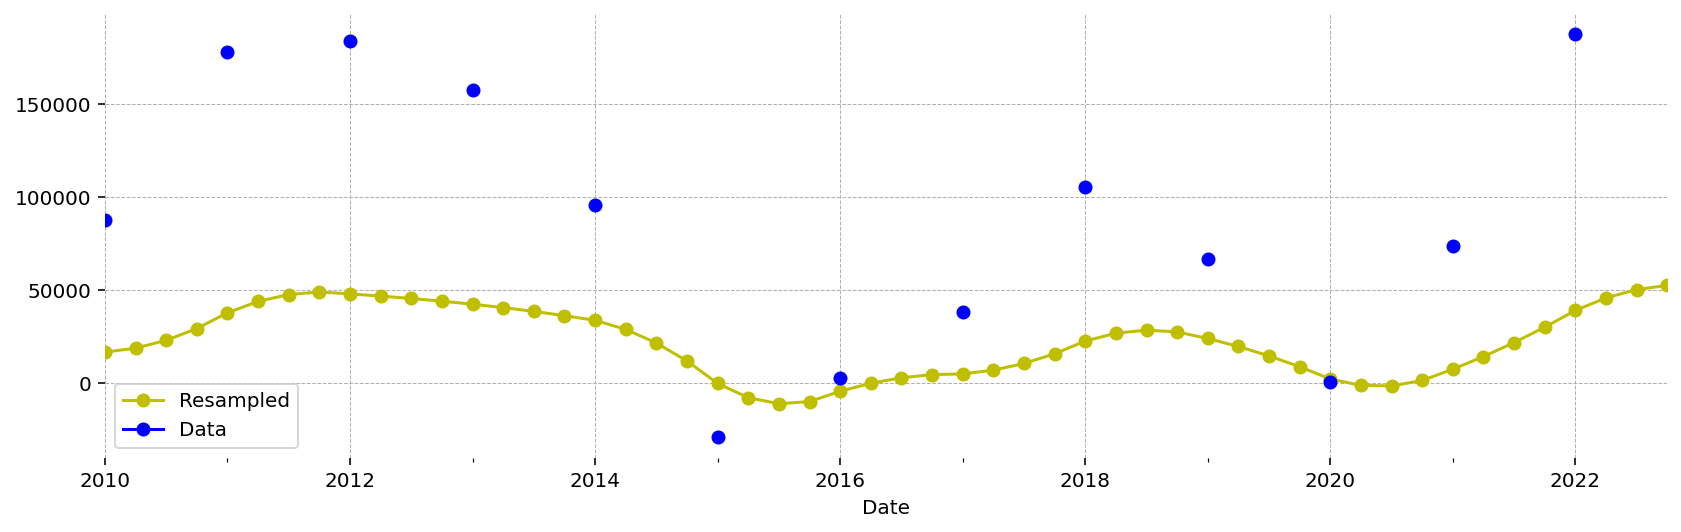

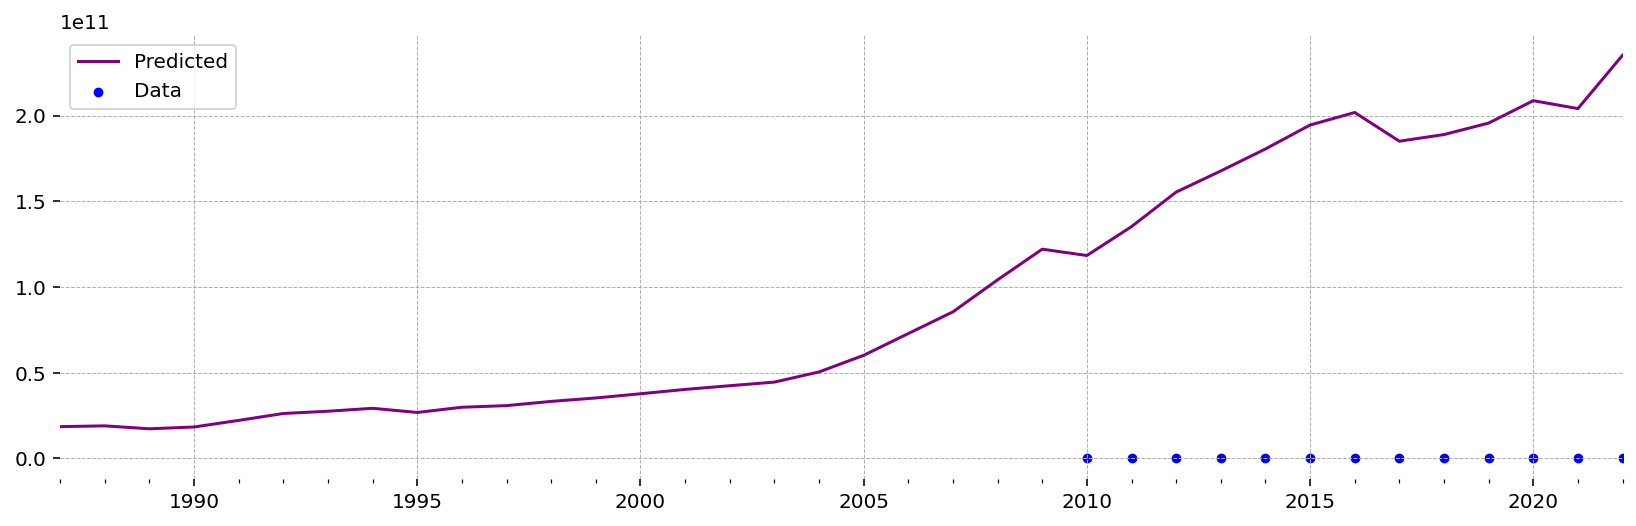

Optimization terminated successfully.
         Current function value: 2.887800
         Iterations: 402
         Function evaluations: 692


###### No currency conversion needed, since data are already provided in US dollar units. 

#### 3.6) Progressive merging 

In [ ]:
#Drop temporary columns
df3p = df3p.drop('diff_log_I', axis=1)
#merge step 2 merged dataset with df3
df3m= pd.merge(df2m, df3p, on='Date')
df3m.head()

#### 4) <u>TB=Trade Balance trade in goods and services<u/>

#### 4.1) Data reshaping 

In [203]:
# Create a disaggregate version of TB to derive quarterly data from a yearly dataframe
TB_only = final_df['TB'].dropna().copy()
TB_resample = disaggregate_series(TB_only, target_freq='QS', agg_func='sum')

# Plot the resampled data
TB_resample.resample('QS').asfreq().plot(label='Resampled', marker='o', color='y')

# Plot the original data
final_df['TB'].dropna().resample('QS').asfreq().plot(label='Original', marker='o', color='b')

# Add legend and display the plot
plt.legend()
plt.show()

# Display the resampled TB data
print(TB_resample)








KeyError: 'TB'

In [204]:
import pandas as pd
import pandas_datareader.wb as wb
#Define World Bank indicator code for Trade Balance
indicator_code = 'BN.GSR.GNFS.CD'
#Define the countries and time period
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'
#Fetch World Bank data using pandas_datareader
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)
#Reset index to build Date column
world_bank_data.reset_index(inplace=True)
#Drop country
world_bank_data.drop('country', axis=1, inplace=True)
#Rename year to Date
world_bank_data.rename(columns={'year': 'Date', 'BN.GSR.GNFS.CD': 'TB'}, inplace=True)
#Convert date on datetime format for proper plotting
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['TB'] = world_bank_data['TB'] / 1_000_000
#Sort the DataFrame by the 'Date' column in descending order
world_bank_data = world_bank_data.sort_values(by='Date', ascending=True)
df4 = world_bank_data.copy()
df4.info()
df4.head()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 12 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    13 non-null     datetime64[ns]
 1   TB      13 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.0 bytes


Date             TB
12 2010-01-01   87627.967475
11 2011-01-01  178246.906733
10 2012-01-01  184213.302925
9  2013-01-01  157750.352290
8  2014-01-01   95966.244483

#### 4.3) Log adjustment (Stationarity test)

In [ ]:
#Here we have something different from the previous variables, since, as we know from macro101, the value of a trade balance can be potentially be negative (Imp>Exp)
#Hence, we can takle these negative sign results as we are used to other variables, since we may have "gaps" in our plot 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#To deal with negative values, we can just easily add an enough small constant to the whole dataframe without causing any bias to the analysis
#As constant we use a fraction of the minimum value of TB (based on XYZ idea)
min_value = df4p['TB'].min()
constant = abs(0.1 * min_value)
#Custom log transformation function from the original that we have previously used 
def safe_log(x):
    return np.log(x + constant) if x > 0 else np.nan
#Apply the custom log transformation to each value of TB
log_transformed = df4p['TB'].apply(safe_log).diff()
#Interpolate missing values (the ones that otherwise would create gaps and non-continuity in our graph)
log_transformed.interpolate(inplace=True)
#Plot the log-transformed differences
log_transformed.plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of TB over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of TB
df4p['log_TB'] = df4p['TB'].map(np.log)
df4p['diff_log_TB'] = df4p['log_TB'].diff()
#Include the 'Date' column from df4p
d_log_TB = df4p[['Date']].copy()
d_log_TB['diff_log_TB'] = df4p['diff_log_TB']
d_log_TB.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df4p['TB'])

#### After the ADF test, it seems evident that our data exhibits non-stationarity for all model configurations. The T-statistic of -1.740, while not extreme, remains above the critical value of -4.148 at the 1% significance level. This implies that a unit root might still be present, indicating the data's non-stationary behavior.### 
=> This hints at the importance of further data adjustments to potentially achieve stationarity.

#### 4.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_TB['Quarter'] = d_log_TB['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_TB_pivot = d_log_TB.pivot_table(index='Quarter', columns=d_log_TB['Date'].dt.year, values='diff_log_TB')
#Display the pivot table
d_TB_pivot.head()

In [ ]:
d_TB_pivot.plot(legend=False);

###### Results highly differ again from typical seasonal trends. Values seem not following recursive cycles. Not adjusting for seasonality. 

##### 4.5) Currency conversion

###### No currency conversion needed, since data are already provided in US dollar units. 

#### 4.6) Progressive merging 

In [ ]:
#Drop temporary columns
df4p = df4p.drop('diff_log_TB', axis=1)
#merge step 2 merged dataset with df3
df4m= pd.merge(df3m, df4p, on='Date')
df4m.head()

#### 5) <u>N=Average Hours of Work for Employed Persons<u/>

#### 5.1) Data reshaping

In [27]:
#Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Average Hours of Work for Employed Persons
N_data = {
    '2016 / Q2': [38.96775504],
    '2016 / Q3': [38.57034481],
    '2016 / Q4': [38.75315665],
    '2017 / Q1': [39.09336699],
    '2017 / Q2': [38.85986074],
    '2017 / Q3': [38.9159003],
    '2017 / Q4': [39.58174661],
    '2018 / Q1': [38.64750733],
    '2018 / Q2': [38.80551713],
    '2019 / Q1': [38.94281089],
    '2019 / Q2': [38.43955095],
    '2019 / Q3': [38.17616634],
    '2019 / Q4': [37.88810263],
    '2020 / Q1': [38.35162171],
    '2020 / Q2': [39.31892759],
    '2020 / Q3': [39.65375889],
    '2020 / Q4': [40.16204173],
    '2021 / Q1': [39.01231081],
    '2021 / Q2': [38.43177217],
    '2021 / Q3': [39.30209818],
    '2021 / Q4': [40.29776716],
    '2022 / Q1': [39.84260952],
    '2022 / Q2': [40.12209799],
    '2022 / Q3': [40.72582419],
    '2022 / Q4': [40.11837913],
    '2023 / Q1': [40.01679873],
    '2023 / Q2': [40.35208325]
}
#Create a dataframe from the table
df5 = pd.DataFrame(N_data)
#In this structure, we have values for Nt alligned on single row, we prefer a column
df5 = df5.transpose()
#Rename the columns to fit the variable in question
df5.columns = ['N']
#Convert the index to datetime format with format specification
df5.index = pd.to_datetime(df5.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))
df5.index.name = 'Date'
df5.head()

N
Date                 
2016-04-01  38.967755
2016-07-01  38.570345
2016-10-01  38.753157
2017-01-01  39.093367
2017-04-01  38.859861

#### 5.2) Data format & General overview

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#Set the display format for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)
#Summary statistics
summary_stats = df5.describe()
#min and max values
min_values = df5.min()
max_values = df5.max()
#Display the summary statistics, min, and max values
print("Summary Statistics:")
print(summary_stats)
print("\nMin Values:")
print(min_values)
print("\nMax Values:")
print(max_values)
#Histogram
plt.figure(figsize=(10, 6))
plt.hist(df5['N'], bins=10, color='purple', edgecolor='white')
plt.title('Distribution of N')
plt.xlabel('N')
plt.ylabel('Frequency')
plt.show()
#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df5.index, df5['N'], color='b')
plt.title('Scatter Plot of N over time')
plt.xlabel('Date')
plt.ylabel('N')
plt.show()

#### 5.3) Missing observations' prediction

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
#Since data are available only up to 2016, we do want to predict possible past trends to deduce those missing observations we have. 
df5p = pd.DataFrame()
#Loop through quarters from 2010-01-01 to 2016-12-01
for year in range(2010, 2017):
    for quarter in range(1, 5):
#Predict for the current quarter
        X_pred = np.array([[year, quarter]])
        prediction = model.predict(X_pred)
#Once the forecast is created, append the prediction to the new DataFrame
        df5p = pd.concat([df5p, pd.DataFrame({
            'Date': [pd.to_datetime(f"{year}-{quarter*3 - 2:02d}-01")],
            'Prediction': [prediction[0]]
        })], ignore_index=True)
#Set the Date column as the index
df5p.set_index('Date', inplace=True)
#Rename the prediction column 
df5p.rename(columns={'Prediction': 'N'}, inplace=True)
df5p.head()

In [ ]:
import matplotlib.pyplot as plt
#Plot our both  predicted and real data  
plt.plot(df5.index, df5['N'], label='Data', marker='o', linestyle='-', color= 'y')
plt.plot(df5p.index, df5p['N'], label='Predicted', marker='o', linestyle='-', color='purple')
plt.xlabel('Date')
plt.ylabel('N')
plt.legend()
plt.show()

In [ ]:
#Now merge the two datasets, appending at the beginning of df5 the new dataframe, df5p, containing predictions on the timespan 2010-2016.
#We also want to give priority to real data in case of overlapping values, hence, we will prioritize to df5
df5pm= df5p.combine_first(df5)
#Drop not useful columns
df5pm.drop(columns=['Year', 'Quarter'], inplace=True)
df5pm.head()

#### 5.4) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df5pm.N.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of N over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of N
import numpy as np
import pandas as pd
df5pm['log_N'] = np.log(df5pm['N'])
#Derive the difference log
df5pm['diff_log_N'] = df5pm['log_N'].diff()
#Include the 'Date' column from df5pm
d_log_N = df5pm[['diff_log_N']].copy()
d_log_N['Date'] = df5pm.index  # Assuming 'Date' is the index
d_log_N.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df5['N'])

##### The ADF test results consistently suggest that our data is non-stationary across all model configurations. The T-statistics are not sufficiently low to reject the presence of a unit root, and the p-values are high, further supporting this conclusion.
#### 
=> Given these findings, it's crucial tods to transform or adjust the data to achieve stationarity before applying certain time series anales s.

#### 5.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_N['Quarter'] = d_log_N['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_N_pivot = d_log_N.pivot_table(index='Quarter', columns=d_log_N['Date'].dt.year, values='diff_log_N')
#Display the pivot table
d_N_pivot.head()

In [ ]:
d_N_pivot.plot(legend=False);

###### (!!!!MUST BE CHECKED, THERE IS PROBABLY SOMETHING WRONG IN D_LOG_N!!!!!!!) Results seem not completly random but neither completly non random. Not adjusting for seasonality. 

#### 5.5) Progressive merging

In [ ]:
#Drop temporary columns
df5pm = df5pm.drop('diff_log_N', axis=1)
#merge step 2 merged dataset with df3
df5m= pd.merge(df4m, df5pm, on='Date')
df5m.head()

#### 6) <u>w=Average Monthly Wages for Paid Employees<u/>

#### 6.1) Data reshaping

In [ ]:
#Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Average Monthly Wages for Paid Employees
w_data = {
    '2016 / Q2': [10462.10642],
    '2016 / Q3': [9712.357822],
    '2016 / Q4': [10227.10574],
    '2017 / Q1': [9884.23959],
    '2017 / Q2': [9910.831884],
    '2017 / Q3': [10011.63187],
    '2017 / Q4': [9939.325367],
    '2018 / Q1': [10088.82327],
    '2018 / Q2': [10237.6998],
    '2019 / Q1': [10299.10765],
    '2019 / Q2': [10341.84075],
    '2019 / Q3': [10273.0132],
    '2019 / Q4': [10256.36242],
    '2020 / Q1': [10302.70319],
    '2020 / Q2': [9970.297977],
    '2020 / Q3': [9971.056802],
    '2020 / Q4': [10539.69348],
    '2021 / Q1': [10599.8789],
    '2021 / Q2': [10491.248],
    '2021 / Q3': [10474.12402],
    '2021 / Q4': [10185.54969],
    '2022 / Q1': [9811.756473],
    '2022 / Q2': [10430.41218],
    '2022 / Q3': [9583.143722],
    '2022 / Q4': [9701.453807],
    '2023 / Q1': [9893.242042],
    '2023 / Q2': [9923.604891]
}
#Create a dataframe from the table
df6 = pd.DataFrame(w_data)
#In this structure, we have values for Nt alligned on single row, we prefer a column
df6 = df6.transpose()
#Rename the columns to fit the variable in question
df6.columns = ['w']
#Convert the index to datetime format with format specification
df6.index = pd.to_datetime(df6.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))
df6.index.name = 'Date'
df6.head()

#### 6.2) Data format & General overview

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#Set the display format for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)
#Summary statistics
summary_stats = df6.describe()
#min and max values
min_values = df6.min()
max_values = df6.max()
#Display the summary statistics, min, and max values
print("Summary Statistics:")
print(summary_stats)
print("\nMin Values:")
print(min_values)
print("\nMax Values:")
print(max_values)
#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df6.index, df6['w'], color='b')
plt.title('Scatter Plot of w over time')
plt.xlabel('Date')
plt.ylabel('w')
plt.show()

#### 6.3) Missing observations' prediction

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
#Since data are available only up to 2016, we do want to predict possible past trends to deduce those missing observations we have. 
df6p = pd.DataFrame()
#Loop through quarters from 2010-01-01 to 2016-12-01
for year in range(2010, 2017):
    for quarter in range(1, 5):
#Predict for the current quarter
        X_pred = np.array([[year, quarter]])
        prediction = model.predict(X_pred)
#Once the forecast is created, append the prediction to the new DataFrame
        df6p = pd.concat([df6p, pd.DataFrame({
            'Date': [pd.to_datetime(f"{year}-{quarter*3 - 2:02d}-01")],
            'Prediction': [prediction[0]]
        })], ignore_index=True)
#Set the Date column as the index
df6p.set_index('Date', inplace=True)
#Rename the prediction column 
df6p.rename(columns={'Prediction': 'w'}, inplace=True)
df6p.head()

#### 7) <u>Rt=Real Long Term Bond Rate (10 years)<u/>

In [ ]:
# Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Real Long Term Bond Rate
Rt_data = {
    '2007 / Q1': [5.0], 
    '2007 / Q2': [5.0], 
    '2007 / Q3': [5.0],
    '2007 / Q4': [5.0], 
    '2006 / Q1': [5.25], 
    '2006 / Q2': [5.25], 
    '2006 / Q3': [5.5], 
    '2006 / Q4': [5.5], 
    '2005 / Q1': [5.25], 
    '2005 / Q2': [5.25],
    '2005 / Q3': [4.625],
    '2005 / Q4': [4.625], 
    '2004 / Q1': [2.75],
    '2004 / Q2': [2.75], 
    '2004 / Q3': [2.0],
    '2004 / Q4': [5.194], 
    '2003 / Q1': [2.69], 
    '2003 / Q2': [3.72], 
    '2003 / Q3': [4.36], 
    '2003 / Q4': [3.6], 
    '2002 / Q1': [3.5], 
    '2002 / Q2': [5.05], 
    '2002 / Q3': [5.74], 
    '2002 / Q4': [6.36], 
    '2001 / Q1': [5.74], 
    '2001 / Q2': [6.79],
    '2001 / Q3': [6.36]
}
# Create a dataframe from the table
df7 = pd.DataFrame(Rt_data)
# In this structure, we have values for Nt alligned on single row, we prefer a column
df7 = df7.transpose()
# Rename the columns to fit the variable in question
df7.columns = ['Rt']
# Convert the index to datetime format with format specification
df7.index = pd.to_datetime([f"{quarter.split(' / ')[0]}-{quarter.split(' / ')[1].replace('Q', '-')}-01" for quarter in df7.index])
print(df7.head())

#### 8) <u>rt=Real Short Term Bond Rate (3 months)<u/>

In [ ]:
# Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Real Short Term Bond Rate
rt_data = {
    'Q1 2007': [5.086876667],
    'Q2 2007': [5.044793333],
    'Q3 2007': [5.05125],
    'Q4 2007': [4.4375],
    'Q1 2008': [2.750729167],
    'Q2 2008': [2.497683913],
    'Q3 2008': [4.017900408],
    'Q4 2008': [3.872003205],
    'Q1 2009': [1.357266144],
    'Q2 2009': [0.889771282],
    'Q3 2009': [0.647518846],
    'Q4 2009': [0.750644872],
    'Q1 2010': [0.760368333],
    'Q2 2010': [0.726157867],
    'Q3 2010': [0.721976538],
    'Q4 2010': [0.734948077],
    'Q1 2011': [0.75],
    'Q2 2011': [0.714846092],
    'Q3 2011': [0.604153205],
    'Q4 2011': [0.708867179],
    'Q1 2012': [0.832301795],
    'Q2 2012': [0.906203974],
    'Q3 2012': [0.95003641],
    'Q4 2012': [0.976722821],
    'Q1 2013': [0.97589924],
    'Q2 2013': [0.95818661],
    'Q3 2013': [0.958199266],
    'Q4 2013': [0.920658071],
    'Q1 2014': [0.953805303],
    'Q2 2014': [0.951747835],
    'Q3 2014': [0.945912698],
    'Q4 2014': [0.891596032],
    'Q1 2015': [0.8162],
    'Q2 2015': [0.773933333],
    'Q3 2015': [0.828233333],
    'Q4 2015': [1.1004],
    'Q1 2016': [1.715762063],
    'Q2 2016': [2.072859778],
    'Q3 2016': [2.280601229],
    'Q4 2016': [2.195467532],
    'Q1 2017': [1.886523287],
    'Q2 2017': [1.741016667],
    'Q3 2017': [1.794616026],
    'Q4 2017': [1.82451746],
    'Q1 2018': [1.9542],
    'Q2 2018': [2.414533333],
    'Q3 2018': [2.6192],
    'Q4 2018': [2.815995514],
    'Q1 2019': [2.934282911],
    'Q2 2019': [2.821566807],
    'Q3 2019': [2.513837534],
    'Q4 2019': [2.257692993],
    'Q1 2020': [1.886206605],
    'Q2 2020': [1.127925385],
    'Q3 2020': [0.916],
    'Q4 2020': [0.839034731],
    'Q1 2021': [0.807223763],
    'Q2 2021': [0.793675606],
    'Q3 2021': [0.796229903],
    'Q4 2021': [0.842836559],
    'Q1 2022': [1.364613437],
    'Q2 2022': [2.714606047],
    'Q3 2022': [3.140852573],
    'Q4 2022': [5.281579513],
    'Q1 2023': [5.494883633],
    'Q2 2023': [5.830097591],
    'Q3 2023': [6.088936188],
}
# Create a dataframe from the table
df8 = pd.DataFrame(rt_data)
# In this structure, we have values for Nt alligned on single row, we prefer a column
df8 = df8.transpose()
# Rename the columns to fit the variable in question
df8.columns = ['rt']
# Convert the index to datetime format with format specification
df8.index = pd.to_datetime([f"{quarter.split(' ')[1]}-{quarter.split(' ')[0][1:]}-01" for quarter in df8.index])
print(df8.head())

In [ ]:
### Step 9 ## Capital Stock at Constant National Prices
## in USD
## quarterly numbers

data = FredReader(symbols=['RKNANPSAA666NRUG'], start='2010', end=None).read()
data.to_csv('Cap_stock_at_Constant_National_Prices_USD.csv')

# Read the CSV file and parse 'DATE' as datetime
df9 = pd.read_csv('Cap_stock_at_Constant_National_Prices_USD.csv', parse_dates=['DATE'])

# save for merging later 
df9.to_csv('Cap_stock_at_Constant_National_Prices_USD.csv', index=False)

# Rename the columns
df9.columns = ['Date', 'K']

# Display the DataFrame
df9.head()
df9.info()


In [ ]:
### Step 10 ## Current Account	BN.CAB.XOKA.GD.ZS
#Current account balance % of GDP, Annual

## data is in percent

import pandas as pd
import pandas_datareader.wb as wb

# Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'BN.CAB.XOKA.GD.ZS'

# Define the countries and time period you are interested in (only Saudi Arabia in this case)
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)

# Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)

# Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)

# Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'BN.CAB.XOKA.GD.ZS': 'CA'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'

df10 = world_bank_data.copy()
df10.info()
df10.head()

In [ ]:
### Step 10.2 ## Current Account	BN.CAB.XOKA.GD.ZS
#Current account balance % of GDP, Annual

## change to quarterly


In [ ]:
### Step 11 ## Consumer Prices	FP.CPI.TOTL.ZG
#Current account balance % of GDP, Annual

## data is in percent

import pandas as pd
import pandas_datareader.wb as wb

# Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'FP.CPI.TOTL.ZG'

# Define the countries and time period you are interested in (only Saudi Arabia in this case)
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)

# Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)

# Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)

# Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'FP.CPI.TOTL.ZG': 'CPI'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'

df11 = world_bank_data.copy()
df11.info()
df11.head()

In [ ]:
### Step 11.2 ## Consumer Prices	FP.CPI.TOTL.ZG

## change to quarterly


In [ ]:
### Step 13 ## Oil prices  Prices

## in USD
## weekly numbers

data = FredReader(symbols=['DCOILWTICO'], start='2010', end=None).read()
data.to_csv('Cruide_oil_barrel_USD.csv')

# Read the CSV file and parse 'DATE' as datetime
df13 = pd.read_csv('Cruide_oil_barrel_USD.csv', parse_dates=['DATE'])

# save for merging later 
df13.to_csv('Cruide_oil_barrel_USD.csv', index=False)

# Rename the columns
df13.columns = ['Date', 'Oil']

# Display the DataFrame
df13.head()


In [ ]:
import warnings

# Suppress FutureWarning messages as it onl tells us about future warning of the end of our package. Does not matter right now
warnings.simplefilter(action='ignore', category=FutureWarning) 

### step 13 # handle missing values
df13['Date'] = pd.to_datetime(df13['Date'])
df13.set_index('Date', inplace=True)

# Fill missing values using forward fill and backward fill
df13_filled = df13.fillna((df13.ffill() + df13.bfill()) / 2)

# Plot the data using DatetimeIndex
df13_filled.Oil.plot(label='Weekly', legend=True)
### Step 13 ## Oil prices  Plot them
df13_filled.Oil.plot(label='Weekly', legend=True)
df13_quarterly.Oil.plot(label='Quarterly', legend=True)

In [ ]:
### Step 13 ## Oil prices  Prices change to quarterly
df13_quarterly = df13_filled.resample('Q').mean()

## in USD
## weekly numbers

In [ ]:
### Step 13 ## Oil prices  Plot them
df13_filled.Oil.plot(label='Weekly', legend=True)
df13_quarterly.Oil.plot(label='Quarterly', legend=True)

In [ ]:
### last step merge all df frames
# Merge the first two DataFrames on the 'Date' column
df_merged = pd.merge(df1, df2, on='Date')

# Merge the result with the third DataFrame ('I_predict') on the 'Date' column
df_merged = pd.merge(df_merged, I_predict, on='Date')

In [ ]:
df_merged.head()


In [ ]:
##### Actual Modelling

# check rbc.check_bk_condition and comment on it
# with too many eigenvalues the agents cant fix the shocks
# with too little the agents cant choose
# goal 2 eigenvalues greater than 1
# something else as well

In [ ]:
#### Actual Modelling
# plot eigenvalues
# two should be in the circle gp-plot eigengalues
# 

In [ ]:
#### Fitting the model
# creativity points for rbc.fit example for that on the github in his gEconpy (example notebook fitting RBC to US Data)
# full info bayesian estimatition, you get whole probability distribution (1 hour for jessi to fit, so 10 for us)
# mle_model for maximum likelihood
# estimate only a couple parameters (in his example he only did rho_A 
# starting value for the standard deviation
# type in 0.5 so 96% will be between -1 and 1 (two times what he wrote because of T-test 1,96 thingy)
# so adjust epsilon accordingly
# com,pate to log_df.train. describe should be close to our Y but not the same cause why model otherwise

#put noise on data as we ahve so much yearly data

# param transformers
# simulated annealing to escape the data wholes in our data/parameters
# because of all the ups and downs there is no point of following the line

# look at the kalman one steap ahead predictions
# is true data within confidence interval?
# loook at dynmaisc and compare predicted with real series
# always look for break points where the quality of the behavior changes
# think about why some graphs look the same (think about how you solve for the variables)
# confidence intervall often bigger at the beginning of the daata
# filter_output='smoothed' that gives you forward predicitons and then goes back and incorporates the forward predicitions 
# usually the error bars kinda go to zero 

# last thing is impulse response function irf
# which variables are driving the dynamisc? epsilions
# rate of decrease is governed by which parameter? in A it is rho
# play that game for the other variables. Which look similiar?
# consumption smoothing, eueler equation
# do variables overshoot?


RBC MODEL

In [ ]:
!pip install gEconpy
!pip install matplotlib

In [ ]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp

import matplotlib.pyplot as plt

In [ ]:
def compare_steady_states(models, names):
    all_keys = set()
    for model in models:
        all_keys = all_keys.union(set(list(model.steady_state_dict.keys())))
    
    header = ' ' * 10 + ''.join([f'{name:>10}' for name in names])
    print(header)
    print('-' * len(header))

    for key in all_keys:
        line = f'{key:<10}'
        for model in models:
            if key in model.steady_state_dict.keys():
                value = f'{model.steady_state_dict[key]:>10.3f}'
            else:
                value = f'{"---":>10}'
            line += value 
        print(line)

In [ ]:
rbc = ge.gEconModel('GNC/test.gcn')

In [ ]:
rbc.steady_state()
rbc.solve_model()

In [ ]:
rbc.print_steady_state()

Impulse Response Function

In [ ]:
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)
gp.plot_irf(base_irf, legend=True);

In [ ]:
#check eigenvalues
rbc.check_bk_condition()

In [ ]:
#plot eigenvalues
gp.plot_eigenvalues(rbc);

In [ ]:
#plot covariesnces
gp.plot_covariance_matrix(rbc.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

In [ ]:
#plot autocorrelation
gp.plot_acf(rbc.compute_autocorrelation_matrix(n_lags=25));

Model Extension


Solve Model

In [ ]:
capital_adj.steady_state()
capital_adj.solve_model()

In [ ]:
#adjust baseline and k adj
compare_steady_states([rbc, capital_adj], ['Baseline', 'K Adj'])

In [ ]:
gp.plot_covariance_matrix(capital_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

Autocorrelation Functions

In [ ]:
gp.plot_acf(capital_adj.compute_autocorrelation_matrix(n_lags=40));

Compare Impulse Response Functions

In [ ]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['I'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\nCapital Adjustment Cost Model')
plt.show()

In [ ]:
# figure comparing tobins q
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nCapital Adjustment Cost Model")
plt.show()

Extension 1: Add Oil Price Shock

In [ ]:
inv_adj = ge.gEconModel('GCN Files/Oil Price.gcn')

In [ ]:
inv_adj.steady_state()
inv_adj.solve_model()

In [ ]:
for eq in inv_adj.system_equations:
    display(eq)

In [ ]:
compare_steady_states([rbc, inv_adj], ['Baseline', 'I Adj'])

Covariance Matrix

In [ ]:
gp.plot_covariance_matrix(inv_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

Autocorrelation Functions

In [ ]:
gp.plot_acf(inv_adj.compute_autocorrelation_matrix(n_lags=40));

Impulse response Functions

In [ ]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['I'].droplevel(1).plot(label=f'IAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\Investment Adjustment Cost Model')
plt.show()

In [ ]:
# comparing tobins q
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nInvestment Adjustment Cost Model")
plt.show()

In [ ]:
Extension 3: 2 Firm + Oil Pirce